In [2]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from IPython import display
from mi_tool import MI
from timeit import default_timer as timer

In [2]:
tf.__version__

'1.5.0'

In [3]:
from mnist import MNIST

In [4]:
mndata = MNIST('./data/mnist')
mndata.gz = True

In [5]:
images, labels = mndata.load_training()

In [6]:
def preview(img):
    """
    Render a image list into visible image
    """
    img_data = np.array(img)
    img_data = np.reshape(img_data, newshape=((28, 28)))
    plt.imshow(img_data, cmap=mpl.cm.Greys)
    plt.show()

In [7]:
def load_data(mode='training'):
    Xdata, Ydata, labels = None, None, None
    rows = None
    
    img_width  = 28
    img_height = 28
    
    if mode == 'training':
        rows = 60000
        Xdata, labels = mndata.load_training()
    elif mode == 'testing':
        rows = 10000
        Xdata, labels = mndata.load_testing()
    else:
        raise ValueError('mode is neither training nor testing')
        
    Xdata = np.array(Xdata, dtype=np.uint8)
    Xdata = np.reshape(Xdata, newshape=(rows, img_width, img_height, 1))
    
    Ylabels = np.array(labels, dtype=np.uint)
    Ydata = np.zeros((rows, 10), dtype=np.float32)
    Ydata[np.arange(rows), Ylabels] = 1
    
    return (Xdata, Ydata, Ylabels)

In [8]:
Xdata, Ydata, Ylabels = load_data('training')
Xtest_data, Ytest_data, Ytest_labels = load_data('testing')

In [9]:
print("Training data shape: {}".format((Xdata.shape, Ydata.shape, Ylabels.shape)))
print("Test data shape: {}".format((Xtest_data.shape, Ytest_data.shape, Ytest_labels.shape)))

Training data shape: ((60000, 28, 28, 1), (60000, 10), (60000,))
Test data shape: ((10000, 28, 28, 1), (10000, 10), (10000,))


In [10]:
def build_model():
    weights = {
        'conv1': tf.Variable(tf.random_normal([5, 5, 1, 4])),
        'conv2': tf.Variable(tf.random_normal([5, 5, 4, 8])),
        'W1': tf.Variable(tf.random_normal([7*7*8, 200])),
        'W2': tf.Variable(tf.random_normal([200, 10]))
    }

    biases = {
        'convb1': tf.Variable(tf.random_normal([4])),
        'convb2': tf.Variable(tf.random_normal([8])),
        'b1': tf.Variable(tf.random_normal([200])),
        'b2': tf.Variable(tf.random_normal([10]))
    }
    
    X = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='X')
    Y = tf.placeholder(tf.float32, shape=[None, 10], name='Y')

    conv1 = tf.nn.conv2d(X, weights['conv1'], strides=[1, 1, 1, 1], padding='SAME')
    convb1 = tf.nn.bias_add(conv1, biases['convb1'])
    maxpool1 = tf.nn.max_pool(convb1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    act1 = tf.nn.tanh(maxpool1)

    conv2 = tf.nn.conv2d(act1, weights['conv2'], strides=[1, 1, 1, 1], padding='SAME')
    convb2 = tf.nn.bias_add(conv2, biases['convb2'])
    maxpool2 = tf.nn.max_pool(convb2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    act2 = tf.nn.tanh(maxpool2)

    reshaped = tf.reshape(act2, shape=[-1, 7*7*8])
    fc1 = tf.matmul(reshaped, weights['W1']) + biases['b1']
    fc_act1 = tf.nn.tanh(fc1)
    fc_drop1 = tf.nn.dropout(fc_act1, keep_prob=0.75)

    out = tf.matmul(fc1, weights['W2']) + biases['b2']

    prediction = tf.nn.softmax(out)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=out, labels=Y))
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    gradients = optimizer.compute_gradients(loss,
                                            var_list=[weights['conv1'],
                                                      weights['conv2'],
                                                      weights['W1'],
                                                      weights['W2'],
                                                      biases['convb1'],
                                                      biases['convb2'],
                                                      biases['b1'],
                                                      biases['b2']
                                                     ])
    
    train_op = optimizer.apply_gradients(gradients)

    initializer = tf.global_variables_initializer()
    
    return {
        'X': X,
        'Y': Y,
        'Weights': weights,
        'Biases': biases,
        'gradients': [g for (g, v) in gradients],
        'hidden': (act1, act2, fc_act1, fc_drop1),
        'loss': loss,
        'predict': prediction,
        'train': train_op,
        'initializer': initializer
    }

In [11]:
model = build_model()

In [12]:
sess = tf.Session()
sess.run(model['initializer'])

In [13]:
# mutual_info_recorder = MI(Xdata, Ydata, 10)
# mutual_info_recorder.discretize()
# mutual_info_recorder.pre_compute()

In [14]:
import pickle
# Save this result since it's very expensive to compute
# with open('mi_recorder.pickle', 'wb') as f:
#    pickle.dump(mutual_info_recorder, f)
with open('mi_recorder.pickle', 'rb') as f:
    mutual_info_recorder = pickle.load(f)

<IPython.core.display.Javascript object>


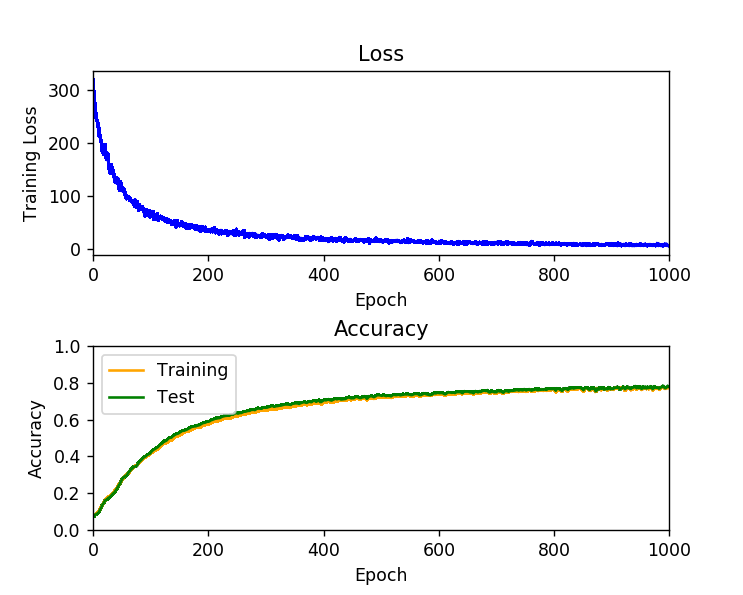

Epoch 0, took GPU time 1.3377597500002594, CPU time 5.010118447999048
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.019196185751113894, 0.019196185751113894, 0.019196185751113894, 0.019196185751113887]
Epoch 1, took GPU time 0.18020755100042152, CPU time 3.7644948640008806
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01916216799443758, 0.01916216799443758, 0.01916216799443758, 0.01916216799443758]
Epoch 2, took GPU time 0.19209878699984984, CPU time 3.7566636970004765
Encoder MI: [0.0916726128903586, 0.0916726128903586, 0.0916726128903586, 0.09167261289035859]
Decoder MI: [0.01918748339390028, 0.01918748339390028, 0.01918748339390028, 0.01918748339390028]
Epoch 3, took GPU time 0.18663828800163174, CPU time 3.7523713710015727
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.019210870552048284,

Epoch 31, took GPU time 0.1857208189994708, CPU time 3.741043358000752
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019202709035502794, 0.019202709035502794, 0.019202709035502794, 0.019202709035502794]
Epoch 32, took GPU time 0.18308568700012984, CPU time 3.7358761229988886
Encoder MI: [0.09166106043734927, 0.09166106043734927, 0.09166106043734927, 0.09166106043734927]
Decoder MI: [0.019181588491190553, 0.019181588491190553, 0.019181588491190553, 0.01918158849119055]
Epoch 33, took GPU time 0.18103853700085892, CPU time 3.7284681600012846
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019180663766639044, 0.019180663766639044, 0.019180663766639044, 0.019180663766639044]
Epoch 34, took GPU time 0.1819485390005866, CPU time 3.7749252909998177
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019158

Epoch 62, took GPU time 0.2383144089999405, CPU time 3.7753453589994024
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019168295180320365, 0.019168295180320365, 0.019168295180320365, 0.01916829518032036]
Epoch 63, took GPU time 0.18741809799939801, CPU time 3.7291504639997584
Encoder MI: [0.0916658551385568, 0.0916658551385568, 0.0916658551385568, 0.09166585513855678]
Decoder MI: [0.019143567951219662, 0.019143567951219662, 0.019143567951219662, 0.019143567951219662]
Epoch 64, took GPU time 0.18317812199893524, CPU time 3.721955811999578
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019184136174206737, 0.019184136174206737, 0.019184136174206737, 0.019184136174206737]
Epoch 65, took GPU time 0.1859924639993551, CPU time 3.7551301249986864
Encoder MI: [0.09166585513855678, 0.09166585513855678, 0.09166585513855678, 0.09166585513855678]
Decoder MI: [0.019171013

Epoch 93, took GPU time 0.19872314700114657, CPU time 3.770870961001492
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.019188948549170456, 0.019188948549170456, 0.019188948549170456, 0.01918894854917046]
Epoch 94, took GPU time 0.18471643999873777, CPU time 3.777401231998738
Encoder MI: [0.09167261289035858, 0.09167261289035858, 0.09167261289035858, 0.09167261289035858]
Decoder MI: [0.01916444051293179, 0.01916444051293179, 0.01916444051293179, 0.01916444051293179]
Epoch 95, took GPU time 0.18564749600045616, CPU time 3.739249086998825
Encoder MI: [0.09165430268554746, 0.09165430268554746, 0.09165430268554746, 0.09165430268554746]
Decoder MI: [0.01917397405943042, 0.01917397405943042, 0.01917397405943042, 0.019173974059430422]
Epoch 96, took GPU time 0.18951642999854812, CPU time 3.7824349909988086
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.0191560231617

Epoch 124, took GPU time 0.18694549999963783, CPU time 3.7573905669996748
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019196687296767097, 0.019196687296767097, 0.019196687296767097, 0.019196687296767097]
Epoch 125, took GPU time 0.19486410099852947, CPU time 3.757242239998959
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019216199452417062, 0.019216199452417062, 0.019216199452417062, 0.019216199452417065]
Epoch 126, took GPU time 0.19132146499941882, CPU time 3.763314112000444
Encoder MI: [0.09165430268554746, 0.09165430268554746, 0.09165430268554746, 0.09165430268554746]
Decoder MI: [0.01914483365481126, 0.01914483365481126, 0.01914483365481126, 0.01914483365481126]
Epoch 127, took GPU time 0.18874758799938718, CPU time 3.76596095000059
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.019185

Epoch 155, took GPU time 0.19083586600027047, CPU time 3.7792298439999286
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.01919414394009433, 0.01919414394009433, 0.01919414394009433, 0.019194143940094333]
Epoch 156, took GPU time 0.18519375300093088, CPU time 3.7922086079997825
Encoder MI: [0.09167261289035859, 0.09167261289035859, 0.09167261289035859, 0.09167261289035859]
Decoder MI: [0.019144196392038983, 0.019144196392038983, 0.019144196392038983, 0.019144196392038983]
Epoch 157, took GPU time 0.1882661769996048, CPU time 3.783374897999238
Encoder MI: [0.09166585513855678, 0.09166585513855678, 0.09166585513855678, 0.09166585513855678]
Decoder MI: [0.019219919979047952, 0.019219919979047952, 0.019219919979047952, 0.019219919979047952]
Epoch 158, took GPU time 0.18516783000086434, CPU time 3.7552171959996485
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019

Epoch 186, took GPU time 0.19022745700021915, CPU time 3.769975795999926
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019173211396957275, 0.019173211396957275, 0.019173211396957275, 0.019173211396957275]
Epoch 187, took GPU time 0.18469612400076585, CPU time 3.7674539020008524
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019154906357408578, 0.019154906357408578, 0.019154906357408578, 0.019154906357408574]
Epoch 188, took GPU time 0.1904396749996522, CPU time 3.7819396140002937
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.019186821888156978, 0.019186821888156978, 0.019186821888156978, 0.019186821888156975]
Epoch 189, took GPU time 0.18391007799982617, CPU time 3.7685082870011684
Encoder MI: [0.09167261289035858, 0.09167261289035858, 0.09167261289035858, 0.09167261289035858]
Decoder MI: [0.

Epoch 217, took GPU time 0.18960039100056747, CPU time 3.792546909999146
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019172490144902403, 0.019172490144902403, 0.019172490144902403, 0.019172490144902403]
Epoch 218, took GPU time 0.18954602499979956, CPU time 3.9170831740011636
Encoder MI: [0.09165430268554746, 0.09165430268554746, 0.09165430268554746, 0.09165430268554746]
Decoder MI: [0.019149761543006023, 0.019149761543006023, 0.019149761543006023, 0.019149761543006023]
Epoch 219, took GPU time 0.34702306799954385, CPU time 3.945050665999588
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019165872223185998, 0.019165872223185998, 0.019165872223185998, 0.019165872223185998]
Epoch 220, took GPU time 0.19336967500021274, CPU time 3.785048106999966
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.0

Epoch 248, took GPU time 0.18463434799923562, CPU time 3.772296365999864
Encoder MI: [0.09165430268554746, 0.09165430268554746, 0.09165430268554746, 0.09165430268554745]
Decoder MI: [0.019189633534862627, 0.019189633534862627, 0.019189633534862627, 0.019189633534862627]
Epoch 249, took GPU time 0.18049649599925033, CPU time 3.7735136709998187
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019195601751687084, 0.019195601751687084, 0.019195601751687084, 0.019195601751687084]
Epoch 250, took GPU time 0.1870704190005199, CPU time 3.7763943750014732
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019177255407110058, 0.019177255407110058, 0.019177255407110058, 0.019177255407110058]
Epoch 251, took GPU time 0.18625334900025337, CPU time 3.7798780430002807
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.

Epoch 279, took GPU time 0.19554909900034545, CPU time 3.8412450209998497
Encoder MI: [0.09165430268554746, 0.09165430268554746, 0.09165430268554746, 0.09165430268554746]
Decoder MI: [0.019151335823248697, 0.019151335823248697, 0.019151335823248697, 0.019151335823248697]
Epoch 280, took GPU time 0.19099290999838558, CPU time 3.849120300999857
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019168595947991304, 0.019168595947991304, 0.019168595947991304, 0.019168595947991304]
Epoch 281, took GPU time 0.1915903770004661, CPU time 3.866677576001166
Encoder MI: [0.0916658551385568, 0.0916658551385568, 0.0916658551385568, 0.09166585513855678]
Decoder MI: [0.019157642431272, 0.019157642431272, 0.019157642431272, 0.019157642431272]
Epoch 282, took GPU time 0.1952186159996927, CPU time 3.8779851920007786
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019198652011337, 

Epoch 310, took GPU time 0.1835642669993831, CPU time 3.8425314529995376
Encoder MI: [0.09167261289035858, 0.09167261289035858, 0.09167261289035858, 0.09167261289035858]
Decoder MI: [0.01915030487481679, 0.01915030487481679, 0.01915030487481679, 0.01915030487481679]
Epoch 311, took GPU time 0.1874474679989362, CPU time 3.876873285998954
Encoder MI: [0.09167261289035859, 0.09167261289035859, 0.09167261289035859, 0.09167261289035859]
Decoder MI: [0.01918146566875288, 0.01918146566875288, 0.01918146566875288, 0.01918146566875288]
Epoch 312, took GPU time 0.18667954500051565, CPU time 3.84780145699915
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019189510885000954, 0.019189510885000954, 0.019189510885000954, 0.01918951088500095]
Epoch 313, took GPU time 0.18160137299855705, CPU time 3.818629379999038
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.0191673924671

Epoch 341, took GPU time 0.18397354900116625, CPU time 3.868803627001398
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01918486156018042, 0.01918486156018042, 0.01918486156018042, 0.01918486156018042]
Epoch 342, took GPU time 0.17990202399960253, CPU time 3.852851114999794
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019151540010286443, 0.019151540010286443, 0.019151540010286443, 0.019151540010286443]
Epoch 343, took GPU time 0.1808113900005992, CPU time 3.851921013001629
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01917676330138142, 0.01917676330138142, 0.01917676330138142, 0.01917676330138142]
Epoch 344, took GPU time 0.17959138699916366, CPU time 3.8376308669994614
Encoder MI: [0.09165430268554746, 0.09165430268554746, 0.09165430268554746, 0.09165430268554746]
Decoder MI: [0.0192008024

Epoch 372, took GPU time 0.21085560500068823, CPU time 3.974565414000608
Encoder MI: [0.09166585513855678, 0.09166585513855678, 0.09166585513855678, 0.09166585513855678]
Decoder MI: [0.01919943235071282, 0.01919943235071282, 0.01919943235071282, 0.01919943235071282]
Epoch 373, took GPU time 0.22761694000109856, CPU time 3.9582285180003964
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019161760711450277, 0.019161760711450277, 0.019161760711450277, 0.019161760711450277]
Epoch 374, took GPU time 0.19006416799857107, CPU time 3.943080404000284
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019154964942277454, 0.019154964942277454, 0.019154964942277454, 0.019154964942277454]
Epoch 375, took GPU time 0.18652923900117457, CPU time 3.9450002850007877
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.0192

Epoch 403, took GPU time 0.20479782499933208, CPU time 3.909707739998339
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019184147809480263, 0.019184147809480263, 0.019184147809480263, 0.019184147809480263]
Epoch 404, took GPU time 0.19419467299849202, CPU time 8.972626565999235
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019166058706307578, 0.019166058706307578, 0.019166058706307578, 0.019166058706307578]
Epoch 405, took GPU time 0.21283645900075499, CPU time 3.9848089830011304
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019216304732337108, 0.019216304732337108, 0.019216304732337108, 0.019216304732337108]
Epoch 406, took GPU time 0.21378031200038095, CPU time 3.9399750780012255
Encoder MI: [0.09166106043734926, 0.09166106043734926, 0.09166106043734926, 0.09166106043734926]
Decoder MI: [0.

Epoch 434, took GPU time 0.19640998400063836, CPU time 3.968083645999286
Encoder MI: [0.09167261289035858, 0.09167261289035858, 0.09167261289035858, 0.09167261289035858]
Decoder MI: [0.0191863091321949, 0.0191863091321949, 0.0191863091321949, 0.0191863091321949]
Epoch 435, took GPU time 0.18954832300005364, CPU time 3.90878031200009
Encoder MI: [0.09167261289035858, 0.09167261289035858, 0.09167261289035858, 0.09167261289035858]
Decoder MI: [0.019200740358387508, 0.019200740358387508, 0.019200740358387508, 0.019200740358387508]
Epoch 436, took GPU time 0.18642836800063378, CPU time 3.918036495000706
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019170628735355483, 0.019170628735355483, 0.019170628735355483, 0.019170628735355483]
Epoch 437, took GPU time 0.1890234380007314, CPU time 3.939860636999583
Encoder MI: [0.091640181054541, 0.091640181054541, 0.091640181054541, 0.091640181054541]
Decoder MI: [0.01914724751804382, 0

Epoch 465, took GPU time 0.19257029100117506, CPU time 3.9534682060002524
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019190253102416538, 0.019190253102416538, 0.019190253102416538, 0.019190253102416538]
Epoch 466, took GPU time 0.18993586400029017, CPU time 3.9480433970002196
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01917833389868893, 0.01917833389868893, 0.01917833389868893, 0.019178333898688928]
Epoch 467, took GPU time 0.19036968000000343, CPU time 3.948442177999823
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019173507328961226, 0.019173507328961226, 0.019173507328961226, 0.019173507328961226]
Epoch 468, took GPU time 0.18910194800082536, CPU time 3.9507774829999107
Encoder MI: [0.09167261289035858, 0.09167261289035858, 0.09167261289035858, 0.09167261289035858]
Decoder MI: [0.01

Epoch 496, took GPU time 0.1977399899988086, CPU time 3.9692801910005073
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.01919664724847821, 0.01919664724847821, 0.01919664724847821, 0.019196647248478214]
Epoch 497, took GPU time 0.19225176400141208, CPU time 3.955525393001153
Encoder MI: [0.09166585513855678, 0.09166585513855678, 0.09166585513855678, 0.09166585513855678]
Decoder MI: [0.019199280032097952, 0.019199280032097952, 0.019199280032097952, 0.019199280032097952]
Epoch 498, took GPU time 0.19347330699929444, CPU time 3.964939419000075
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.019182354065542195, 0.019182354065542195, 0.019182354065542195, 0.019182354065542192]
Epoch 499, took GPU time 0.1895524489991658, CPU time 3.964303638000274
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019159

Epoch 527, took GPU time 0.1818462270002783, CPU time 3.998712245000206
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019183191261709746, 0.019183191261709746, 0.019183191261709746, 0.019183191261709746]
Epoch 528, took GPU time 0.17913428000065323, CPU time 4.011136548999275
Encoder MI: [0.09167261289035859, 0.09167261289035859, 0.09167261289035859, 0.09167261289035858]
Decoder MI: [0.019182663651803294, 0.019182663651803294, 0.019182663651803294, 0.019182663651803294]
Epoch 529, took GPU time 0.18030170900055964, CPU time 3.9798899199995503
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.019158932880886964, 0.019158932880886964, 0.019158932880886964, 0.019158932880886964]
Epoch 530, took GPU time 0.18986303800011228, CPU time 3.9881933629985724
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.0

Epoch 558, took GPU time 0.18599487600113207, CPU time 4.0023088390007615
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019208959560065644, 0.019208959560065644, 0.019208959560065644, 0.019208959560065648]
Epoch 559, took GPU time 0.1861346269997739, CPU time 4.025194063999152
Encoder MI: [0.09165430268554746, 0.09165430268554746, 0.09165430268554746, 0.09165430268554746]
Decoder MI: [0.019180421541278584, 0.019180421541278584, 0.019180421541278584, 0.019180421541278584]
Epoch 560, took GPU time 0.1863941869996779, CPU time 4.004004514999906
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019167804319151056, 0.019167804319151056, 0.019167804319151056, 0.019167804319151056]
Epoch 561, took GPU time 0.18730282799879205, CPU time 4.010604809000142
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.019

Epoch 589, took GPU time 0.18710916599957272, CPU time 4.025737668998772
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019175361164142212, 0.019175361164142212, 0.019175361164142212, 0.019175361164142212]
Epoch 590, took GPU time 0.1876105520004785, CPU time 4.031739347999974
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.019181131636053388, 0.019181131636053388, 0.019181131636053388, 0.019181131636053388]
Epoch 591, took GPU time 0.18834419599988905, CPU time 4.03693431100146
Encoder MI: [0.09165173350755033, 0.09165173350755033, 0.09165173350755033, 0.09165173350755033]
Decoder MI: [0.019178386716545953, 0.019178386716545953, 0.019178386716545953, 0.019178386716545953]
Epoch 592, took GPU time 0.21993517599912593, CPU time 4.052832027999102
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.0191

Epoch 620, took GPU time 0.19313027700081875, CPU time 4.063495629001409
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019163896470370288, 0.019163896470370288, 0.019163896470370288, 0.019163896470370288]
Epoch 621, took GPU time 0.20136262899904978, CPU time 4.06828866000069
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.01919049035568862, 0.01919049035568862, 0.01919049035568862, 0.019190490355688615]
Epoch 622, took GPU time 0.19140934999995807, CPU time 4.0663273299996945
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.01916870256755744, 0.01916870256755744, 0.01916870256755744, 0.019168702567557438]
Epoch 623, took GPU time 0.18926537500010454, CPU time 4.068450364000455
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.01919016

Epoch 651, took GPU time 0.18767628500063438, CPU time 4.093024730000252
Encoder MI: [0.09168416534336794, 0.09168416534336794, 0.09168416534336794, 0.09168416534336792]
Decoder MI: [0.01916165048156926, 0.01916165048156926, 0.01916165048156926, 0.019161650481569262]
Epoch 652, took GPU time 0.1844890079992183, CPU time 4.093423796999559
Encoder MI: [0.09166585513855678, 0.09166585513855678, 0.09166585513855678, 0.09166585513855678]
Decoder MI: [0.019192198553084152, 0.019192198553084152, 0.019192198553084152, 0.019192198553084152]
Epoch 653, took GPU time 0.19493489199885516, CPU time 4.094876268998632
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01916775915387812, 0.01916775915387812, 0.01916775915387812, 0.01916775915387812]
Epoch 654, took GPU time 0.18900107399895205, CPU time 4.087844461999339
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.0191441888

Epoch 682, took GPU time 0.18852794300073583, CPU time 4.115101868999773
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01917474942716203, 0.01917474942716203, 0.01917474942716203, 0.01917474942716203]
Epoch 683, took GPU time 0.1815512020002643, CPU time 4.1115983559993765
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.019182722149923875, 0.019182722149923875, 0.019182722149923875, 0.01918272214992387]
Epoch 684, took GPU time 0.18282911799906287, CPU time 4.118477193998842
Encoder MI: [0.09167261289035859, 0.09167261289035859, 0.09167261289035859, 0.09167261289035859]
Decoder MI: [0.01919249641827703, 0.01919249641827703, 0.01919249641827703, 0.01919249641827703]
Epoch 685, took GPU time 0.18552108999938355, CPU time 4.1234723390007275
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.0191677233

Epoch 713, took GPU time 0.18806458700055373, CPU time 4.164337201000308
Encoder MI: [0.09167261289035859, 0.09167261289035859, 0.09167261289035859, 0.09167261289035859]
Decoder MI: [0.019188320996016188, 0.019188320996016188, 0.019188320996016188, 0.019188320996016188]
Epoch 714, took GPU time 0.186620958000276, CPU time 4.154169261999414
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019135131815164567, 0.019135131815164567, 0.019135131815164567, 0.019135131815164567]
Epoch 715, took GPU time 0.18832650700096565, CPU time 4.1571463820000645
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01918563962418318, 0.01918563962418318, 0.01918563962418318, 0.019185639624183178]
Epoch 716, took GPU time 0.18667923400062136, CPU time 4.158101459001045
Encoder MI: [0.09165173350755033, 0.09165173350755033, 0.09165173350755033, 0.09165173350755033]
Decoder MI: [0.019153

Epoch 744, took GPU time 0.1894349690010131, CPU time 4.161053872001503
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019196140071641908, 0.019196140071641908, 0.019196140071641908, 0.019196140071641908]
Epoch 745, took GPU time 0.18602005499997176, CPU time 4.167524603000857
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01919024614208817, 0.01919024614208817, 0.01919024614208817, 0.01919024614208817]
Epoch 746, took GPU time 0.18789645499964536, CPU time 4.163538639999388
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019180406593110755, 0.019180406593110755, 0.019180406593110755, 0.019180406593110755]
Epoch 747, took GPU time 0.18717774600008852, CPU time 4.220519315998899
Encoder MI: [0.09167261289035858, 0.09167261289035858, 0.09167261289035858, 0.09167261289035858]
Decoder MI: [0.0191637

Epoch 775, took GPU time 0.18831038000098488, CPU time 4.219617532000484
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019192133165767237, 0.019192133165767237, 0.019192133165767237, 0.01919213316576724]
Epoch 776, took GPU time 0.18735589599964442, CPU time 4.208412949999911
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01916710024172362, 0.01916710024172362, 0.01916710024172362, 0.01916710024172362]
Epoch 777, took GPU time 0.18895996200080845, CPU time 4.213733320000756
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019186010756157782, 0.019186010756157782, 0.019186010756157782, 0.019186010756157782]
Epoch 778, took GPU time 0.18981273399913334, CPU time 4.23347639199892
Encoder MI: [0.09166106043734926, 0.09166106043734926, 0.09166106043734926, 0.09166106043734926]
Decoder MI: [0.01918824

Epoch 806, took GPU time 0.18732025499957672, CPU time 4.229184366999107
Encoder MI: [0.0916658551385568, 0.0916658551385568, 0.0916658551385568, 0.09166585513855678]
Decoder MI: [0.019169124792499593, 0.019169124792499593, 0.019169124792499593, 0.019169124792499593]
Epoch 807, took GPU time 0.18595753200133913, CPU time 4.246563476001029
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019155682718434198, 0.019155682718434198, 0.019155682718434198, 0.019155682718434194]
Epoch 808, took GPU time 0.18484013299894286, CPU time 4.232494882999163
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01917276138136841, 0.01917276138136841, 0.01917276138136841, 0.01917276138136841]
Epoch 809, took GPU time 0.1848323390004225, CPU time 4.23356821500056
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01919103599

Epoch 837, took GPU time 0.18943946400031564, CPU time 4.294964615999561
Encoder MI: [0.09167261289035858, 0.09167261289035858, 0.09167261289035858, 0.09167261289035858]
Decoder MI: [0.01914987320585353, 0.01914987320585353, 0.01914987320585353, 0.01914987320585353]
Epoch 838, took GPU time 0.1850129319991538, CPU time 4.300292193000132
Encoder MI: [0.09167261289035858, 0.09167261289035858, 0.09167261289035858, 0.09167261289035858]
Decoder MI: [0.019192724978083, 0.019192724978083, 0.019192724978083, 0.019192724978082998]
Epoch 839, took GPU time 0.1803686999992351, CPU time 4.283695930998874
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019182071875898342, 0.019182071875898342, 0.019182071875898342, 0.019182071875898342]
Epoch 840, took GPU time 0.18245542000113346, CPU time 4.286613211001168
Encoder MI: [0.09164754493374565, 0.09164754493374565, 0.09164754493374565, 0.09164754493374565]
Decoder MI: [0.0191874337430888,

Epoch 868, took GPU time 0.18649733399979596, CPU time 4.456177582000237
Encoder MI: [0.09167261289035859, 0.09167261289035859, 0.09167261289035859, 0.09167261289035859]
Decoder MI: [0.01921688482445525, 0.01921688482445525, 0.01921688482445525, 0.01921688482445525]
Epoch 869, took GPU time 0.22323666400006914, CPU time 4.447296415000892
Encoder MI: [0.09164275023253812, 0.09164275023253812, 0.09164275023253812, 0.09164275023253812]
Decoder MI: [0.019180588629617256, 0.019180588629617256, 0.019180588629617256, 0.019180588629617253]
Epoch 870, took GPU time 0.18437719000030484, CPU time 4.348762780999095
Encoder MI: [0.09165430268554746, 0.09165430268554746, 0.09165430268554746, 0.09165430268554746]
Decoder MI: [0.019142192624082784, 0.019142192624082784, 0.019142192624082784, 0.019142192624082784]
Epoch 871, took GPU time 0.2126031129992043, CPU time 4.4277483860005304
Encoder MI: [0.09165173350755033, 0.09165173350755033, 0.09165173350755033, 0.09165173350755033]
Decoder MI: [0.019184

Epoch 899, took GPU time 0.19804681500136212, CPU time 4.357289333000153
Encoder MI: [0.09165430268554747, 0.09165430268554747, 0.09165430268554747, 0.09165430268554746]
Decoder MI: [0.019152355641487123, 0.019152355641487123, 0.019152355641487123, 0.019152355641487116]
Epoch 900, took GPU time 0.19305180800074595, CPU time 4.3543462390007335
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.019184790243929214, 0.019184790243929214, 0.019184790243929214, 0.01918479024392921]
Epoch 901, took GPU time 0.19874574599998596, CPU time 4.361176553000405
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01918810826728436, 0.01918810826728436, 0.01918810826728436, 0.01918810826728436]
Epoch 902, took GPU time 0.19083948399929795, CPU time 4.367784752999796
Encoder MI: [0.09166585513855678, 0.09166585513855678, 0.09166585513855678, 0.09166585513855678]
Decoder MI: [0.019171

Epoch 930, took GPU time 0.19922302400118497, CPU time 4.410085803001493
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019172249782825473, 0.019172249782825473, 0.019172249782825473, 0.019172249782825466]
Epoch 931, took GPU time 0.1939759500000946, CPU time 4.407738485999289
Encoder MI: [0.09165173350755033, 0.09165173350755033, 0.09165173350755033, 0.09165173350755033]
Decoder MI: [0.019180455054606377, 0.019180455054606377, 0.019180455054606377, 0.019180455054606374]
Epoch 932, took GPU time 0.1959031030000915, CPU time 4.409539315000075
Encoder MI: [0.09166585513855678, 0.09166585513855678, 0.09166585513855678, 0.09166585513855678]
Decoder MI: [0.019186719169165495, 0.019186719169165495, 0.019186719169165495, 0.019186719169165495]
Epoch 933, took GPU time 0.18526516999918385, CPU time 4.41860861799978
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01918

Epoch 961, took GPU time 0.21362401299847988, CPU time 4.497042887000134
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.0191829871821018, 0.0191829871821018, 0.0191829871821018, 0.0191829871821018]
Epoch 962, took GPU time 0.19874250100110658, CPU time 4.472442788999615
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01917860009895175, 0.01917860009895175, 0.01917860009895175, 0.01917860009895175]
Epoch 963, took GPU time 0.18237256599968532, CPU time 4.488848239998333
Encoder MI: [0.09167261289035859, 0.09167261289035859, 0.09167261289035859, 0.09167261289035859]
Decoder MI: [0.01922719081075117, 0.01922719081075117, 0.01922719081075117, 0.01922719081075117]
Epoch 964, took GPU time 0.2015701580021414, CPU time 4.5331929410021985
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.019152782063106603

Epoch 992, took GPU time 0.2081032369969762, CPU time 4.488367586000095
Encoder MI: [0.09168416534336793, 0.09168416534336793, 0.09168416534336793, 0.09168416534336792]
Decoder MI: [0.019165441651310077, 0.019165441651310077, 0.019165441651310077, 0.019165441651310077]
Epoch 993, took GPU time 0.19286355399890454, CPU time 4.4752729649990215
Encoder MI: [0.0916726128903586, 0.0916726128903586, 0.0916726128903586, 0.09167261289035859]
Decoder MI: [0.019118976131179306, 0.019118976131179306, 0.019118976131179306, 0.019118976131179306]
Epoch 994, took GPU time 0.19426527299947338, CPU time 4.480745621000096
Encoder MI: [0.09166106043734926, 0.09166106043734926, 0.09166106043734926, 0.09166106043734926]
Decoder MI: [0.019220145719952474, 0.019220145719952474, 0.019220145719952474, 0.019220145719952474]
Epoch 995, took GPU time 0.20174176799991983, CPU time 4.527590462999797
Encoder MI: [0.09168416534336792, 0.09168416534336792, 0.09168416534336792, 0.09168416534336792]
Decoder MI: [0.01919

In [15]:
%matplotlib notebook
batch_size = 500
epoch = 1000

training_loss      = []
training_accuracy  = []
test_accuracy      = []
gradients_mean     = []
gradients_variance = []


figure, axes = plt.subplots(2, 1, squeeze=True)
# Axis for plotting loss
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_xlim(0, epoch)
# Axis for plotting accuracy
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0, 1.0)
axes[1].set_xlim(0, epoch)

plt.subplots_adjust(hspace = 0.5)

for i in range(0, epoch):
    start_time = timer()
    
    batch = np.random.choice(60000, batch_size)
    Xbatch = Xdata[batch]
    Ybatch = Ydata[batch]
    
    _,                 \
    loss_val,          \
    hidden,            \
    gradients          \
      = sess.run((model['train'],
                  model['loss'],
                  model['hidden'],
                  model['gradients']),
                 feed_dict={model['X']: Xbatch, model['Y']: Ybatch}
                )
    
    train_prediction = sess.run(model['predict'],
                                feed_dict={model['X']: Xdata, model['Y']: Ydata})
    train_prediction_labels = np.argmax(train_prediction, axis=1)
    
    test_prediction = sess.run(model['predict'],
                               feed_dict={model['X']: Xtest_data, model['Y']: Ytest_data})
    test_prediction_labels = np.argmax(test_prediction, axis=1)

    gpu_end_time = timer()
    
    training_loss.append(loss_val)
    training_accuracy.append(np.mean(train_prediction_labels == Ylabels))
    test_accuracy.append(np.mean(test_prediction_labels == Ytest_labels))
    
    gradients_mean.append(tuple([np.mean(g) for g in gradients]))
    gradients_variance.append(tuple([np.var(g) for g in gradients]))
    
    # Plot the loss value as training goes on
    axes[0].plot(training_loss, color='blue')
    # Plot the accuracy as training goes on
    axes[1].plot(training_accuracy, color='orange', label='Training' if i == 0 else "")
    axes[1].plot(test_accuracy, color='green', label='Test' if i == 0 else "")
    axes[1].legend(loc='upper left')
    
    figure.canvas.draw()
    
    # Compute the mutual information
    mutual_info_recorder.mi_single_epoch(hidden, batch, i)

    cpu_end_time = timer()
    
    gpu_time = gpu_end_time - start_time
    cpu_time = cpu_end_time - start_time
    
    print('Epoch {}, took GPU time {}, CPU time {}'.format(i, gpu_time, cpu_time))
    print('Encoder MI: {}'.format(mutual_info_recorder.en_mi_collector[-1]))
    print('Decoder MI: {}'.format(mutual_info_recorder.de_mi_collector[-1]))

In [16]:
np.save('results/mean.npy', gradients_mean)
np.save('results/variance.npy', gradients_variance)
np.save('results/en_mi.npy', mutual_info_recorder.en_mi_collector)
np.save('results/de_mi.npy', mutual_info_recorder.de_mi_collector)

In [19]:
np.all(np.load('results/mean.npy') == gradients_mean)

True

In [22]:
np.all(np.load('results/variance.npy') == gradients_variance)

True

In [23]:
np.all(np.load('results/en_mi.npy') == mutual_info_recorder.en_mi_collector)

True

In [25]:
np.all(np.load('results/de_mi.npy') == mutual_info_recorder.de_mi_collector)

True

In [6]:
mean = np.load('results/mean.npy')
mean[:, 1].shape

(1000,)

In [60]:
def plot_gradients(mean_path, var_path, legend_names, save_path=None):
    grad_mean = np.load(mean_path)
    grad_var  = np.load(var_path)

    if len(legend_names) != grad_mean.shape[1]:
        raise ValueError('Legend names must have the same length as layers')
    
    figure, axis = plt.subplots(1, 1)
    axis.set_title('Gradients Mean and Variance')
    axis.set_xlabel('Epoch')
    axis.set_ylabel('Logscale Value')
    
    for i in range(0, grad_mean.shape[1]):
        axis.semilogy(np.abs(grad_mean[:, i]), label='Mean {}'.format(legend_names[i]), alpha=0.8)
    
    for i in range(0, grad_var.shape[1]):
        axis.semilogy(np.sqrt(grad_var[:, i]), label='Sigma {}'.format(legend_names[i]), alpha=0.8)
    
    axis.legend(loc='upper right')
    
    figure.canvas.draw()
    
    if save_path != None:
        figure.savefig(save_path)

In [66]:
def plot_individual_gradients(mean_path, var_path, legend_names, save_path=None):
    grad_mean = np.load(mean_path)
    grad_var  = np.load(var_path)

    if len(legend_names) != grad_mean.shape[1]:
        raise ValueError('Legend names must have the same length as layers')

    figure, axes = plt.subplots(grad_mean.shape[1], 1, squeeze=True)
    plt.subplots_adjust(hspace = 0.5)
    
    figure.set_size_inches(w=15, h=30, forward=True)
    
    for i in range(0, grad_mean.shape[1]):
        axes[i].set_title('{} Mean and Variance'.format(legend_names[i]))
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel('Logscale Value')
        
        axes[i].semilogy(np.abs(grad_mean[:, i]), label='Mean {}'.format(legend_names[i]))
        axes[i].semilogy(np.sqrt(grad_var[:, i]), label='Sigma {}'.format(legend_names[i]))
        
        axes[i].legend(loc='upper right')
    figure.canvas.draw()
    
    if save_path != None:
        figure.savefig(save_path)

In [83]:
en_mi = np.load('results/en_mi.npy')
de_mi = np.load('results/de_mi.npy')
en_mi[1], de_mi[1]

(array([0.09168417, 0.09168417, 0.09168417, 0.09168417]),
 array([0.01916217, 0.01916217, 0.01916217, 0.01916217]))

In [32]:
from matplotlib import cm

def plot_information_plane(encoder_path, decoder_path, save_path=None):
    en_mi = np.load(encoder_path)
    de_mi = np.load(decoder_path)
        
    figure, axis = plt.subplots(1, 1)
    figure.set_size_inches(10, 10)
    
    axis.set_title('Information Plane')
    axis.set_xlabel('I(X; T)')
    axis.set_ylabel('I(T; Y)')
    
    cmap = plt.get_cmap('gnuplot')
    
    for i in range(0, en_mi.shape[0]):
        axis.plot(en_mi[i], de_mi[i], c=cmap(i * 1.0 / en_mi.shape[0]), alpha=0.6)
    
    figure.canvas.draw()
    
    if save_path != None:
        figure.savefig(save_path)

<IPython.core.display.Javascript object>


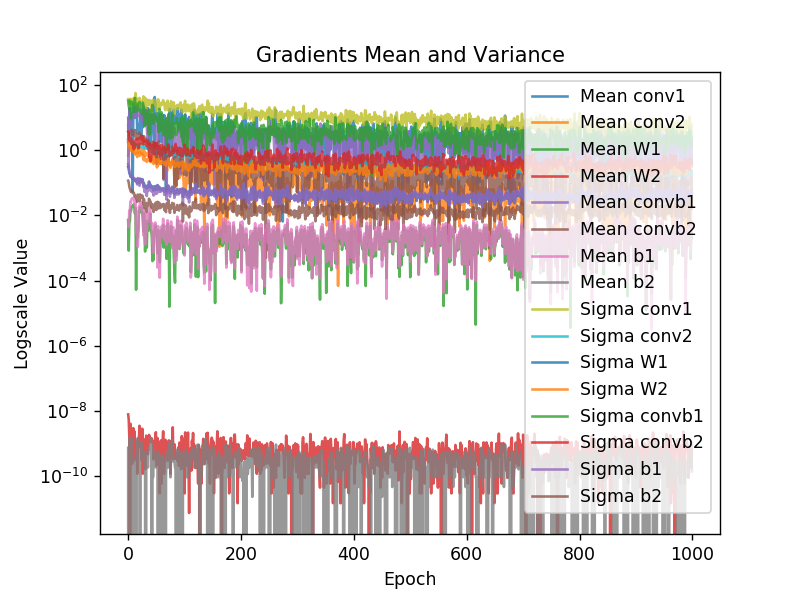

In [93]:
%matplotlib notebook
plot_gradients('results/mean.npy',
               'results/variance.npy',
               legend_names=['conv1', 'conv2', 'W1', 'W2', 'convb1', 'convb2', 'b1', 'b2'],
               save_path='results/meangrad1.png')

<IPython.core.display.Javascript object>


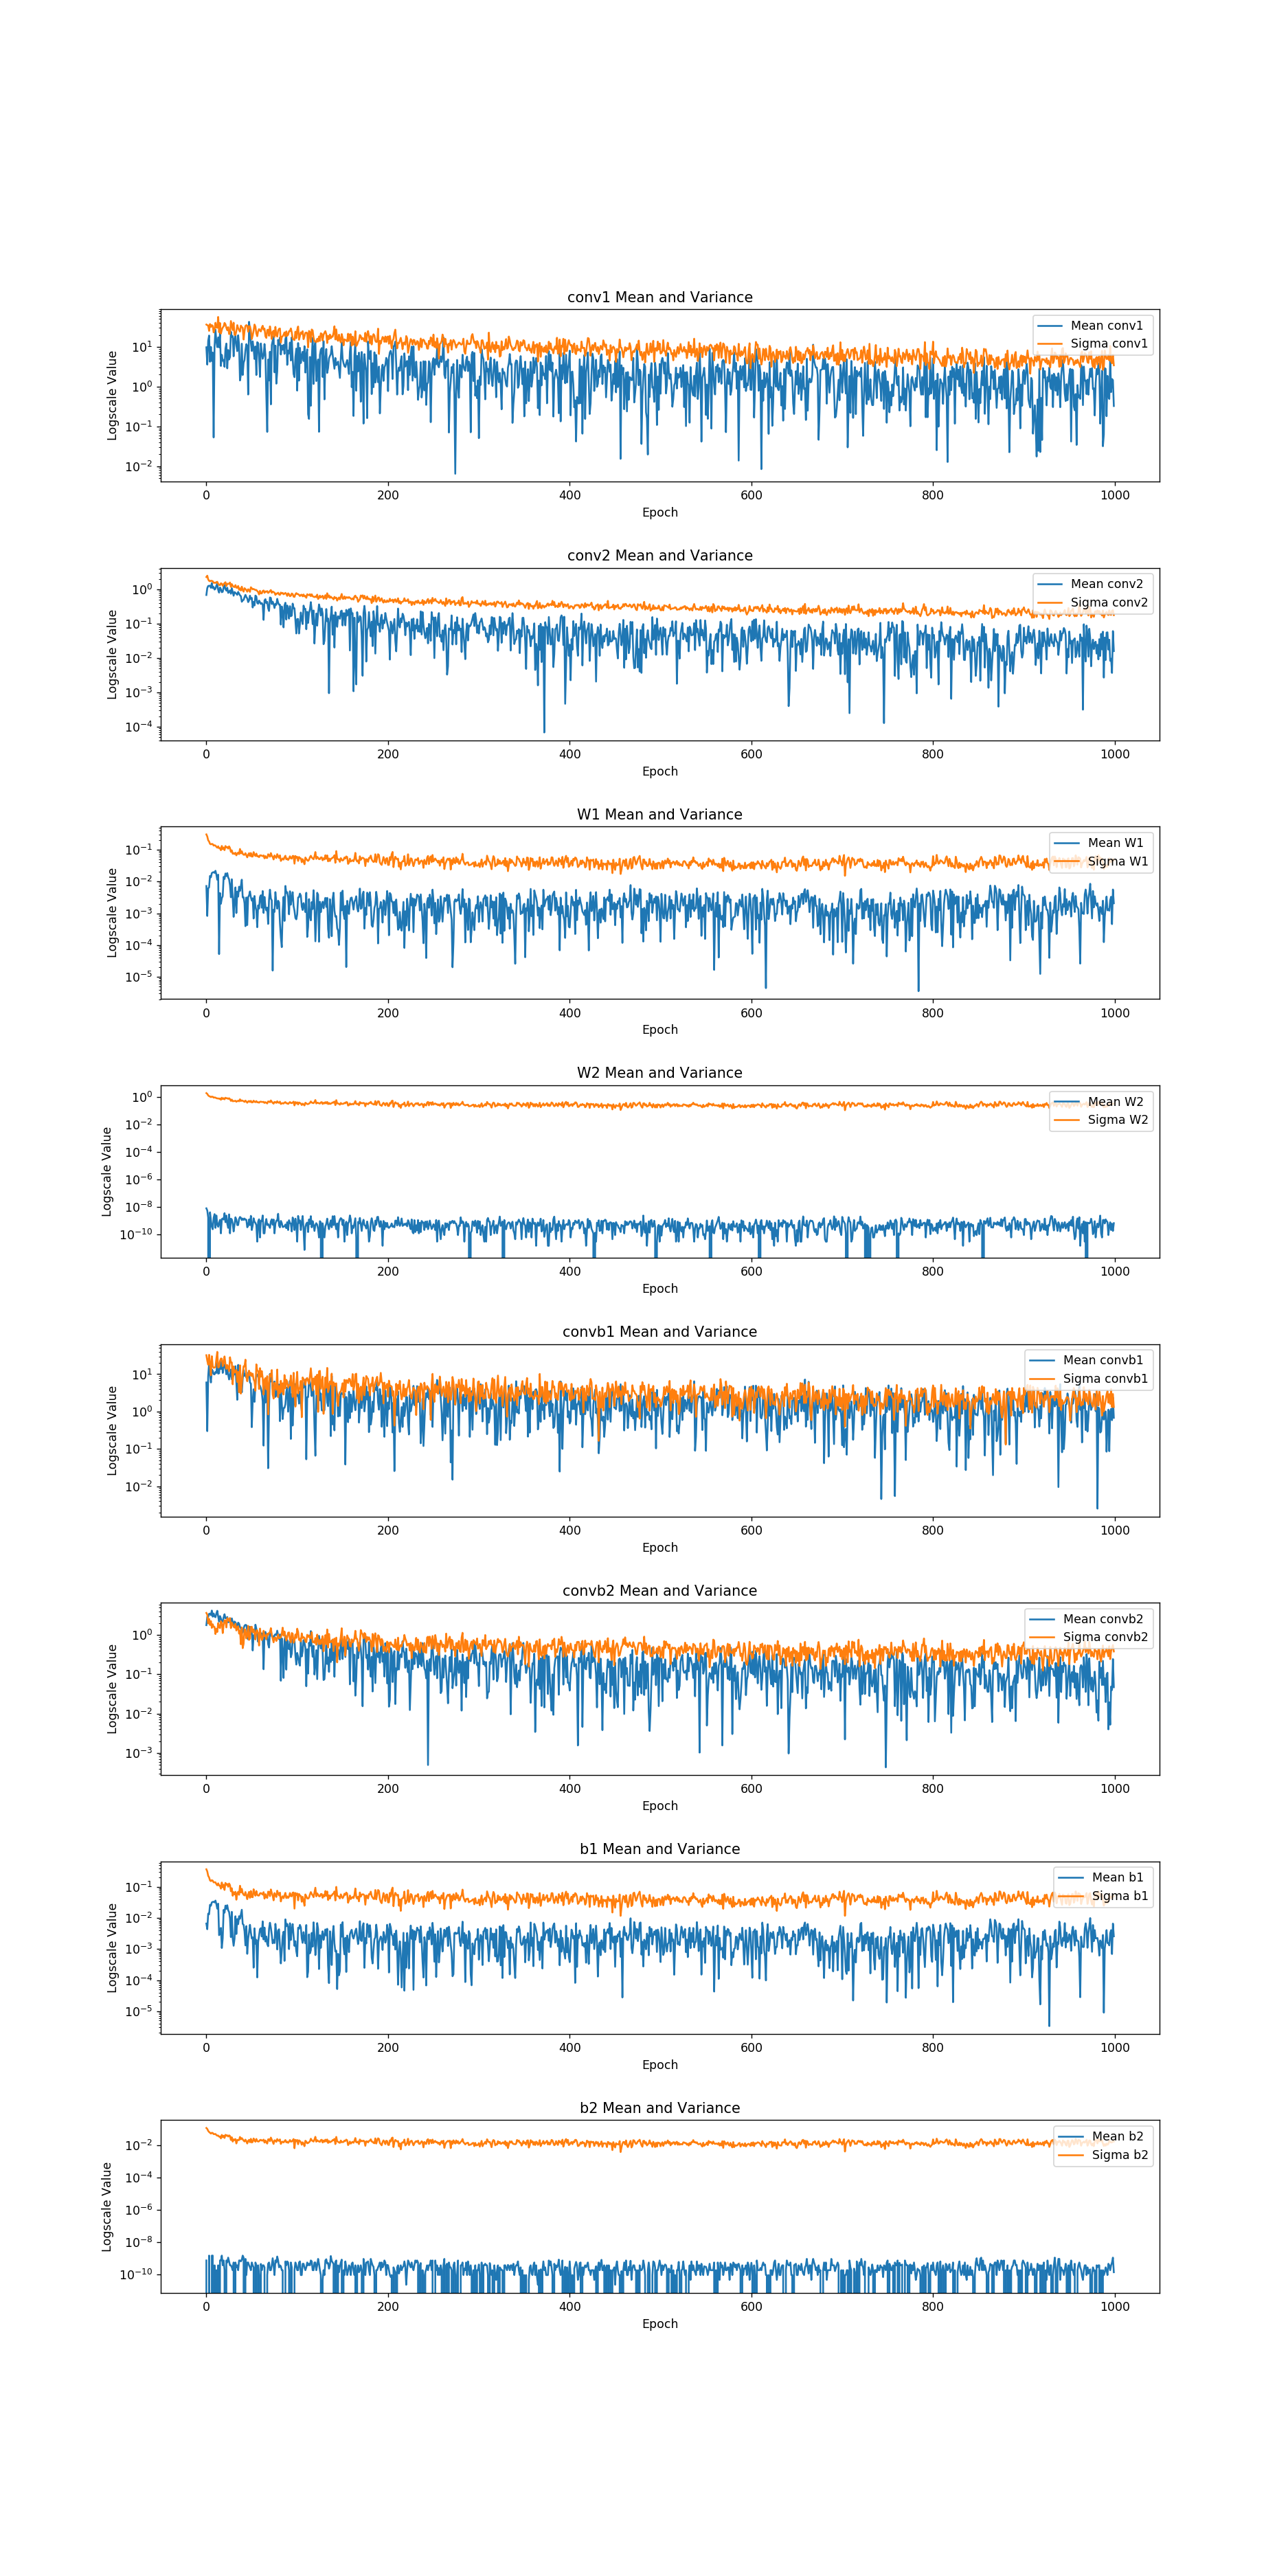

In [94]:
%matplotlib notebook
plot_individual_gradients('results/mean.npy',
                          'results/variance.npy',
                          legend_names=['conv1', 'conv2', 'W1', 'W2', 'convb1', 'convb2', 'b1', 'b2'],
                          save_path='results/meangrad2.png')

In [3]:
def build_idnns_model():
    weights = {
        'W1': tf.Variable(tf.random_normal([12, 10])),
        'W2': tf.Variable(tf.random_normal([10, 7])),
        'W3': tf.Variable(tf.random_normal([7, 5])),
        'W4': tf.Variable(tf.random_normal([5, 4])),
        'W5': tf.Variable(tf.random_normal([4, 3])),
        'W6': tf.Variable(tf.random_normal([3, 2])),
        'b1': tf.Variable(tf.random_normal([10])),
        'b2': tf.Variable(tf.random_normal([7])),
        'b3': tf.Variable(tf.random_normal([5])),
        'b4': tf.Variable(tf.random_normal([4])),
        'b5': tf.Variable(tf.random_normal([3])),
        'b6': tf.Variable(tf.random_normal([2]))
    }
    
    X = tf.placeholder(tf.float32, shape=[None, 12])
    Y = tf.placeholder(tf.float32, shape=[None, 2])
    
    act1 = tf.nn.tanh(tf.matmul(X, weights['W1']) + weights['b1'])
    act2 = tf.nn.tanh(tf.matmul(act1, weights['W2']) + weights['b2'])
    act3 = tf.nn.tanh(tf.matmul(act2, weights['W3']) + weights['b3'])
    act4 = tf.nn.tanh(tf.matmul(act3, weights['W4']) + weights['b4'])
    act5 = tf.nn.tanh(tf.matmul(act4, weights['W5']) + weights['b5'])

    out = tf.matmul(act5, weights['W6']) + weights['b6']
    
    prediction = tf.nn.softmax(out)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=out, labels=Y))
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    gradients = optimizer.compute_gradients(loss,
                                            var_list=[weights['W1'],
                                                      weights['W2'],
                                                      weights['W3'],
                                                      weights['W4'],
                                                      weights['W5'],
                                                      weights['W6'],
                                                      weights['b1'],
                                                      weights['b2'],
                                                      weights['b3'],
                                                      weights['b4'],
                                                      weights['b5'],
                                                      weights['b6']
                                                     ])
    
    train_op = optimizer.apply_gradients(gradients)

    initializer = tf.global_variables_initializer()

    return {
        'X': X,
        'Y': Y,
        'Weights': weights,
        'gradients': [g for (g, v) in gradients],
        'hidden': (act1, act2, act3, act4, act5),
        'loss': loss,
        'predict': prediction,
        'train': train_op,
        'initializer': initializer
    }

In [4]:
# Load IDNNs data
import scipy.io
g1 = scipy.io.loadmat('data/g1.mat')

In [5]:
idnns_model = build_idnns_model()

In [6]:
idnns_Xdata = g1['F']
idnns_Ydata = np.zeros((idnns_Xdata.shape[0], 2), dtype=np.float32)
idnns_Ydata[np.arange(idnns_Xdata.shape[0]), g1['y'].T[:,0]] = 1

In [7]:
idnns_mi_recorder = MI(g1['F'], g1['y'].T, 10)
idnns_mi_recorder.discretize()
idnns_mi_recorder.pre_compute()

In [8]:
sess = tf.Session()
sess.run(idnns_model['initializer'])

<IPython.core.display.Javascript object>


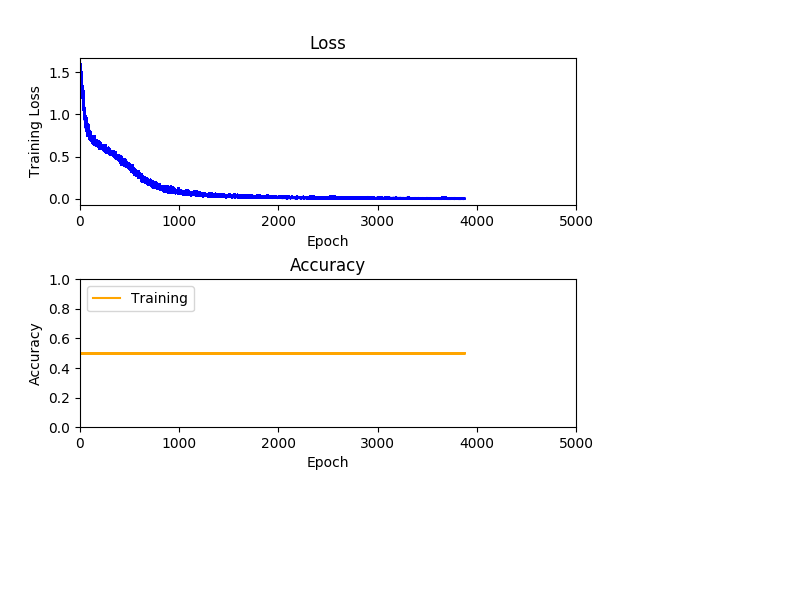

Epoch 0, took GPU time 0.16445152400046936, CPU time 0.33116332900044654
Encoder MI: [1.0122445709400238, 0.9598127189262791, 0.8343319765565176, 0.6999643103889739, 0.5393502467106064]
Decoder MI: [0.08313084164967967, 0.06626642593866061, 0.03938484046200692, 0.021718325916033836, 0.010654871103222111]
Epoch 1, took GPU time 0.0033346600002914784, CPU time 0.1544608040003368
Encoder MI: [1.0138707660574677, 0.9582200742181205, 0.8414995636723888, 0.6830612630226599, 0.5348649956772346]
Decoder MI: [0.0839211839514944, 0.06425111788676954, 0.03380572049842992, 0.01623158001109116, 0.008332566212885993]
Epoch 2, took GPU time 0.002898340999308857, CPU time 0.14421249399947556
Encoder MI: [1.0135323152857103, 0.9505331201763068, 0.8354391188389942, 0.6805627981191119, 0.5279302419656983]
Decoder MI: [0.08357915683709917, 0.0637555936311185, 0.036022399102182356, 0.015592831806617167, 0.008099862904165074]
Epoch 3, took GPU time 0.003080104000218853, CPU time 0.14412843999980396
Encoder 

Epoch 28, took GPU time 0.003391682999790646, CPU time 0.15454731899990293
Encoder MI: [1.0119061201682658, 0.9371052204090831, 0.85246787747026, 0.6864586896157184, 0.6332233859347443]
Decoder MI: [0.08285487327662938, 0.06329695385014854, 0.03406660596410305, 0.016437077202282633, 0.011746706462447644]
Epoch 29, took GPU time 0.002948363000541576, CPU time 0.14969131399993785
Encoder MI: [1.0128554137421946, 0.9315019812978623, 0.8616054049400992, 0.6968743077309894, 0.6355047383904725]
Decoder MI: [0.08357915683709907, 0.061492379499844096, 0.0412072343356873, 0.022685578363009613, 0.01291795402271009]
Epoch 30, took GPU time 0.0029796810003972496, CPU time 0.14413558900014323
Encoder MI: [1.0136600614145592, 0.940247242344816, 0.8571992326252037, 0.6796373937841803, 0.6249432358764377]
Decoder MI: [0.0838568097840206, 0.06288541828949842, 0.038666368755229, 0.017655872380741018, 0.01005376775582768]
Epoch 31, took GPU time 0.0029327840002224548, CPU time 0.14443051600028411
Encoder

Epoch 56, took GPU time 0.0037883619997955975, CPU time 0.14410606300043582
Encoder MI: [1.011840061426921, 0.9204189532990211, 0.8345390155878268, 0.6752091676393688, 0.6448810458820841]
Decoder MI: [0.08356485146654939, 0.05434954397670039, 0.03652368510510721, 0.016669369193068207, 0.009540585018472141]
Epoch 57, took GPU time 0.0028511869995782035, CPU time 0.14406395599962707
Encoder MI: [1.0133216106428007, 0.9225768178572064, 0.8391382242471368, 0.6565352341273226, 0.6241451563460916]
Decoder MI: [0.08329435120490282, 0.05767179817631898, 0.036991295594764516, 0.016175065556625064, 0.0077184646589950005]
Epoch 58, took GPU time 0.002771329999632144, CPU time 0.14305905699984578
Encoder MI: [1.0138707660574675, 0.9187937782436321, 0.829145624136072, 0.6537463031028468, 0.6274588822292642]
Decoder MI: [0.08464815429193391, 0.055961110564769725, 0.03504838822056688, 0.01869677359648988, 0.012807012371229385]
Epoch 59, took GPU time 0.002732939000452461, CPU time 0.14191682999990007

Epoch 84, took GPU time 0.00255339700015611, CPU time 0.14695370600020397
Encoder MI: [1.0128554137421943, 0.8895542937709259, 0.7841956866241206, 0.6108712661741805, 0.5699335274167452]
Decoder MI: [0.08383635393429467, 0.04849316759054038, 0.031594048552751726, 0.01398565094117425, 0.007644254442116812]
Epoch 85, took GPU time 0.0027091390002169646, CPU time 0.14581189900036406
Encoder MI: [1.012178512198679, 0.913082520362057, 0.8087299548218778, 0.6356505603659294, 0.5692011039005889]
Decoder MI: [0.08279596722055933, 0.052838286552748255, 0.027880965863009706, 0.01681465457536912, 0.007562836920187545]
Epoch 86, took GPU time 0.0028535560004456784, CPU time 0.14755046900063462
Encoder MI: [1.0093431598957674, 0.9058797468800953, 0.8106560968309644, 0.6362767724122724, 0.5740518589930759]
Decoder MI: [0.08227899888962938, 0.05038043022896513, 0.028881499722963375, 0.014368112961252627, 0.006883404454608441]
Epoch 87, took GPU time 0.0028039639992130105, CPU time 0.1485716589995718


Epoch 112, took GPU time 0.0026188120000369963, CPU time 0.16466120299992326
Encoder MI: [1.0127107678406304, 0.9036750599579941, 0.787649245629827, 0.6194350824670751, 0.5640507199076757]
Decoder MI: [0.08401416886006746, 0.05011619470112836, 0.02940367823940051, 0.017892450265771256, 0.012042445971039725]
Epoch 113, took GPU time 0.0026979980002579396, CPU time 0.15260065800066513
Encoder MI: [1.0134493567716505, 0.904554301248402, 0.7873719748845914, 0.6195432603883972, 0.5629959251693498]
Decoder MI: [0.08358988586501132, 0.05610036488038788, 0.032280476247744584, 0.018789696708499174, 0.00981002043942151]
Epoch 114, took GPU time 0.002774406999378698, CPU time 0.15494221300014033
Encoder MI: [1.0105452360175782, 0.8895433777679711, 0.7929072733377311, 0.6359948800032232, 0.5701171673987945]
Decoder MI: [0.0842453293527024, 0.053673854019968645, 0.033913656076173915, 0.017200735471890185, 0.013956600181989277]
Epoch 115, took GPU time 0.002741819999755535, CPU time 0.15371094599959

Epoch 140, took GPU time 0.002729214000282809, CPU time 0.1587890350001544
Encoder MI: [1.0123723170688728, 0.9006521423802488, 0.7805149342563208, 0.6100028588034174, 0.5851810169974827]
Decoder MI: [0.08360419123556109, 0.05395514238439506, 0.032676491592357915, 0.018279902337314993, 0.013647725865331998]
Epoch 141, took GPU time 0.0027454979999674833, CPU time 0.15737977099979616
Encoder MI: [1.0116883344617, 0.86635035190502, 0.7447121665411705, 0.6008536578331262, 0.5695425839552748]
Decoder MI: [0.08458020378182277, 0.05200120754943874, 0.027250020052627166, 0.014355521574076772, 0.00995776943598995]
Epoch 142, took GPU time 0.0026954499999192194, CPU time 0.1597814990000188
Encoder MI: [1.0101478075681323, 0.8874635137209935, 0.774213900761319, 0.6056720821920175, 0.5782516378462489]
Decoder MI: [0.08353090818732294, 0.05129894278573836, 0.030281519316338334, 0.014821724490268785, 0.012322368536278838]
Epoch 143, took GPU time 0.00273704400024144, CPU time 0.15840393899998162
En

Epoch 168, took GPU time 0.002707312999518763, CPU time 0.16457986000023084
Encoder MI: [1.0073124552652213, 0.8784333926632112, 0.7468378734226355, 0.5923322569530821, 0.5797102442762957]
Decoder MI: [0.08310938359385509, 0.05180065812794977, 0.03220882230035577, 0.016419942423532334, 0.013580353678968936]
Epoch 169, took GPU time 0.0026400960005048546, CPU time 0.16461918400000286
Encoder MI: [1.0136600614145588, 0.8849104104882274, 0.7633505159355073, 0.6066573669357389, 0.58546696641149]
Decoder MI: [0.0842560583806147, 0.05561536798332249, 0.03369876764095781, 0.018806492258239726, 0.013461564370923794]
Epoch 170, took GPU time 0.004145925000557327, CPU time 0.16808324400062702
Encoder MI: [1.0105523170812345, 0.8830024900564164, 0.7556631961949448, 0.6105210789551018, 0.5847478665708343]
Decoder MI: [0.08388899686775748, 0.05108348302646374, 0.03228662689830021, 0.017245070718198193, 0.01221891176452634]
Epoch 171, took GPU time 0.002780041999358218, CPU time 0.16528667900001892


Epoch 196, took GPU time 0.0038560269995286944, CPU time 0.17179936599950452
Encoder MI: [1.0121785121986788, 0.8682458539659874, 0.7422963169072587, 0.6104736301441939, 0.5771742647166728]
Decoder MI: [0.08354696975336225, 0.044473080174072456, 0.029540313506810363, 0.016059216933787174, 0.010122990696209104]
Epoch 197, took GPU time 0.002661718999661389, CPU time 0.17042938199938362
Encoder MI: [1.0139985121863162, 0.8743047689350086, 0.7365032485264316, 0.6037304003634933, 0.5769385524225639]
Decoder MI: [0.08421314226896563, 0.0477037363791577, 0.02889850974729913, 0.01689392027206759, 0.011816514440092898]
Epoch 198, took GPU time 0.003978731000643165, CPU time 0.1716836540008444
Encoder MI: [1.01353231528571, 0.8916302241294264, 0.7513531856283663, 0.6167504952794168, 0.5822406578737818]
Decoder MI: [0.08397482909105572, 0.05459416727005713, 0.03197250452263629, 0.017048712144729136, 0.011733266255956276]
Epoch 199, took GPU time 0.005415738999545283, CPU time 0.17512301500028116

Epoch 224, took GPU time 0.00432133599952067, CPU time 0.18024558299930504
Encoder MI: [1.0123892168415882, 0.8756019785410356, 0.7419027986526586, 0.6161337011882869, 0.5867457739644243]
Decoder MI: [0.08455516938336075, 0.051978910088016105, 0.03287421537620486, 0.02005751229967551, 0.014936196002161305]
Epoch 225, took GPU time 0.002669806000085373, CPU time 0.17824187699989125
Encoder MI: [1.0133216106428011, 0.8845448324737325, 0.7381987890077352, 0.6145881446523296, 0.5671688501524151]
Decoder MI: [0.08428466912171415, 0.05584410187476033, 0.032366459574283545, 0.021633115399499192, 0.01629061150458403]
Epoch 226, took GPU time 0.0026519650000409456, CPU time 0.1787037539997982
Encoder MI: [1.011923019940981, 0.8699676342638196, 0.728275948578558, 0.6013723014625232, 0.5766334784057697]
Decoder MI: [0.08377197976682096, 0.050966929142170464, 0.027071104996276255, 0.016006762876654083, 0.011529302632720497]
Epoch 227, took GPU time 0.0025756540007932927, CPU time 0.180060654000044

Epoch 252, took GPU time 0.002800787999149179, CPU time 0.18551452299925586
Encoder MI: [1.0123723170688725, 0.8814058436315675, 0.7331310345458525, 0.6184002427822994, 0.5902864238234301]
Decoder MI: [0.08424532935270242, 0.058430058296814066, 0.04154135665528405, 0.02514383532640719, 0.018916692759210048]
Epoch 253, took GPU time 0.0041717490003065905, CPU time 0.18782382100016548
Encoder MI: [1.0129831598710437, 0.8708327001562919, 0.7256654228375247, 0.6185585204036373, 0.5871843261520262]
Decoder MI: [0.0842632110658895, 0.05353291621318506, 0.035970944548230736, 0.022186963718095705, 0.014210279352200003]
Epoch 254, took GPU time 0.002694171999792161, CPU time 0.1865225849996932
Encoder MI: [1.012599921484497, 0.8774909490002748, 0.7224069317135188, 0.6016352984728804, 0.5747592915294081]
Decoder MI: [0.08375767439627128, 0.055897604027069, 0.03338662381419445, 0.020684179524091312, 0.015086558078342919]
Epoch 255, took GPU time 0.0027066129996455857, CPU time 0.18673322699942219

Epoch 279, took GPU time 0.002740621999691939, CPU time 0.1948578900000939
Encoder MI: [1.0143369629580745, 0.8801786213396003, 0.7244308474418008, 0.6144071441272608, 0.5908094740159289]
Decoder MI: [0.08461954355083448, 0.051766315910934245, 0.031770561372906646, 0.022700929651756352, 0.02011336855842901]
Epoch 280, took GPU time 0.002700349000406277, CPU time 0.19551242499983346
Encoder MI: [1.013660061414559, 0.8807359737238846, 0.725602887244743, 0.6173209141607173, 0.5889863865357663]
Decoder MI: [0.08394979469259378, 0.059793224296470784, 0.03861107351076368, 0.03210301005499866, 0.025555505062689565]
Epoch 281, took GPU time 0.0026684290005505318, CPU time 0.1965189239999745
Encoder MI: [1.0129831598710433, 0.8792085563839386, 0.7155785823253663, 0.6114579478759863, 0.5869933915407943]
Decoder MI: [0.08436334865973752, 0.05945419038589313, 0.03724244220759826, 0.027374949702032622, 0.02335914992014049]
Epoch 282, took GPU time 0.002731638999648567, CPU time 0.1952144289998614
E

Epoch 306, took GPU time 0.004088364000381262, CPU time 0.20386424100070144
Encoder MI: [1.0150138645015896, 0.8661056084957038, 0.6987723761407739, 0.642283781393789, 0.598889673206445]
Decoder MI: [0.0845694747539105, 0.060193563066136914, 0.03568572273736146, 0.027468710590594983, 0.023986507543520018]
Epoch 307, took GPU time 0.0030941189997975016, CPU time 0.20358774499982246
Encoder MI: [1.0146754137298317, 0.8804539936044358, 0.7282023952333313, 0.6509128209472407, 0.6041720392875272]
Decoder MI: [0.0845909328097351, 0.05840428434943968, 0.03918497160168034, 0.03205954410552791, 0.026690951821140563]
Epoch 308, took GPU time 0.002724967000176548, CPU time 0.20322464600030798
Encoder MI: [1.013998512186316, 0.885668478095914, 0.7296698724677563, 0.6454059682520362, 0.602654400774591]
Decoder MI: [0.08399271080424293, 0.0598636291098346, 0.036910797263791026, 0.032099061780984865, 0.027647942967321062]
Epoch 309, took GPU time 0.004445482999472006, CPU time 0.20509858100012934
Enc

Epoch 333, took GPU time 0.0030279209995569545, CPU time 0.21133205000023736
Encoder MI: [1.014675413729831, 0.8759722552621652, 0.7057387784074143, 0.6206951648468179, 0.5837719700509516]
Decoder MI: [0.08432043254808844, 0.060651843434477624, 0.04186688756135668, 0.03617837684029799, 0.029762517281919247]
Epoch 334, took GPU time 0.0027546470000743284, CPU time 0.2123252040000807
Encoder MI: [1.0139985121863164, 0.8938351835232432, 0.7175100847245637, 0.627143301235116, 0.5876266898526191]
Decoder MI: [0.08466245966248362, 0.06081777062193489, 0.03665736094146735, 0.03100230728279632, 0.02751771097608963]
Epoch 335, took GPU time 0.004113072000109241, CPU time 0.21414690900019195
Encoder MI: [1.0142092168292256, 0.8870951052065457, 0.7283409381672297, 0.636389764091916, 0.5912474199765024]
Decoder MI: [0.08381847222110754, 0.05863817555109223, 0.036493169823319245, 0.026965933214945868, 0.024574656235901413]
Epoch 336, took GPU time 0.0029179150005802512, CPU time 0.2690595399999438


Epoch 360, took GPU time 0.0028654090001509758, CPU time 0.22136798400060798
Encoder MI: [1.0143369629580747, 0.8727157511338768, 0.7087362735908947, 0.6339988116404534, 0.5676212933773882]
Decoder MI: [0.08428109277907672, 0.06433068129555168, 0.043835335286369154, 0.03738507133160356, 0.03368670011944822]
Epoch 361, took GPU time 0.003950927000005322, CPU time 0.22452194600009534
Encoder MI: [1.0119678075557699, 0.8782401196999595, 0.7154228145247787, 0.6287443493050068, 0.5651177566950435]
Decoder MI: [0.0833970629352895, 0.06135022068656465, 0.03996799434372218, 0.03377446631858738, 0.027970332521653544]
Epoch 362, took GPU time 0.0028881469997941167, CPU time 0.22296397399986745
Encoder MI: [1.0150138645015894, 0.8681542795115735, 0.6933412631667237, 0.6291698155005482, 0.5584481358851181]
Decoder MI: [0.08456589841127306, 0.05634942164637567, 0.03690848378839821, 0.03126090513348303, 0.027502142171181743]
Epoch 363, took GPU time 0.0028215229995112168, CPU time 0.2234575149996089

Epoch 387, took GPU time 0.00245162999999593, CPU time 0.23145294499954616
Encoder MI: [1.010779921496859, 0.8727873749109839, 0.7080146350226434, 0.6417617840139016, 0.55899263675963]
Decoder MI: [0.08359703855028623, 0.06400246293039877, 0.04467598430239036, 0.04136543065408536, 0.03877514690668231]
Epoch 388, took GPU time 0.0028155429999969783, CPU time 0.23181347399986407
Encoder MI: [1.0138707660574675, 0.8469184186688287, 0.6931516830832049, 0.6278283948835165, 0.558207535262875]
Decoder MI: [0.08420956592632822, 0.060261565961277144, 0.04629992524140021, 0.04172453130867881, 0.035970474277932506]
Epoch 389, took GPU time 0.002417017999505333, CPU time 0.23206590199970378
Encoder MI: [1.012306258327528, 0.871792511710045, 0.7116899733329967, 0.6412604104738907, 0.5607109046902657]
Decoder MI: [0.08359703855028626, 0.0631717883892027, 0.044436817342589786, 0.03851778934796914, 0.03159870404969037]
Epoch 390, took GPU time 0.004128685999603476, CPU time 0.23335939400021743
Encoder

Epoch 414, took GPU time 0.0026549809999778518, CPU time 0.2397869839996929
Encoder MI: [1.01501386450159, 0.8897327748698182, 0.7101283834259804, 0.6199590718320032, 0.555925500093032]
Decoder MI: [0.08464815429193394, 0.07124724611985163, 0.053397268798825635, 0.04549676517649263, 0.040008367084449645]
Epoch 415, took GPU time 0.002729806999923312, CPU time 0.24151451299985638
Encoder MI: [1.0143369629580747, 0.8774493322506206, 0.7069671578590829, 0.6171209554238702, 0.5489809901891366]
Decoder MI: [0.08423460032479013, 0.06512094195887898, 0.04375269836346819, 0.04066933660857963, 0.035509019985025723]
Epoch 416, took GPU time 0.002568238000094425, CPU time 0.24011514599988004
Encoder MI: [1.013193864513952, 0.8816943804771504, 0.7071236789377846, 0.6322676321800615, 0.5600398848960334]
Decoder MI: [0.08424175301006497, 0.06719072152455816, 0.04964064706861123, 0.044491019578937266, 0.03980800719485681]
Epoch 417, took GPU time 0.002805149999403511, CPU time 0.24393024399978458
Enc

Epoch 441, took GPU time 0.0027155839998158626, CPU time 0.2532312620005541
Encoder MI: [1.0143369629580739, 0.8701555140817194, 0.7099554494085756, 0.6424969450651226, 0.5679547343535282]
Decoder MI: [0.08430612717753867, 0.062068103900013265, 0.048903351786200096, 0.04604884751627525, 0.04244878307854899]
Epoch 442, took GPU time 0.0027381030004107743, CPU time 0.25700922000032733
Encoder MI: [1.0135323152857099, 0.8804608706044432, 0.709161057621802, 0.6269134955938114, 0.5552896598748813]
Decoder MI: [0.08398198177633065, 0.06850017354546513, 0.05112377822545866, 0.04546881141424052, 0.04119751262123247]
Epoch 443, took GPU time 0.002680540999790537, CPU time 0.2519399889997658
Encoder MI: [1.0131938645139518, 0.8773940536826381, 0.7182649758973502, 0.6425085387350004, 0.5650726142980509]
Decoder MI: [0.0842703637511644, 0.06898436073013485, 0.05287140412289948, 0.04542854168753334, 0.03996125698628525]
Epoch 444, took GPU time 0.002716680999583332, CPU time 0.25075759399987874
Enc

Epoch 468, took GPU time 0.002742689000115206, CPU time 0.26266387600026064
Encoder MI: [1.0139985121863162, 0.8720620009537788, 0.7126532564109155, 0.6355248107659988, 0.5582774707915531]
Decoder MI: [0.08453013498489884, 0.06907242104587805, 0.055692016407851576, 0.050265121297247466, 0.04548854378981482]
Epoch 469, took GPU time 0.002951769999526732, CPU time 0.2635690489996705
Encoder MI: [1.0142092168292258, 0.8754091905680378, 0.7279714728591421, 0.6477474989613548, 0.5603298563213586]
Decoder MI: [0.08459093280973504, 0.06709271836939194, 0.056700539306367606, 0.049785566586440115, 0.047678713457490564]
Epoch 470, took GPU time 0.003991557000517787, CPU time 0.26272015500035195
Encoder MI: [1.0150138645015891, 0.8660961799192947, 0.720798844506263, 0.6335160755488239, 0.5617735963564997]
Decoder MI: [0.08458020378182282, 0.06668555519121704, 0.05318316566276291, 0.05105976650975824, 0.045992839356274524]
Epoch 471, took GPU time 0.0027268149997325963, CPU time 0.2621925780003948

Epoch 495, took GPU time 0.002811431000736775, CPU time 0.27291434800008574
Encoder MI: [1.0150138645015894, 0.8685060975205826, 0.7232594929114876, 0.6383375931320047, 0.5776677532855391]
Decoder MI: [0.08458735646709767, 0.07244664863401297, 0.06323687573067445, 0.05897613838296283, 0.054578847559877665]
Epoch 496, took GPU time 0.002512043999558955, CPU time 0.27136456100015494
Encoder MI: [1.0145476676009832, 0.8910055486491634, 0.7616281404240225, 0.662572609071096, 0.5891068371892246]
Decoder MI: [0.08471968114468241, 0.07000485581647871, 0.05579017460617087, 0.05043639342826791, 0.044066711524245725]
Epoch 497, took GPU time 0.002779782000288833, CPU time 0.27271062599993456
Encoder MI: [1.0150138645015898, 0.8833193560454554, 0.7276019372733884, 0.6621921523231282, 0.5888737657974629]
Decoder MI: [0.08464457794929649, 0.07510214673487889, 0.06507365224662921, 0.05604657366482147, 0.053414734063652144]
Epoch 498, took GPU time 0.0026227510006719967, CPU time 0.27348645700021734


Epoch 522, took GPU time 0.0025506980000500334, CPU time 0.2841383989998576
Encoder MI: [1.0146754137298324, 0.8839443818047316, 0.7369473694108754, 0.6701349141583026, 0.5759358148025534]
Decoder MI: [0.08464100160665902, 0.06875712106587811, 0.05798808976295594, 0.05454819032785429, 0.049628613520546434]
Epoch 523, took GPU time 0.00273267600005056, CPU time 0.28607305999958044
Encoder MI: [1.0146754137298322, 0.8814948460039986, 0.7348682297014554, 0.6678292994492013, 0.5872137444313078]
Decoder MI: [0.08463384892138423, 0.07115517419053385, 0.058473179441514624, 0.056318867121904, 0.05260405196711454]
Epoch 524, took GPU time 0.0028107349999118014, CPU time 0.2870133309997982
Encoder MI: [1.0136600614145588, 0.8784328365997784, 0.7370515723835321, 0.6786342802149667, 0.5904384595017756]
Decoder MI: [0.08382819904292117, 0.07330043907919928, 0.06615150518720395, 0.058142175356555595, 0.05308917333303157]
Epoch 525, took GPU time 0.003916191000826075, CPU time 0.2870258950006246
Enco

Epoch 549, took GPU time 0.0042253560004610335, CPU time 0.2993396430001667
Encoder MI: [1.0139985121863169, 0.8918172420405293, 0.7685267776503526, 0.6788554558954132, 0.5845403546558778]
Decoder MI: [0.08464815429193388, 0.07449245663897733, 0.06615570798228662, 0.05978797786203, 0.054785075511126435]
Epoch 550, took GPU time 0.004075573000591248, CPU time 0.29810347500006174
Encoder MI: [1.0150138645015903, 0.9051306010056628, 0.784302560370712, 0.710453965378845, 0.6149842501524947]
Decoder MI: [0.08464100160665905, 0.07327435631197693, 0.06175014497616791, 0.054238968407516346, 0.050190829235398346]
Epoch 551, took GPU time 0.002815247000398813, CPU time 0.298428518000037
Encoder MI: [1.0150138645015896, 0.8756096500017605, 0.7547261131170355, 0.6748892528688385, 0.5974302412106172]
Decoder MI: [0.08461596720819711, 0.0748138096722604, 0.06546691781293093, 0.05616942779261264, 0.053262583041077935]
Epoch 552, took GPU time 0.004070052999850304, CPU time 0.29930617099944357
Encoder

Epoch 576, took GPU time 0.0027107959995191777, CPU time 0.3106417559993133
Encoder MI: [1.013870766057468, 0.8870621036407336, 0.7862588753996871, 0.7313397805524645, 0.6076495323488795]
Decoder MI: [0.08458378012446018, 0.0751189402775323, 0.06997312836303765, 0.06553786501082433, 0.06092584375057653]
Epoch 577, took GPU time 0.0027788699999291566, CPU time 0.30966287899991585
Encoder MI: [1.0150138645015896, 0.873391789404447, 0.7600652246079459, 0.6950203332673693, 0.595233081019381]
Decoder MI: [0.08424175301006503, 0.07250676440389575, 0.06387414046699681, 0.061242011211556986, 0.05710308838660672]
Epoch 578, took GPU time 0.002543933999731962, CPU time 0.309339966999687
Encoder MI: [1.0150138645015903, 0.8792470716404821, 0.7744060956393998, 0.7078886812170261, 0.6112508444843094]
Decoder MI: [0.08460166183764738, 0.07482026714903026, 0.06880517253244932, 0.06404401933741825, 0.05962389516189257]
Epoch 579, took GPU time 0.0027516529999047634, CPU time 0.3117257399999289
Encoder

Epoch 603, took GPU time 0.0029308090006452403, CPU time 0.32266287299989926
Encoder MI: [1.0153523152733475, 0.876922758235069, 0.7829409772380902, 0.7158241130463804, 0.5954296426235272]
Decoder MI: [0.0845802037818228, 0.07600657571781483, 0.06948578708117525, 0.0675044782142146, 0.060455590110778]
Epoch 604, took GPU time 0.002739760000622482, CPU time 0.3899524080006813
Encoder MI: [1.0150138645015896, 0.8737234414338348, 0.772992569954333, 0.714807206905733, 0.586808211864496]
Decoder MI: [0.08466961234775847, 0.07686735470960386, 0.06905547660130562, 0.06779158445033033, 0.0616349045773299]
Epoch 605, took GPU time 0.0028732359996865853, CPU time 0.3236774319993856
Encoder MI: [1.014675413729832, 0.8731829318857108, 0.7817941851790289, 0.7184686025827851, 0.5895110222411115]
Decoder MI: [0.08433831426127553, 0.07622031301683774, 0.07217945607083344, 0.06878098354224764, 0.06413223933727435]
Epoch 606, took GPU time 0.0026201569999102503, CPU time 0.3236662780000188
Encoder MI: [

Epoch 630, took GPU time 0.0028429579997464316, CPU time 0.337484454999867
Encoder MI: [1.0146754137298328, 0.8637784416856994, 0.7688467827542489, 0.7181847781111139, 0.5661634808258049]
Decoder MI: [0.084641001606659, 0.07653323592990205, 0.07215459978534888, 0.07035087919689395, 0.06505660897779368]
Epoch 631, took GPU time 0.0026342970004407107, CPU time 0.3364714899998944
Encoder MI: [1.0145476676009832, 0.8629881770391439, 0.7647263060989791, 0.696651011732841, 0.5445033506855663]
Decoder MI: [0.08464100160665905, 0.0766203982957021, 0.07425655267524835, 0.07277835275800759, 0.06727033380617631]
Epoch 632, took GPU time 0.0037378560000433936, CPU time 0.33994005099975766
Encoder MI: [1.014064570927661, 0.852110060071799, 0.758405634581333, 0.7011392480458406, 0.5441602286804814]
Decoder MI: [0.08462669623610934, 0.0780471143173059, 0.07494430867218722, 0.07300767469935852, 0.06728579951239934]
Epoch 633, took GPU time 0.0027470609993542894, CPU time 0.33643788599965774
Encoder MI

Epoch 657, took GPU time 0.0027106890001959982, CPU time 0.3472789620000185
Encoder MI: [1.0150138645015898, 0.8426261558818923, 0.7514753078434133, 0.6898121746066506, 0.5373181244787569]
Decoder MI: [0.08459093280973505, 0.08022872137723569, 0.07388369437599358, 0.07538693364083086, 0.0711283231451085]
Epoch 658, took GPU time 0.0027219810008318746, CPU time 0.3575280760005626
Encoder MI: [1.014675413729832, 0.848510498853988, 0.7614014478769455, 0.6923657261877987, 0.5460803888176577]
Decoder MI: [0.08463027257874677, 0.07684048540868652, 0.0759303214455022, 0.07388361348748236, 0.06742913711832459]
Epoch 659, took GPU time 0.0027300210003886605, CPU time 0.3493258019998393
Encoder MI: [1.0146754137298315, 0.85555005835158, 0.7666029077576664, 0.6896234695704031, 0.5419779169842796]
Decoder MI: [0.08460523818028476, 0.0782223780223665, 0.07685062239026873, 0.07492285061636263, 0.07197450958563713]
Epoch 660, took GPU time 0.0039142870000432595, CPU time 0.35234181199939485
Encoder M

Epoch 684, took GPU time 0.004016044999843871, CPU time 0.3655699459995958
Encoder MI: [1.0139985121863169, 0.8433832391279842, 0.7416106156529362, 0.6756494998729294, 0.5288999131192366]
Decoder MI: [0.0842810927790767, 0.07785052811567852, 0.07531744410405197, 0.07508578515324242, 0.07048398242407264]
Epoch 685, took GPU time 0.002796595999825513, CPU time 0.36591670399957366
Encoder MI: [1.0150138645015896, 0.8367186113689306, 0.7489067407920761, 0.6813925844872123, 0.5199968958597021]
Decoder MI: [0.08466245966248355, 0.07957442491390812, 0.07620712974558508, 0.07592248272096955, 0.07166519350728282]
Epoch 686, took GPU time 0.002803644999403332, CPU time 0.3664309409996349
Encoder MI: [1.0143369629580745, 0.8583952518791587, 0.7496778876043838, 0.6887052256106281, 0.5167307693952952]
Decoder MI: [0.0845945091523725, 0.08014231609293626, 0.07882582819867177, 0.0772640966871381, 0.07377456800523956]
Epoch 687, took GPU time 0.0026311139999961597, CPU time 0.36575018799976533
Encoder

Epoch 711, took GPU time 0.0028392869999152026, CPU time 0.3783553210005266
Encoder MI: [1.0153523152733475, 0.849565602255144, 0.7576655633425708, 0.6796386914176239, 0.5247812473050336]
Decoder MI: [0.08464815429193391, 0.07701542762035846, 0.07530434544583427, 0.07343529774150062, 0.06897149776175901]
Epoch 712, took GPU time 0.002591803000541404, CPU time 0.38732393700047396
Encoder MI: [1.0146754137298322, 0.8456179263060415, 0.7384642218353211, 0.6645717548720635, 0.5138550807113099]
Decoder MI: [0.08457662743918534, 0.07739211442156876, 0.07538816693876932, 0.07521822631699947, 0.06607984725792182]
Epoch 713, took GPU time 0.0028560210002979147, CPU time 0.37881637000009505
Encoder MI: [1.0148861183727411, 0.8385825245385845, 0.7365546285970694, 0.6604382725910002, 0.49926407245628274]
Decoder MI: [0.08450510058643683, 0.07911660672008602, 0.07796249227101905, 0.07429218596760184, 0.0710558523031215]
Epoch 714, took GPU time 0.002721797000049264, CPU time 0.38196944700030144
Enc

Epoch 738, took GPU time 0.0026131449994863942, CPU time 0.3950299729995095
Encoder MI: [1.0153523152733477, 0.8205148791964773, 0.7262083455806616, 0.6524478388717936, 0.4910410279801058]
Decoder MI: [0.08461954355083448, 0.08080109812856412, 0.07981418388987019, 0.07939105500924659, 0.07678651884723214]
Epoch 739, took GPU time 0.002754258000095433, CPU time 0.3924171839998962
Encoder MI: [1.0153523152733472, 0.8362584798047938, 0.7358361645970292, 0.6708293472534141, 0.49463069989568836]
Decoder MI: [0.08458020378182274, 0.07925086683844966, 0.07729401726595057, 0.07591110840498687, 0.07131680213165563]
Epoch 740, took GPU time 0.002802824999889708, CPU time 0.3930428829999073
Encoder MI: [1.0143369629580747, 0.8308934402126871, 0.7359626624464679, 0.6539029579954224, 0.4959204374629113]
Decoder MI: [0.08464100160665906, 0.07817590445008403, 0.07785335707225166, 0.07427271950021747, 0.06863831517786866]
Epoch 741, took GPU time 0.0026312579993827967, CPU time 0.39600806799990096
Enc

Epoch 765, took GPU time 0.002702716999920085, CPU time 0.4117229479998059
Encoder MI: [1.0150138645015896, 0.8330986956148152, 0.7529044366707923, 0.6869862409198, 0.5109422464431691]
Decoder MI: [0.08463027257874682, 0.08016345404251386, 0.07968561158387212, 0.0775113294953527, 0.07298867756234952]
Epoch 766, took GPU time 0.002672507999704976, CPU time 0.4123866749996523
Encoder MI: [1.0139985121863162, 0.8339126412033726, 0.7501188689628442, 0.6780587993304601, 0.5204734170111215]
Decoder MI: [0.08410615156254193, 0.07776682377274642, 0.07669561314479059, 0.07645101860347742, 0.07562524217603103]
Epoch 767, took GPU time 0.0029443570001603803, CPU time 0.4128777710002396
Encoder MI: [1.014547667600983, 0.8241646243175653, 0.7369556811699157, 0.6657364678518749, 0.5056383481284955]
Decoder MI: [0.08415334665022793, 0.0759342502965803, 0.0760881152448711, 0.07690852278628234, 0.07224832933818955]
Epoch 768, took GPU time 0.004120127999158285, CPU time 0.4148433839991412
Encoder MI: [

Epoch 792, took GPU time 0.002677121000488114, CPU time 0.4290887269999075
Encoder MI: [1.0150138645015896, 0.823709312615471, 0.7317143814618133, 0.6709959780243183, 0.4966047333904697]
Decoder MI: [0.08458735646709761, 0.07772946108279359, 0.07802808311070539, 0.07686997615429249, 0.07444977220390121]
Epoch 793, took GPU time 0.004402958000355284, CPU time 0.4271423780000987
Encoder MI: [1.0150138645015905, 0.8197754632860801, 0.7123698195916839, 0.6397825431958284, 0.47577523243871245]
Decoder MI: [0.08459093280973506, 0.08018125406782473, 0.08108969496825262, 0.0781852528898684, 0.076094333955619]
Epoch 794, took GPU time 0.0027587759996094974, CPU time 0.42918215400004556
Encoder MI: [1.015352315273347, 0.831407598314413, 0.7215170451770268, 0.6507265410157357, 0.47978239540083917]
Decoder MI: [0.08458020378182285, 0.07762743311782108, 0.07967373058741717, 0.07859893624631556, 0.07717199335428282]
Epoch 795, took GPU time 0.0037204359996394487, CPU time 0.42901586999960273
Encoder

Epoch 819, took GPU time 0.0027903310001420323, CPU time 0.44753510000009555
Encoder MI: [1.0153523152733472, 0.8291424513060713, 0.7395170320204194, 0.6546768543487788, 0.48951318591532]
Decoder MI: [0.08463384892138426, 0.0808746121090914, 0.08199230148866639, 0.08200328955802418, 0.0818028679723136]
Epoch 820, took GPU time 0.0029310800000530435, CPU time 0.44396674600011465
Encoder MI: [1.0148861183727411, 0.8127346036869749, 0.7174936131491707, 0.6327717383623225, 0.47408866000064737]
Decoder MI: [0.08461596720819703, 0.07865092236883288, 0.07993835367608151, 0.07947751824432595, 0.07738244571673447]
Epoch 821, took GPU time 0.0028350619995762827, CPU time 0.4436406969998643
Encoder MI: [1.0153523152733477, 0.8159183304570683, 0.7260046937477357, 0.6468724157436258, 0.4768325456765051]
Decoder MI: [0.08462311989347192, 0.0798187503475177, 0.08088574040894672, 0.08083456701093057, 0.08027760731659135]
Epoch 822, took GPU time 0.0029366049993768684, CPU time 0.4429755629998908
Encod

Epoch 846, took GPU time 0.004214977999254188, CPU time 0.4583938969999508
Encoder MI: [1.0153523152733472, 0.823666402647784, 0.7350524622313158, 0.6449646972563108, 0.47765412875616753]
Decoder MI: [0.0846338489213842, 0.07971321359966564, 0.07937484545644376, 0.08004207659465362, 0.07457823436071036]
Epoch 847, took GPU time 0.004182521000075212, CPU time 0.4612761580001461
Encoder MI: [1.0145476676009832, 0.8154413044912, 0.7151557492424342, 0.6363598595601896, 0.466043475545013]
Decoder MI: [0.0846123908655596, 0.0807198155232778, 0.08124478292069656, 0.08045549467153126, 0.07831131191895525]
Epoch 848, took GPU time 0.00277633799942123, CPU time 0.4595386940000026
Encoder MI: [1.0139985121863162, 0.8019048353685613, 0.7223499435189351, 0.64138328844057, 0.4656674860938328]
Decoder MI: [0.08463742526402167, 0.08091610048312445, 0.08101962262802036, 0.0807047801823732, 0.07859988550933011]
Epoch 849, took GPU time 0.0029772190000585397, CPU time 0.4620667580002191
Encoder MI: [1.01

Epoch 873, took GPU time 0.003916182000466506, CPU time 0.47469546499996795
Encoder MI: [1.0143369629580745, 0.8162793103730726, 0.7143491171467787, 0.6376768182507851, 0.4723324581158059]
Decoder MI: [0.08461954355083447, 0.0791000498750929, 0.0797774674537481, 0.08067702597988498, 0.07717499269525371]
Epoch 874, took GPU time 0.002817460000187566, CPU time 0.47775743799957127
Encoder MI: [1.0150138645015898, 0.7884494221341927, 0.7025915429334838, 0.6218891717106115, 0.4603993589087804]
Decoder MI: [0.08461596720819707, 0.07875794992017798, 0.08052667010502992, 0.0801123418828684, 0.07965782833204854]
Epoch 875, took GPU time 0.002886481000132335, CPU time 0.482840073999796
Encoder MI: [1.0153523152733472, 0.8088991099450417, 0.714408744464472, 0.6431024215796807, 0.48192262939697916]
Decoder MI: [0.08461954355083458, 0.08019616702975088, 0.08041077867836109, 0.08010859127422582, 0.07832438631258623]
Epoch 876, took GPU time 0.0027115550001326483, CPU time 0.4786515129999316
Encoder 

Epoch 900, took GPU time 0.002718099999583501, CPU time 0.4968231909997485
Encoder MI: [1.013870766057468, 0.8046580553775287, 0.7018071676082774, 0.6295732240286537, 0.47890613765919904]
Decoder MI: [0.08457662743918534, 0.0807488276559959, 0.08226644971456878, 0.07979087517139578, 0.07823840925650322]
Epoch 901, took GPU time 0.003950366000026406, CPU time 0.4992779780004639
Encoder MI: [1.01501386450159, 0.7914811583182179, 0.7089833863114549, 0.6203621854300734, 0.46150546106154927]
Decoder MI: [0.08463742526402158, 0.07986362265992107, 0.08109410951756613, 0.08116724932256757, 0.08019714897022237]
Epoch 902, took GPU time 0.004050976000144146, CPU time 0.497610889000498
Encoder MI: [1.0150138645015894, 0.8208965507006091, 0.7103244870036037, 0.6405988419605849, 0.4711467371212036]
Decoder MI: [0.08464815429193394, 0.08228710426766223, 0.08314781272702335, 0.0818932817255564, 0.08032296228985635]
Epoch 903, took GPU time 0.004005391999271524, CPU time 0.4969077969999489
Encoder MI:

Epoch 927, took GPU time 0.0027632680003080168, CPU time 0.5125777610001023
Encoder MI: [1.014547667600983, 0.8142336837187834, 0.7196911685219904, 0.6437132931233631, 0.47658041964127884]
Decoder MI: [0.08464815429193388, 0.08073257849655978, 0.0805948441450933, 0.08219333066575321, 0.08036942367241408]
Epoch 928, took GPU time 0.0029520710004362627, CPU time 0.5144628260004538
Encoder MI: [1.0153523152733472, 0.8110120404038038, 0.7053226315733415, 0.6215214604404944, 0.4541552898653147]
Decoder MI: [0.08457662743918533, 0.08274954638789088, 0.08364423363797177, 0.08263797681574139, 0.08116786812253246]
Epoch 929, took GPU time 0.002769442999124294, CPU time 0.5130916139996771
Encoder MI: [1.015352315273348, 0.8144194804501197, 0.7005612922696536, 0.6336894743416024, 0.46928147371894874]
Decoder MI: [0.08459450915237249, 0.08131813808111234, 0.08182723002019238, 0.08240817055090331, 0.0806410572923073]
Epoch 930, took GPU time 0.0027463679998618318, CPU time 0.5154633599995577
Encode

Epoch 954, took GPU time 0.004097447000276588, CPU time 0.5299609040002906
Encoder MI: [1.0153523152733477, 0.7999384956014642, 0.7020413546020634, 0.6312854425610289, 0.4666411880573237]
Decoder MI: [0.08453728767017368, 0.08223981760972064, 0.08204038613901994, 0.08108231845489723, 0.07980596364299748]
Epoch 955, took GPU time 0.0028969079994567437, CPU time 0.5309047089995147
Encoder MI: [1.0150138645015896, 0.7987473942836743, 0.6986021471387992, 0.6198226985508474, 0.4638979822236515]
Decoder MI: [0.08458020378182281, 0.08043722656752672, 0.08097175799030186, 0.08017012211915667, 0.07836786350990929]
Epoch 956, took GPU time 0.002494845000001078, CPU time 0.530515158999151
Encoder MI: [1.0146754137298324, 0.8086582139861891, 0.7144877195063085, 0.6452571800222349, 0.47731527137272634]
Decoder MI: [0.08461596720819707, 0.08175543677302793, 0.08134821755010961, 0.0832004767336615, 0.07964550640769676]
Epoch 957, took GPU time 0.0027181510004083975, CPU time 0.537779144000524
Encoder

Epoch 981, took GPU time 0.0027923260004172334, CPU time 0.5473497920002046
Encoder MI: [1.0150138645015898, 0.8087467671880597, 0.7065130556767242, 0.6236331834871123, 0.46050800085834726]
Decoder MI: [0.08466961234775844, 0.08033234216371572, 0.08090851089473741, 0.08049735673053104, 0.07872060400816543]
Epoch 982, took GPU time 0.003955295000196202, CPU time 0.5519110040004307
Encoder MI: [1.0153523152733475, 0.8070912784470994, 0.7179860806912135, 0.6317491595922433, 0.4641477105038748]
Decoder MI: [0.08463384892138422, 0.07967821675834912, 0.08204146045729603, 0.08112159507495702, 0.0801935726275849]
Epoch 983, took GPU time 0.002674450000085926, CPU time 0.5472174839997024
Encoder MI: [1.0153523152733475, 0.8099621714240184, 0.7038536862296823, 0.6275448372174676, 0.4647844358871184]
Decoder MI: [0.08457305109654796, 0.08138508589456571, 0.0823485415958071, 0.08160995266478759, 0.0804792129290529]
Epoch 984, took GPU time 0.0026720030000433326, CPU time 0.5483886570000323
Encoder

Epoch 1008, took GPU time 0.0027366029999029706, CPU time 0.5702983009996387
Encoder MI: [1.0150138645015896, 0.8125720564463463, 0.6952332523482682, 0.6140345922734971, 0.44624533634515806]
Decoder MI: [0.08458378012446026, 0.08011614801923801, 0.08152862768559667, 0.08184048182865186, 0.08144034366939014]
Epoch 1009, took GPU time 0.0026091629997608834, CPU time 0.5711295889996109
Encoder MI: [1.0153523152733472, 0.8010875758393529, 0.7023821137586256, 0.625093877905126, 0.44696395419010476]
Decoder MI: [0.08462669623610931, 0.08094578504171156, 0.08235195176536222, 0.08172528519185285, 0.08096271542446147]
Epoch 1010, took GPU time 0.004019617999801994, CPU time 0.5701543790000869
Encoder MI: [1.0150138645015896, 0.7922560954591249, 0.6808516852706091, 0.6024569624641781, 0.44650524207307085]
Decoder MI: [0.08454801669808597, 0.08304566070378905, 0.0832771721251145, 0.08186401080926604, 0.08180004136582512]
Epoch 1011, took GPU time 0.0027441769998404197, CPU time 0.5710452869998335

Epoch 1035, took GPU time 0.002715380000154255, CPU time 0.5917445089999092
Encoder MI: [1.0153523152733472, 0.800564836594228, 0.6929648860073979, 0.6121508390238739, 0.4430999602564835]
Decoder MI: [0.08462311989347189, 0.08237900091020053, 0.08265847400426968, 0.08314157067759152, 0.08191551371940899]
Epoch 1036, took GPU time 0.004103372999452404, CPU time 0.5936029109998344
Encoder MI: [1.0153523152733477, 0.8042752618035217, 0.698688540366341, 0.6204086059263352, 0.45412478137370854]
Decoder MI: [0.08462311989347188, 0.08001472043441246, 0.08166002146171158, 0.08113215392272362, 0.08037976829998736]
Epoch 1037, took GPU time 0.0027767850006057415, CPU time 0.5981036310004129
Encoder MI: [1.0150138645015896, 0.7931252859393201, 0.6951175389141154, 0.6269113372592526, 0.4567246058273669]
Decoder MI: [0.08464100160665906, 0.0793136728288925, 0.08083945595710379, 0.08185043691853601, 0.08008302882535906]
Epoch 1038, took GPU time 0.002633957000398368, CPU time 0.5957661910006209
Enco

Epoch 1062, took GPU time 0.002694204000363243, CPU time 0.6143165829998907
Encoder MI: [1.0146754137298317, 0.7850434185144347, 0.672053369240619, 0.5973101352064732, 0.4443613930382797]
Decoder MI: [0.0846266962361094, 0.08139511277963773, 0.08248514524942872, 0.08240655808920948, 0.082806696248471]
Epoch 1063, took GPU time 0.002679705999980797, CPU time 0.6163046609999583
Encoder MI: [1.0150138645015896, 0.7885843830222912, 0.6793256045773185, 0.6037633502755849, 0.44784472635011957]
Decoder MI: [0.08456947475391047, 0.08134771000649767, 0.08340239547341606, 0.0824727113820183, 0.08294327963646587]
Epoch 1064, took GPU time 0.002733739000177593, CPU time 0.6160629290006909
Encoder MI: [1.0153523152733472, 0.8117930856315845, 0.7074450142005609, 0.6239450064769329, 0.4407141934941606]
Decoder MI: [0.08468749406094567, 0.08179365636407247, 0.08339974971525893, 0.08299524020215616, 0.08259781175270987]
Epoch 1065, took GPU time 0.0028315859999565873, CPU time 0.6217573490002906
Encode

Epoch 1089, took GPU time 0.003994523999608646, CPU time 0.6396492809999472
Encoder MI: [1.0153523152733475, 0.7879823472204415, 0.6907681196928107, 0.6194439753690476, 0.45786180175761815]
Decoder MI: [0.08462669623610937, 0.08236226563125645, 0.08280669624847115, 0.08276190863368257, 0.0819993388662912]
Epoch 1090, took GPU time 0.002820992999659211, CPU time 0.6392124789999798
Encoder MI: [1.0146754137298317, 0.7908501079688371, 0.6866627938769931, 0.6172910572126522, 0.45285931601461804]
Decoder MI: [0.0846123908655596, 0.08084825693255558, 0.08245394010616373, 0.08249872772095214, 0.08171535117514411]
Epoch 1091, took GPU time 0.002773614999568963, CPU time 0.6487178509996738
Encoder MI: [1.0148861183727411, 0.7954477088434725, 0.6936152553480515, 0.614412095119623, 0.45373272310613244]
Decoder MI: [0.08460881452292221, 0.07983545218404717, 0.08132853644596057, 0.08151796996231313, 0.08006285412535659]
Epoch 1092, took GPU time 0.00398762899931171, CPU time 0.6430306960000962
Enco

Epoch 1116, took GPU time 0.002582634000646067, CPU time 0.6630880669999897
Encoder MI: [1.0153523152733472, 0.8083715063104123, 0.6940407533157849, 0.6300290689554844, 0.4468505396002387]
Decoder MI: [0.08461596720819711, 0.08242543649817614, 0.08427751643643883, 0.08381131953583225, 0.0830727306048127]
Epoch 1117, took GPU time 0.004249652999533282, CPU time 0.6688851339995381
Encoder MI: [1.0136600614145588, 0.7951195018261143, 0.6920967152192226, 0.6222126960813207, 0.4421643908149093]
Decoder MI: [0.0843311615760007, 0.08241910758125938, 0.08352651390363584, 0.08365426003248463, 0.08284961236012008]
Epoch 1118, took GPU time 0.003973918999690795, CPU time 0.6650760699994862
Encoder MI: [1.0150138645015898, 0.8065361697545942, 0.6867440869346424, 0.6271027115853316, 0.4381361536172587]
Decoder MI: [0.08460166183764734, 0.08244321107825155, 0.08276476207729387, 0.08379701416528254, 0.08207096076106277]
Epoch 1119, took GPU time 0.0026263660001859535, CPU time 0.6668680020002284
Enco

Epoch 1143, took GPU time 0.0027818519993161317, CPU time 0.692479223999726
Encoder MI: [1.0153523152733472, 0.7957583167437309, 0.6822250708481002, 0.6258131633839712, 0.44954955248557127]
Decoder MI: [0.08460881452292225, 0.08303521129993875, 0.08346571607879961, 0.08306557791953796, 0.08253131559523989]
Epoch 1144, took GPU time 0.004192297000372491, CPU time 0.6914202180005304
Encoder MI: [1.0153523152733475, 0.7847669005837695, 0.6644013603076001, 0.6073808803050875, 0.4445940904887918]
Decoder MI: [0.0845945091523725, 0.08201027775331753, 0.08298521380764332, 0.08343451093553456, 0.08336845219418945]
Epoch 1145, took GPU time 0.0027552820001801592, CPU time 0.6919674310001938
Encoder MI: [1.0139985121863166, 0.7802921941649694, 0.6811558195334703, 0.6337577077776163, 0.440577343656128]
Decoder MI: [0.08456947475391047, 0.08245482149429331, 0.08274947476627235, 0.08321567166687892, 0.08328173040822363]
Epoch 1146, took GPU time 0.004087332000381139, CPU time 0.6926515519999157
Enc

Epoch 1170, took GPU time 0.0027343709998604027, CPU time 0.7150706729999001
Encoder MI: [1.0153523152733477, 0.8142110818245347, 0.6789006990552776, 0.6161246080541973, 0.42417274666843474]
Decoder MI: [0.08464815429193391, 0.08280026646222273, 0.08371576049072035, 0.08350505584781129, 0.08397125274841769]
Epoch 1171, took GPU time 0.0028403209998941747, CPU time 0.7166602540000895
Encoder MI: [1.0150138645015896, 0.8132621331123187, 0.685178261838298, 0.6181612299403513, 0.43149862248004767]
Decoder MI: [0.08460523818028484, 0.08378369073520482, 0.08426678740852654, 0.08380059050791992, 0.08358988586501079]
Epoch 1172, took GPU time 0.002872535999813408, CPU time 0.7181020819998594
Encoder MI: [1.0150138645015896, 0.788199114412803, 0.6645266325373504, 0.6137589730014917, 0.4401245176380882]
Decoder MI: [0.08454444035544852, 0.08208297207816438, 0.08164302931119209, 0.08314584965362831, 0.07998357776648228]
Epoch 1173, took GPU time 0.00399592899975687, CPU time 0.719097660999978
Enc

Epoch 1197, took GPU time 0.002693682999961311, CPU time 0.7370387869996193
Encoder MI: [1.0153523152733477, 0.7860815773558161, 0.6574909315982707, 0.6077370371853639, 0.430151137958342]
Decoder MI: [0.0845086769290743, 0.08096434313202211, 0.08213952152676922, 0.08294416919913354, 0.08200469433426372]
Epoch 1198, took GPU time 0.002674145999662869, CPU time 0.7386909429997104
Encoder MI: [1.0150138645015894, 0.8125932914847965, 0.6879420863971712, 0.6118470815702259, 0.43152746456435076]
Decoder MI: [0.08468749406094563, 0.08298815913849983, 0.08422129716033858, 0.0846874940609451, 0.08388284638858065]
Epoch 1199, took GPU time 0.0026758630001495476, CPU time 0.7390896169999905
Encoder MI: [1.0150138645015894, 0.7860529132826435, 0.6649488077679655, 0.6026088073248945, 0.4244939409922955]
Decoder MI: [0.08452655864226138, 0.08199757716048267, 0.08359416484104781, 0.08418810787050307, 0.08452655864226069]
Epoch 1200, took GPU time 0.0028462450000006356, CPU time 0.7409018739999738
Enc

Epoch 1224, took GPU time 0.004356551999990188, CPU time 0.7656909329998598
Encoder MI: [1.014675413729832, 0.7964702903470474, 0.6695689708148583, 0.596872023349444, 0.4315961121809984]
Decoder MI: [0.08460166183764738, 0.08268960784290612, 0.08371405565122227, 0.08392476029413132, 0.08305405388042189]
Epoch 1225, took GPU time 0.004011684000033711, CPU time 0.7662097539996466
Encoder MI: [1.0146754137298322, 0.7851616711055348, 0.6725976887352324, 0.6089611388231888, 0.42886340540578194]
Decoder MI: [0.08459450915237249, 0.08308897910012045, 0.08332366457940113, 0.0842560583806142, 0.08357915683709849]
Epoch 1226, took GPU time 0.003038110000488814, CPU time 0.7669279150004513
Encoder MI: [1.0145476676009832, 0.8014603109050428, 0.6665569734222768, 0.604775952269321, 0.43093167439344426]
Decoder MI: [0.0845658984112731, 0.08321209532424162, 0.08374435096619298, 0.083888996867757, 0.08183886562798792]
Epoch 1227, took GPU time 0.004226238000228477, CPU time 0.766246152000349
Encoder M

Epoch 1251, took GPU time 0.0028699550002784235, CPU time 0.7909657710006286
Encoder MI: [1.0146754137298317, 0.7958209091057453, 0.6755616811936824, 0.6126932971799639, 0.4485089585097553]
Decoder MI: [0.08460523818028479, 0.0823408075754319, 0.08390435580039687, 0.0832514350932531, 0.08346213973616197]
Epoch 1252, took GPU time 0.002749454999502632, CPU time 0.7917320440001276
Encoder MI: [1.015352315273348, 0.7896439789396533, 0.6738498928534993, 0.5999829610237464, 0.4261138537904115]
Decoder MI: [0.08462669623610934, 0.08139592991313821, 0.08200641992994788, 0.084288245464351, 0.08369430243489553]
Epoch 1253, took GPU time 0.0042682370003603864, CPU time 0.7927181349996317
Encoder MI: [1.0136600614145592, 0.792415858843712, 0.6854529765701602, 0.615086810815855, 0.443927496902922]
Decoder MI: [0.08428824546435157, 0.08203267406358244, 0.0838220485637445, 0.08293444237731991, 0.08340501063176738]
Epoch 1254, took GPU time 0.0026928360002784757, CPU time 0.7918243799995253
Encoder M

Epoch 1278, took GPU time 0.002903253999647859, CPU time 0.8173260379999192
Encoder MI: [1.0146754137298324, 0.7981763897569069, 0.6563110528608521, 0.5681584235466002, 0.4133669118790432]
Decoder MI: [0.08457662743918537, 0.08219837654383755, 0.08368902125276025, 0.08423817666742704, 0.08457662743918466]
Epoch 1279, took GPU time 0.004098145000170916, CPU time 0.8182045760004257
Encoder MI: [1.0150138645015891, 0.7768124584516207, 0.6795552637073439, 0.599278959811165, 0.4434657322101994]
Decoder MI: [0.084623119893472, 0.0818200267864748, 0.0829068851983107, 0.08428466912171359, 0.08280311990583358]
Epoch 1280, took GPU time 0.004414041000018187, CPU time 0.8189159120001932
Encoder MI: [1.0153523152733475, 0.7920238962597616, 0.6777296029263399, 0.611808312004229, 0.4453728524564411]
Decoder MI: [0.0845122532717117, 0.08228572934158454, 0.08290295792698253, 0.08404605637110464, 0.08349690095643766]
Epoch 1281, took GPU time 0.00266409100004239, CPU time 0.818173096999999
Encoder MI: 

Epoch 1305, took GPU time 0.0026750510005513206, CPU time 0.8443483620003462
Encoder MI: [1.0145476676009826, 0.7966708461793202, 0.6680390702419478, 0.5754749000474731, 0.4265778598467628]
Decoder MI: [0.08459808549500993, 0.08246361557198596, 0.08271639811986796, 0.08345498705088729, 0.08278907357672945]
Epoch 1306, took GPU time 0.0028280610004003393, CPU time 0.8457488610001747
Encoder MI: [1.014547667600983, 0.7976620988928151, 0.6780049078262147, 0.5921553785169651, 0.4388279619595524]
Decoder MI: [0.08462669623610942, 0.0824361655260884, 0.08272373773441097, 0.08428824546435106, 0.08369430243489555]
Epoch 1307, took GPU time 0.0027924579999307753, CPU time 0.8465767190000406
Encoder MI: [1.014675413729832, 0.7790490521844505, 0.6573397212223862, 0.5732896422901379, 0.42039649497985965]
Decoder MI: [0.08458735646709764, 0.08323355338006619, 0.0837827087947328, 0.08458735646709711, 0.08376580902201732]
Epoch 1308, took GPU time 0.0027773889996751677, CPU time 0.8547399899998709
En

Epoch 1332, took GPU time 0.002781784999569936, CPU time 0.8731211960002838
Encoder MI: [1.015352315273348, 0.7921100780117809, 0.6807171109884644, 0.5814318163378054, 0.4341052286201051]
Decoder MI: [0.08465530697720872, 0.08247287538144114, 0.08370601340327986, 0.08385065930484391, 0.08385065930484378]
Epoch 1333, took GPU time 0.0041373270005351515, CPU time 0.8736836860007315
Encoder MI: [1.0153523152733475, 0.7913870157631824, 0.6689959364189685, 0.5937315173678948, 0.426375933619043]
Decoder MI: [0.08457662743918541, 0.08224835264596762, 0.0840274720245181, 0.08457662743918481, 0.08423817666742689]
Epoch 1334, took GPU time 0.004411851000440947, CPU time 0.8753159040006722
Encoder MI: [1.0150138645015896, 0.7867698182941605, 0.6666662086943923, 0.5772692586024345, 0.4309034823572058]
Decoder MI: [0.0845980854950099, 0.08249930769373143, 0.08358273317973604, 0.08366569169379623, 0.0842596347232515]
Epoch 1335, took GPU time 0.003999407999799587, CPU time 0.8786104780001551
Encoder

Epoch 1359, took GPU time 0.004004604999863659, CPU time 0.9001683209999101
Encoder MI: [1.0153523152733475, 0.7967968038191281, 0.6619103605769847, 0.5695825262610108, 0.4199523450774108]
Decoder MI: [0.08460166183764734, 0.08241923024187969, 0.08378011439256718, 0.0837970141652825, 0.08231216056601093]
Epoch 1360, took GPU time 0.0027224959994782694, CPU time 0.9016436789997897
Encoder MI: [1.0150138645015898, 0.8130334850568964, 0.6781775804692104, 0.5853729163369253, 0.439293077664369]
Decoder MI: [0.0845837801244602, 0.0830814241301633, 0.08458378012445973, 0.08458378012445969, 0.08369617393803498]
Epoch 1361, took GPU time 0.0028265609998925356, CPU time 0.9023462429995561
Encoder MI: [1.015352315273347, 0.8055306490340985, 0.6963603201030907, 0.5870541357487074, 0.42209284968508787]
Decoder MI: [0.0847053757741328, 0.08357917710272567, 0.08390072810176799, 0.08470537577413226, 0.0824582751553459]
Epoch 1362, took GPU time 0.0027417460005381145, CPU time 0.9065824640001665
Encode

Epoch 1386, took GPU time 0.0027671570005622925, CPU time 0.9281452280001758
Encoder MI: [1.0150138645015894, 0.799331111905094, 0.6717938839362049, 0.5742404438832696, 0.4307378857104857]
Decoder MI: [0.08459808549500995, 0.081667246259164, 0.08230480754310866, 0.08379343782264505, 0.08366569169379617]
Epoch 1387, took GPU time 0.002816134000568127, CPU time 0.9302861010000925
Encoder MI: [1.0142092168292258, 0.810271928547312, 0.6746222887422687, 0.5640145752059283, 0.4174239185192271]
Decoder MI: [0.08467318869039585, 0.08316375163244247, 0.08420699178978884, 0.08467318869039535, 0.08467318869039524]
Epoch 1388, took GPU time 0.0028579600002558436, CPU time 0.9297985679995691
Encoder MI: [1.0153523152733475, 0.7926601993300425, 0.6629777005642433, 0.5711969817674236, 0.420645043339046]
Decoder MI: [0.0845766274391853, 0.08387574505929767, 0.08457662743918484, 0.08457662743918486, 0.08423817666742692]
Epoch 1389, took GPU time 0.0028044979999322095, CPU time 0.9309026600003563
Encode

Epoch 1413, took GPU time 0.0038754630004405044, CPU time 0.9631725520002874
Encoder MI: [1.0143369629580739, 0.7809676331838059, 0.6530107989554751, 0.5603963785015239, 0.41486528299637526]
Decoder MI: [0.08455516938336079, 0.08305672039476522, 0.08421671861160257, 0.08421671861160243, 0.08233876872969584]
Epoch 1414, took GPU time 0.005532426999707241, CPU time 0.9641160470000614
Encoder MI: [1.0150138645015898, 0.8041097542546642, 0.6702263030858983, 0.5706432958544971, 0.41363823838530106]
Decoder MI: [0.08457305109654789, 0.08347474026721402, 0.08423460032478963, 0.08410685419594084, 0.08457305109654722]
Epoch 1415, took GPU time 0.0027964330001850612, CPU time 0.959539321000193
Encoder MI: [1.0150138645015894, 0.8056646269616204, 0.6747866608040274, 0.566139174911754, 0.422746856747664]
Decoder MI: [0.08468391771830822, 0.08179250462839986, 0.08368546517574965, 0.08434546694654989, 0.08341059436781041]
Epoch 1416, took GPU time 0.003993496000475716, CPU time 0.9637491940002292
En

Epoch 1440, took GPU time 0.004497337999964657, CPU time 0.9892322200003036
Encoder MI: [1.0146754137298324, 0.8011053484549249, 0.6711935372655317, 0.5604445732286552, 0.4150318822198189]
Decoder MI: [0.08463027257874675, 0.08165590097477808, 0.0838087251336666, 0.08382562490638196, 0.08348717413462398]
Epoch 1441, took GPU time 0.002757977999863215, CPU time 0.987462306999987
Encoder MI: [1.0153523152733477, 0.787642799408319, 0.6712558005401286, 0.5683852979203462, 0.4173829667530814]
Decoder MI: [0.08463384892138416, 0.08314521864184739, 0.08361849660611036, 0.08395694737786816, 0.08361849660611019]
Epoch 1442, took GPU time 0.00289716400038742, CPU time 0.9889523130004818
Encoder MI: [1.0153523152733475, 0.8032501098881755, 0.6788571782869084, 0.5642200565236971, 0.4220767804173941]
Decoder MI: [0.08467318869039585, 0.08316375163244245, 0.08433473791863769, 0.08467318869039542, 0.08433473791863742]
Epoch 1443, took GPU time 0.0028298469997025677, CPU time 0.9896687169994038
Encode

Epoch 1467, took GPU time 0.002655451999999059, CPU time 1.0167672580000726
Encoder MI: [1.01501386450159, 0.7769818803400552, 0.668081596602806, 0.5590288362942555, 0.4255141143291209]
Decoder MI: [0.08460166183764728, 0.08098514774056878, 0.08337997623330555, 0.08399081903547621, 0.08426321106588892]
Epoch 1468, took GPU time 0.002780097000140813, CPU time 1.0210047770005986
Encoder MI: [1.013660061414559, 0.7656004482102979, 0.6646885326421894, 0.5611023710667326, 0.42247293717348755]
Decoder MI: [0.08459808549500995, 0.08302448227202644, 0.0845980854950094, 0.08459808549500937, 0.08459808549500925]
Epoch 1469, took GPU time 0.002816925999468367, CPU time 1.019326992999595
Encoder MI: [1.0139985121863166, 0.801662849929669, 0.6705469009920213, 0.5629052895655349, 0.42305532370873583]
Decoder MI: [0.08432758523336323, 0.0829057089756004, 0.08384448856004091, 0.08398913446160498, 0.08432758523336262]
Epoch 1470, took GPU time 0.0028360829992379877, CPU time 1.0187369559998842
Encoder 

Epoch 1494, took GPU time 0.004199121999590716, CPU time 1.047527457999422
Encoder MI: [1.014886118372741, 0.8012488020118631, 0.6714654234862397, 0.5630752936332291, 0.42148408823067474]
Decoder MI: [0.08453371132753623, 0.0821645559252314, 0.08313512062571614, 0.08419526055577795, 0.08453371132753557]
Epoch 1495, took GPU time 0.002862508999896818, CPU time 1.142249258999982
Encoder MI: [1.0153523152733475, 0.7952997490783511, 0.6677975509503498, 0.5499984341538661, 0.4173539898511918]
Decoder MI: [0.08464100160665901, 0.08268198231796382, 0.08417480470605196, 0.08464100160665851, 0.0843025508349006]
Epoch 1496, took GPU time 0.0026791990003403043, CPU time 1.0468779700004234
Encoder MI: [1.0148861183727411, 0.7760008689825361, 0.6494907426263546, 0.5411084561234526, 0.41388037379698095]
Decoder MI: [0.08458020378182278, 0.08216626076472947, 0.08301569605188217, 0.0837755561094579, 0.08309865456594222]
Epoch 1497, took GPU time 0.002830551999977615, CPU time 1.0482777799998075
Encode

Epoch 1521, took GPU time 0.0027084659996035043, CPU time 1.077707460000056
Encoder MI: [1.01353231528571, 0.7935570528604723, 0.6755910804407479, 0.565933498300463, 0.41516731138788476]
Decoder MI: [0.08455159304072331, 0.08360229946679461, 0.0842131422689651, 0.08421314226896502, 0.08374694536835835]
Epoch 1522, took GPU time 0.004107902000214381, CPU time 1.0770887379994747
Encoder MI: [1.01501386450159, 0.7784147295627101, 0.6632307254095425, 0.5490012616924367, 0.41709003810101164]
Decoder MI: [0.08456232206863565, 0.08248682982330006, 0.08333626511045279, 0.08422387129687736, 0.08362992826742184]
Epoch 1523, took GPU time 0.00402639599997201, CPU time 1.07893290300035
Encoder MI: [1.0146754137298322, 0.7992046498540731, 0.6712525224823271, 0.5505086286670843, 0.40949946659147823]
Decoder MI: [0.08428824546435157, 0.08264515057419197, 0.08428824546435108, 0.08428824546435107, 0.08462669623610866]
Epoch 1524, took GPU time 0.003979244999754883, CPU time 1.0800046309996105
Encoder M

Epoch 1548, took GPU time 0.0027688250002029235, CPU time 1.1073167539998394
Encoder MI: [1.0146754137298322, 0.8173127583082164, 0.6847214138810825, 0.5622291808774045, 0.4208326491371644]
Decoder MI: [0.08460166183764734, 0.08386578261644312, 0.08460166183764689, 0.08460166183764682, 0.0846016618376467]
Epoch 1549, took GPU time 0.003987736999988556, CPU time 1.1096624680003515
Encoder MI: [1.0150138645015894, 0.7850807196923204, 0.6565906730346543, 0.531383831363284, 0.4078780697030309]
Decoder MI: [0.08455159304072332, 0.08202432488997037, 0.08421314226896501, 0.08455159304072281, 0.08455159304072271]
Epoch 1550, took GPU time 0.002759576000244124, CPU time 1.1089477639998222
Encoder MI: [1.0150138645015896, 0.7949884900100156, 0.6661535160326283, 0.5302548139954896, 0.40742138786658155]
Decoder MI: [0.08470895211677013, 0.08252013473777495, 0.08404895034596944, 0.08470895211676964, 0.08397307289556556]
Epoch 1551, took GPU time 0.0028535999999803607, CPU time 1.1075807050001458
En

Epoch 1575, took GPU time 0.004029226000056951, CPU time 1.1380607739993138
Encoder MI: [1.0150138645015896, 0.8113441358429474, 0.6685889029491869, 0.5500752576807054, 0.4232279200952022]
Decoder MI: [0.08464457794929646, 0.0828862653491623, 0.08350147950517388, 0.08350147950517384, 0.08396767640578025]
Epoch 1576, took GPU time 0.00276056900020194, CPU time 1.1364324169999236
Encoder MI: [1.015352315273348, 0.7860286039485038, 0.6599737880164038, 0.5469472577590019, 0.4196267944443704]
Decoder MI: [0.08458735646709765, 0.08376580902201765, 0.08424890569533941, 0.08458735646709711, 0.08458735646709696]
Epoch 1577, took GPU time 0.002810877999763761, CPU time 1.1390922239997963
Encoder MI: [1.0143369629580743, 0.7983713343300047, 0.6682046799499549, 0.5474491191046662, 0.4257810869399026]
Decoder MI: [0.08461596720819704, 0.08339428160385545, 0.0846159672081966, 0.08461596720819654, 0.0846159672081964]
Epoch 1578, took GPU time 0.0027810720002889866, CPU time 1.1401039020001917
Encoder

Epoch 1602, took GPU time 0.004121084999496816, CPU time 1.1678488949992243
Encoder MI: [1.01501386450159, 0.8042905946099183, 0.672084239746931, 0.5613642596615368, 0.4294019171436211]
Decoder MI: [0.08464100160665904, 0.08384734200365224, 0.08464100160665862, 0.08464100160665858, 0.0846410016066584]
Epoch 1603, took GPU time 0.003908869999577291, CPU time 1.1726345789993502
Encoder MI: [1.0150138645015894, 0.8121868472572413, 0.6612800221897336, 0.5363807331748183, 0.40927375337332716]
Decoder MI: [0.0846195435508345, 0.08415334665022764, 0.0842810927790762, 0.08461954355083397, 0.08428109277907604]
Epoch 1604, took GPU time 0.002766494000752573, CPU time 1.1711218370001006
Encoder MI: [1.0131938645139527, 0.7994361263416956, 0.6755747011065696, 0.5516106708180711, 0.4095757191281771]
Decoder MI: [0.0846266962361093, 0.08369430243489596, 0.08428824546435106, 0.08462669623610883, 0.0842882454643509]
Epoch 1605, took GPU time 0.004408173000228999, CPU time 1.279090625000208
Encoder MI:

Epoch 1629, took GPU time 0.004003000999546202, CPU time 1.204353166999681
Encoder MI: [1.0150138645015894, 0.7967797098682176, 0.6593104763534687, 0.542806113177114, 0.41681720593498484]
Decoder MI: [0.08461596720819711, 0.08297287231803745, 0.08372836102177203, 0.08427751643643881, 0.08461596720819642]
Epoch 1630, took GPU time 0.0024718399999983376, CPU time 1.1980469680001988
Encoder MI: [1.0150138645015898, 0.8101213041145006, 0.6859418403388692, 0.5605217005162881, 0.42248427252064646]
Decoder MI: [0.08467318869039592, 0.08316765863814383, 0.08467318869039542, 0.08467318869039533, 0.08467318869039527]
Epoch 1631, took GPU time 0.002739298000051349, CPU time 1.2021514170000955
Encoder MI: [1.0138707660574677, 0.8290059000325761, 0.6875769932639814, 0.5723815213080979, 0.4288531469990634]
Decoder MI: [0.08462669623610931, 0.08240017230598208, 0.08348359779198682, 0.08428824546435112, 0.08428824546435093]
Epoch 1632, took GPU time 0.002846676000444859, CPU time 1.2016820429998916
En

Epoch 1656, took GPU time 0.003928266000002623, CPU time 1.2327475319998484
Encoder MI: [1.015352315273348, 0.8112277935265604, 0.6535245809730814, 0.5403174209945947, 0.4160270523302511]
Decoder MI: [0.0845587457259982, 0.0837371982809183, 0.08455874572599772, 0.08455874572599771, 0.08455874572599757]
Epoch 1657, took GPU time 0.0026582209993648576, CPU time 1.2305956659993171
Encoder MI: [1.0145476676009832, 0.8034347545336384, 0.6707516205927412, 0.5581712057346258, 0.41304403176593396]
Decoder MI: [0.08459093280973504, 0.08336924720539347, 0.08459093280973454, 0.08459093280973459, 0.08459093280973438]
Epoch 1658, took GPU time 0.0028000040001643356, CPU time 1.2316720290000376
Encoder MI: [1.0146754137298328, 0.8071698493340901, 0.6519515915342261, 0.5293452910784422, 0.4101761959258208]
Decoder MI: [0.08456589841127306, 0.08305646135331964, 0.08422744763951487, 0.08456589841127256, 0.0842274476395146]
Epoch 1659, took GPU time 0.002868209000553179, CPU time 1.2322178880003776
Enco

Epoch 1683, took GPU time 0.002704707999328093, CPU time 1.2613710870000432
Encoder MI: [1.0153523152733477, 0.8007611163326283, 0.6521882949075256, 0.5446664466803565, 0.4182686919166418]
Decoder MI: [0.0845444403554485, 0.08393359755327753, 0.08420598958369029, 0.084544440355448, 0.08420598958369004]
Epoch 1684, took GPU time 0.0028595519997907104, CPU time 1.263592176000202
Encoder MI: [1.01501386450159, 0.8101274486898495, 0.6660184362616238, 0.5357549160894235, 0.40920135908597094]
Decoder MI: [0.0846123908655596, 0.08367999706434624, 0.08461239086555918, 0.08461239086555918, 0.08461239086555897]
Epoch 1685, took GPU time 0.002580142000624619, CPU time 1.370854607000183
Encoder MI: [1.0153523152733472, 0.8013551779386435, 0.6514062461489474, 0.5253069540116757, 0.4123542840290115]
Decoder MI: [0.08456589841127315, 0.08346758758193921, 0.08363350461005944, 0.08409970151066598, 0.08456589841127242]
Epoch 1686, took GPU time 0.0026886929999818676, CPU time 1.265515838000283
Encoder M

Epoch 1710, took GPU time 0.002659478999703424, CPU time 1.292643785999644
Encoder MI: [1.0150138645015903, 0.8110741973394759, 0.667140440171049, 0.5465864321908303, 0.4133916355105327]
Decoder MI: [0.08458735646709759, 0.0818045960586471, 0.08357200415182375, 0.08412115956649058, 0.08388647408720955]
Epoch 1711, took GPU time 0.0028029859995513107, CPU time 1.296286384999803
Encoder MI: [1.0153523152733477, 0.8090642090707755, 0.6553580257159716, 0.5210222002771818, 0.39813072104417274]
Decoder MI: [0.08459808549500994, 0.08398724269283897, 0.08459808549500941, 0.0845980854950094, 0.08425963472325146]
Epoch 1712, took GPU time 0.002896169999985432, CPU time 1.2975051880002866
Encoder MI: [1.0148861183727413, 0.8008579860081947, 0.660985716164965, 0.5256864837285867, 0.41180472583533684]
Decoder MI: [0.08464100160665902, 0.08364254906410071, 0.08464100160665856, 0.08464100160665855, 0.0846410016066584]
Epoch 1713, took GPU time 0.0028015109992338694, CPU time 1.2998829999996815
Encode

Epoch 1737, took GPU time 0.0041777249998631305, CPU time 1.3307246479998867
Encoder MI: [1.0146754137298315, 0.8271699006180202, 0.6837777063970919, 0.5612363184348846, 0.4157521564377048]
Decoder MI: [0.08453728767017368, 0.08216813226786888, 0.08341108899876641, 0.08453728767017317, 0.08398813225550618]
Epoch 1738, took GPU time 0.0027344109994373866, CPU time 1.3295089339999322
Encoder MI: [1.0146754137298322, 0.8079685751931374, 0.6795519974939332, 0.5499552934114716, 0.42660788220051377]
Decoder MI: [0.08461954355083445, 0.08204405485946169, 0.08347644510671186, 0.0839426420073184, 0.08334869897786291]
Epoch 1739, took GPU time 0.002620913999635377, CPU time 1.3323664959998496
Encoder MI: [1.0150138645015898, 0.8199744134005961, 0.6694112332385592, 0.5377240011095645, 0.41691401918870574]
Decoder MI: [0.08468034137567071, 0.08247710300148645, 0.0838587939305906, 0.08468034137567025, 0.08468034137567013]
Epoch 1740, took GPU time 0.002721316000133811, CPU time 1.333119459000045
En

Epoch 1764, took GPU time 0.002759691000392195, CPU time 1.3627514920008252
Encoder MI: [1.0146754137298322, 0.8135008384248011, 0.659987038494117, 0.5116540768504861, 0.40076323501993727]
Decoder MI: [0.08461239086555966, 0.08379084342047964, 0.08461239086555918, 0.0846123908655591, 0.08461239086555897]
Epoch 1765, took GPU time 0.002937092000138364, CPU time 1.3632559420002508
Encoder MI: [1.01501386450159, 0.8051491817763327, 0.6685368978255257, 0.548693716621922, 0.41030079323370366]
Decoder MI: [0.08458378012446026, 0.08216983710736692, 0.08411758322385317, 0.08411758322385314, 0.08411758322385299]
Epoch 1766, took GPU time 0.00425567599995702, CPU time 1.3679912509996939
Encoder MI: [1.0142092168292254, 0.8148102655875855, 0.644086192878293, 0.5107064329866942, 0.4025106780601656]
Decoder MI: [0.08456947475391056, 0.08340239547341627, 0.08456947475391001, 0.08410327785330345, 0.08456947475390982]
Epoch 1767, took GPU time 0.002876227999877301, CPU time 1.3678510659992753
Encoder 

Epoch 1791, took GPU time 0.004186723999737296, CPU time 1.39990201999899
Encoder MI: [1.014336962958074, 0.7947906455763216, 0.6660011956301642, 0.5489232984907468, 0.42024291427891836]
Decoder MI: [0.08462669623610933, 0.08250393759845907, 0.08462669623610883, 0.08428824546435107, 0.08462669623610865]
Epoch 1792, took GPU time 0.004055960000187042, CPU time 1.3989778380000644
Encoder MI: [1.0150138645015896, 0.7960329990065151, 0.643423808498676, 0.5103614552997365, 0.4014669394502922]
Decoder MI: [0.08457662743918536, 0.08274783305686513, 0.08411043053857829, 0.08457662743918487, 0.08423817666742692]
Epoch 1793, took GPU time 0.002904277000197908, CPU time 1.397474000001239
Encoder MI: [1.0150138645015898, 0.8248978983087244, 0.6654642651125271, 0.5455341054687592, 0.41632039318607883]
Decoder MI: [0.08466961234775852, 0.08335398015999881, 0.08420341544715146, 0.08386496467539364, 0.08433116157600003]
Epoch 1794, took GPU time 0.0028762709989678115, CPU time 1.3984042489992135
Encod

Epoch 1818, took GPU time 0.002735545000177808, CPU time 1.4324156540005788
Encoder MI: [1.0139985121863162, 0.783848211760574, 0.6427257852456677, 0.5074143125738498, 0.4065059262321178]
Decoder MI: [0.08455874572599824, 0.08273874573836022, 0.08375409805363337, 0.08455874572599775, 0.08455874572599756]
Epoch 1819, took GPU time 0.002634951999425539, CPU time 1.434222433999821
Encoder MI: [1.015352315273347, 0.8008087033325034, 0.6575028101229314, 0.5223778009123627, 0.40686854437563774]
Decoder MI: [0.08453371132753625, 0.0826138530531226, 0.0840675144269292, 0.08453371132753569, 0.08385680978401996]
Epoch 1820, took GPU time 0.002831964999131742, CPU time 1.434360282999478
Encoder MI: [1.0150138645015894, 0.8104027723763123, 0.6578212051025982, 0.5278124513639929, 0.41495655452317287]
Decoder MI: [0.08464100160665905, 0.08337015703368786, 0.08430255083490082, 0.08430255083490076, 0.08430255083490064]
Epoch 1821, took GPU time 0.002804607000143733, CPU time 1.4341021199998067
Encoder

Epoch 1845, took GPU time 0.002659820998815121, CPU time 1.4742853059997287
Encoder MI: [1.0150138645015894, 0.8020536967760279, 0.6613233946502391, 0.5415423832481322, 0.41942165018589556]
Decoder MI: [0.08460881452292225, 0.0820438398210372, 0.0834657160787996, 0.08460881452292172, 0.08427036375116376]
Epoch 1846, took GPU time 0.002892728000006173, CPU time 1.466847895999308
Encoder MI: [1.0148861183727413, 0.8040255969568149, 0.6605367375178218, 0.5420937146382445, 0.4143199582971162]
Decoder MI: [0.08458378012446015, 0.08348546929512628, 0.08458378012445977, 0.08424532935270194, 0.08424532935270176]
Epoch 1847, took GPU time 0.0028376929985824972, CPU time 1.471300273999077
Encoder MI: [1.0150138645015898, 0.8082429358469321, 0.6695969146183871, 0.5427781541923672, 0.4133956984144618]
Decoder MI: [0.08464100160665909, 0.0837086078054457, 0.0846410016066586, 0.0846410016066586, 0.08417480470605188]
Epoch 1848, took GPU time 0.004276148001736146, CPU time 1.5815183020004042
Encoder 

Epoch 1872, took GPU time 0.003737595001439331, CPU time 1.5049206990006496
Encoder MI: [1.0142092168292252, 0.8207447277648021, 0.6737295736190108, 0.5471357402855345, 0.42364420185578766]
Decoder MI: [0.08463027257874683, 0.0825209807879806, 0.08416407567813983, 0.08463027257874632, 0.08416407567813956]
Epoch 1873, took GPU time 0.002829851000569761, CPU time 1.50246696800059
Encoder MI: [1.0150138645015896, 0.8103783443549408, 0.6774031207362162, 0.5443843358803248, 0.41790348989827975]
Decoder MI: [0.08460881452292224, 0.0823127989256189, 0.0832102238211021, 0.08414261762231522, 0.08427036375116377]
Epoch 1874, took GPU time 0.002669667999725789, CPU time 1.507327997000175
Encoder MI: [1.014675413729832, 0.7937805047544969, 0.6503312144373501, 0.5122357730750119, 0.4019469205406672]
Decoder MI: [0.0846266962361094, 0.0832281055342894, 0.08416049933550228, 0.08428824546435107, 0.08428824546435087]
Epoch 1875, took GPU time 0.002799717000016244, CPU time 1.5060315350001474
Encoder MI

Epoch 1899, took GPU time 0.0054374709998228354, CPU time 1.5442078849991958
Encoder MI: [1.0146754137298324, 0.8110152144404711, 0.6695907583757641, 0.5319844319547405, 0.40256198271630006]
Decoder MI: [0.08461596720819702, 0.08285564017867635, 0.08400512440602592, 0.08461596720819661, 0.08461596720819638]
Epoch 1900, took GPU time 0.002867920999051421, CPU time 1.5403296879994741
Encoder MI: [1.0150138645015894, 0.7906511124439216, 0.634099032029571, 0.4951843408261436, 0.395775152839559]
Decoder MI: [0.08459450915237253, 0.0827466213226613, 0.084594509152372, 0.08459450915237197, 0.08459450915237182]
Epoch 1901, took GPU time 0.002670354999281699, CPU time 1.5429009349991247
Encoder MI: [1.014675413729832, 0.810495001820411, 0.6627910604128345, 0.5189761639736391, 0.4037177152329242]
Decoder MI: [0.0845301349848988, 0.08343182415556487, 0.08453013498489834, 0.08453013498489834, 0.08453013498489814]
Epoch 1902, took GPU time 0.0026157259999308735, CPU time 1.542838176999794
Encoder M

Epoch 1926, took GPU time 0.002596960001028492, CPU time 1.5725894250008423
Encoder MI: [1.0153523152733472, 0.7995237944358081, 0.6508320128982616, 0.51701061378803, 0.3959178111578676]
Decoder MI: [0.08459808549500994, 0.0842596347232518, 0.08413188859440289, 0.08459808549500941, 0.08413188859440267]
Epoch 1927, took GPU time 0.002753311000560643, CPU time 1.5820856919999642
Encoder MI: [1.0141262583151653, 0.7822293610420002, 0.6321984997762629, 0.5067699012435611, 0.397925135666594]
Decoder MI: [0.0846052381802848, 0.08306471128671608, 0.08460523818028426, 0.08460523818028423, 0.0846052381802841]
Epoch 1928, took GPU time 0.004441277998921578, CPU time 1.5796571449991461
Encoder MI: [1.0138707660574675, 0.7926263374603641, 0.6414775412722559, 0.4978963625680737, 0.40294701900005614]
Decoder MI: [0.08460166183764736, 0.08296199987331893, 0.0837970141652825, 0.08460166183764678, 0.08426321106588888]
Epoch 1929, took GPU time 0.0027395260003686417, CPU time 1.5777953939996223
Encoder 

Epoch 1953, took GPU time 0.002707502999328426, CPU time 1.6219823459996405
Encoder MI: [1.0146754137298315, 0.7918604417764304, 0.6354963144194933, 0.5027431417625696, 0.4006394201049174]
Decoder MI: [0.08464457794929647, 0.0836221445703663, 0.08417838104868951, 0.08464457794929599, 0.084306127177538]
Epoch 1954, took GPU time 0.002791950999380788, CPU time 1.6142948729993805
Encoder MI: [1.0143369629580739, 0.8004703251821336, 0.6446726995045892, 0.49930059729079806, 0.39504830528770235]
Decoder MI: [0.08461954355083448, 0.08349334487942742, 0.08428109277907622, 0.08461954355083395, 0.0846195435508338]
Epoch 1955, took GPU time 0.0027265290009381715, CPU time 1.6135593810013233
Encoder MI: [1.014336962958074, 0.7961458897165027, 0.6568629297368597, 0.5182044140968388, 0.4095531856806578]
Decoder MI: [0.08469464674622047, 0.08296859334200059, 0.08469464674621997, 0.08422844984561344, 0.08388999907385548]
Epoch 1956, took GPU time 0.00400129399895377, CPU time 1.6159162299991294
Encode

Epoch 1980, took GPU time 0.002700343999094912, CPU time 1.6481598840000515
Encoder MI: [1.0150138645015905, 0.8250084492018112, 0.6435827054617625, 0.5050828599543579, 0.4116329711902843]
Decoder MI: [0.08459093280973506, 0.08274304498002392, 0.08459093280973466, 0.08459093280973456, 0.0845909328097344]
Epoch 1981, took GPU time 0.0027598550004768185, CPU time 1.649554932000683
Encoder MI: [1.0143369629580743, 0.8200126897930199, 0.661340428932423, 0.5236033968299293, 0.4002585962804152]
Decoder MI: [0.08465888331984622, 0.08336676762031858, 0.08398198177633019, 0.08432043254808792, 0.084192686419239]
Epoch 1982, took GPU time 0.002521314001569408, CPU time 1.6501214979998622
Encoder MI: [1.0150138645015896, 0.8007025562376427, 0.664877396546043, 0.5537194762735952, 0.4243783995051315]
Decoder MI: [0.08465173063457136, 0.08291151510303846, 0.08418553373396431, 0.08465173063457083, 0.08465173063457067]
Epoch 1983, took GPU time 0.0026297089989384403, CPU time 1.6705223329990986
Encoder

Epoch 2007, took GPU time 0.0028764599992427975, CPU time 1.6881832899998699
Encoder MI: [1.014886118372741, 0.8065251372033403, 0.667211103570369, 0.5282839968029258, 0.40132201299376363]
Decoder MI: [0.08463742526402164, 0.0825379521823143, 0.08463742526402122, 0.08463742526402115, 0.08463742526402095]
Epoch 2008, took GPU time 0.002814763998685521, CPU time 1.7097200619991781
Encoder MI: [1.0150138645015903, 0.8142645254807704, 0.6357086619552226, 0.5158382748415807, 0.4152415582387968]
Decoder MI: [0.08455159304072335, 0.08271469328037007, 0.08374694536835857, 0.08421314226896509, 0.08421314226896494]
Epoch 2009, took GPU time 0.002930820999608841, CPU time 1.690078251000159
Encoder MI: [1.0150138645015896, 0.8095593902390892, 0.6527279691603292, 0.5209192976327713, 0.4140015636910346]
Decoder MI: [0.08461596720819706, 0.08332385150866949, 0.08461596720819653, 0.0842775164364388, 0.0846159672081964]
Epoch 2010, took GPU time 0.002619717000925448, CPU time 1.691063498999938
Encoder 

Epoch 2034, took GPU time 0.002686462999918149, CPU time 1.7237177550014167
Encoder MI: [1.0150138645015896, 0.8087415292281518, 0.6420730279186789, 0.5040509876528414, 0.39494014454341614]
Decoder MI: [0.08450867692907425, 0.08351022438651591, 0.0845086769290737, 0.08450867692907366, 0.08450867692907357]
Epoch 2035, took GPU time 0.002880155998354894, CPU time 1.7295215549984277
Encoder MI: [1.0140814707003765, 0.8108699301305508, 0.6432811573649448, 0.5099450577299092, 0.39471701228734546]
Decoder MI: [0.08455874572599824, 0.08455874572599796, 0.08455874572599772, 0.08455874572599771, 0.08455874572599753]
Epoch 2036, took GPU time 0.002623127000333625, CPU time 1.7322434880006767
Encoder MI: [1.0153523152733475, 0.8014301106543777, 0.6482559220722502, 0.5114859817398487, 0.39178493205047465]
Decoder MI: [0.08459450915237252, 0.08255470902878244, 0.08377296170729237, 0.08412831225176542, 0.08293605483901352]
Epoch 2037, took GPU time 0.0027723000002879417, CPU time 1.767060569000023
E

Epoch 2061, took GPU time 0.0026111970000783913, CPU time 1.7900143099996058
Encoder MI: [1.0148861183727405, 0.8032548633768579, 0.6386281752705003, 0.4976694757341164, 0.38982331413039345]
Decoder MI: [0.08455874572599822, 0.08348441573303611, 0.0842202949542399, 0.08455874572599768, 0.08422029495423977]
Epoch 2062, took GPU time 0.0029487870015145745, CPU time 1.765091087001565
Encoder MI: [1.014547667600983, 0.8084154520968978, 0.6454486010706348, 0.5186779561866719, 0.41612126692276075]
Decoder MI: [0.08461596720819711, 0.08250104881692401, 0.08334512263522569, 0.08427751643643877, 0.08427751643643865]
Epoch 2063, took GPU time 0.002857890000086627, CPU time 1.7700991800011252
Encoder MI: [1.0143369629580745, 0.8059327262074, 0.6499611008836598, 0.5101505850088477, 0.39823244082381903]
Decoder MI: [0.08463384892138422, 0.08353553809205023, 0.0846338489213837, 0.08463384892138372, 0.08463384892138354]
Epoch 2064, took GPU time 0.0028927409985044505, CPU time 1.7637960819993168
Enco

Epoch 2088, took GPU time 0.002866296999854967, CPU time 1.8153439329998946
Encoder MI: [1.0150138645015894, 0.8204754239445785, 0.6673817882342129, 0.5386579706837374, 0.4093231637722081]
Decoder MI: [0.08457662743918533, 0.08391662566838487, 0.08423817666742721, 0.08411043053857832, 0.08457662743918468]
Epoch 2089, took GPU time 0.0028302780010562856, CPU time 1.8036141379998298
Encoder MI: [1.0146754137298322, 0.8019723504521542, 0.6462710065711897, 0.5084098212604186, 0.40156557431147805]
Decoder MI: [0.08467318869039588, 0.08393730946919166, 0.08467318869039543, 0.08433473791863758, 0.08467318869039524]
Epoch 2090, took GPU time 0.002819130000716541, CPU time 1.808570208000674
Encoder MI: [1.0153523152733472, 0.8117003364466434, 0.6598929507855867, 0.53103801370444, 0.40923286720935803]
Decoder MI: [0.08459808549501, 0.0845980854950096, 0.0845980854950095, 0.08459808549500938, 0.08459808549500923]
Epoch 2091, took GPU time 0.002845942999556428, CPU time 1.8069906380005705
Encoder 

Epoch 2115, took GPU time 0.004322451999541954, CPU time 1.9771364879998146
Encoder MI: [1.01501386450159, 0.8127343058221789, 0.6399005657333101, 0.5015976760808977, 0.3956416119839344]
Decoder MI: [0.08455516938336079, 0.08455516938336054, 0.08455516938336033, 0.08455516938336026, 0.08455516938336011]
Epoch 2116, took GPU time 0.00266296500012686, CPU time 1.8407881029997952
Encoder MI: [1.0145476676009835, 0.7925517605038057, 0.6374164426710491, 0.48996386038943185, 0.4068272649196051]
Decoder MI: [0.08463027257874674, 0.08267125329005151, 0.08416407567813973, 0.08463027257874621, 0.08416407567813954]
Epoch 2117, took GPU time 0.0039267479987756815, CPU time 1.845450858998447
Encoder MI: [1.0146754137298317, 0.82617907961399, 0.666526152516479, 0.5273532261143767, 0.40117496530850844]
Decoder MI: [0.08461954355083451, 0.08407038813616739, 0.08461954355083406, 0.08461954355083397, 0.0846195435508338]
Epoch 2118, took GPU time 0.002857391000361531, CPU time 1.8395264910013793
Encoder 

Epoch 2142, took GPU time 0.0028750929996022023, CPU time 1.8773761960001139
Encoder MI: [1.0150138645015898, 0.8045375086792342, 0.6467855709712531, 0.5027564594290865, 0.40231496218959584]
Decoder MI: [0.08459093280973506, 0.08296083068658941, 0.08425248203797682, 0.08459093280973456, 0.08391403126621885]
Epoch 2143, took GPU time 0.002626384000905091, CPU time 1.8775232799998776
Encoder MI: [1.0146754137298328, 0.8164255985035087, 0.6554168929480392, 0.5236716068996289, 0.4145024113111183]
Decoder MI: [0.08458735646709757, 0.08385147724589337, 0.08458735646709717, 0.0845873564670971, 0.08458735646709695]
Epoch 2144, took GPU time 0.0027847859983012313, CPU time 1.880574977998549
Encoder MI: [1.014675413729832, 0.8271690292457315, 0.6625358838848074, 0.5256722323532294, 0.4115421445341357]
Decoder MI: [0.08463027257874678, 0.08313890465380776, 0.08463027257874635, 0.08463027257874634, 0.08463027257874613]
Epoch 2145, took GPU time 0.0038998059990262846, CPU time 2.007955895998748
Enc

Epoch 2169, took GPU time 0.0024869009994290536, CPU time 1.9284119269996154
Encoder MI: [1.0153523152733477, 0.8221658350034988, 0.6534225830314953, 0.531331821150478, 0.4111110538329533]
Decoder MI: [0.08458378012446018, 0.08411758322385336, 0.08458378012445975, 0.08458378012445975, 0.08458378012445954]
Epoch 2170, took GPU time 0.0028788199997507036, CPU time 1.9189294599982532
Encoder MI: [1.0139985121863166, 0.8134343615955666, 0.6625452022322834, 0.5289742357099294, 0.4011832246063545]
Decoder MI: [0.08462669623610936, 0.08358736308446385, 0.0842882454643511, 0.08462669623610886, 0.08462669623610866]
Epoch 2171, took GPU time 0.0026487809991522226, CPU time 1.9239935799996601
Encoder MI: [1.0146754137298324, 0.8032691526989834, 0.6493698982054218, 0.4988614066538723, 0.39641783441172135]
Decoder MI: [0.08465530697720876, 0.08363287359827855, 0.08418911007660172, 0.08465530697720824, 0.0846553069772081]
Epoch 2172, took GPU time 0.006039072999556083, CPU time 1.9234781519990065
En

Epoch 2196, took GPU time 0.004060577999553061, CPU time 1.9598832529991341
Encoder MI: [1.01501386450159, 0.8182226048501506, 0.6662179208369438, 0.5198642751437671, 0.4167250546584373]
Decoder MI: [0.08468391771830817, 0.08272270475493734, 0.08434546694654992, 0.08468391771830766, 0.08434546694654975]
Epoch 2197, took GPU time 0.002777023999442463, CPU time 1.9599333409987594
Encoder MI: [1.0143369629580745, 0.8190582231178357, 0.6506881681730339, 0.5067099875717983, 0.41011281842066993]
Decoder MI: [0.08458735646709763, 0.08239073480843014, 0.08458735646709721, 0.08458735646709707, 0.08458735646709695]
Epoch 2198, took GPU time 0.004093143999853055, CPU time 1.9685911430005945
Encoder MI: [1.0146754137298324, 0.7902306666252952, 0.6456818758763814, 0.5142758373119, 0.40969788744734864]
Decoder MI: [0.08463027257874675, 0.08380872513366683, 0.08463027257874632, 0.08463027257874628, 0.08463027257874611]
Epoch 2199, took GPU time 0.004038457000206108, CPU time 1.9609285440001258
Encode

Epoch 2223, took GPU time 0.002833049999026116, CPU time 1.9949018400002387
Encoder MI: [1.014547667600983, 0.8070216170053055, 0.639404616931573, 0.4994340116592396, 0.40179257072848196]
Decoder MI: [0.08461239086555965, 0.08406323545089256, 0.08414619396495258, 0.08461239086555912, 0.08414619396495242]
Epoch 2224, took GPU time 0.0027896960000362014, CPU time 1.9915146669991373
Encoder MI: [1.0150138645015903, 0.7914990196671143, 0.6377498814162417, 0.5012613791581428, 0.3984854312026689]
Decoder MI: [0.08462669623610933, 0.084626696236109, 0.08462669623610888, 0.08462669623610884, 0.08428824546435089]
Epoch 2225, took GPU time 0.002871798000342096, CPU time 2.0064569220012345
Encoder MI: [1.014675413729832, 0.8123606583595161, 0.6442785709418095, 0.49094713205072626, 0.40484088892261966]
Decoder MI: [0.0846731886903959, 0.0842069917897891, 0.08467318869039545, 0.08420699178978888, 0.08433473791863748]
Epoch 2226, took GPU time 0.004079219999766792, CPU time 2.0004203539992886
Encode

Epoch 2250, took GPU time 0.00278986699959205, CPU time 2.035392349000176
Encoder MI: [1.0146754137298322, 0.813236197017242, 0.6427514606077663, 0.4997610190206763, 0.40597807882829245]
Decoder MI: [0.08463742526402164, 0.08313189521176959, 0.08463742526402124, 0.08463742526402115, 0.08429897449226316]
Epoch 2251, took GPU time 0.004017465000288212, CPU time 2.0462446299989097
Encoder MI: [1.0145476676009832, 0.8032648448015581, 0.6384176167249735, 0.5138889811727322, 0.40517611371908985]
Decoder MI: [0.08458378012446019, 0.08273341351722273, 0.08458378012445969, 0.08458378012445969, 0.08458378012445956]
Epoch 2252, took GPU time 0.004178642000624677, CPU time 2.0390058960001625
Encoder MI: [1.0150138645015896, 0.8060482025333682, 0.6352490139694367, 0.5015879750890186, 0.4035037780795921]
Decoder MI: [0.08459808549500991, 0.08242981602655539, 0.08392118395149387, 0.08459808549500937, 0.08459808549500923]
Epoch 2253, took GPU time 0.0040209050002886215, CPU time 2.044523472999572
Enco

Epoch 2277, took GPU time 0.002771360999759054, CPU time 2.07760249400053
Encoder MI: [1.0150138645015891, 0.8062600643972786, 0.6289184924599158, 0.5032247131435257, 0.414130017718305]
Decoder MI: [0.08463742526402165, 0.0825925585061615, 0.08463742526402114, 0.08429897449226338, 0.08429897449226316]
Epoch 2278, took GPU time 0.0028200169999763602, CPU time 2.086821980001332
Encoder MI: [1.0143369629580743, 0.798637606096889, 0.6418013271200256, 0.5039262202076296, 0.4105806899983763]
Decoder MI: [0.08428824546435162, 0.08347013094510287, 0.08462669623610887, 0.08462669623610883, 0.08462669623610865]
Epoch 2279, took GPU time 0.004213313999571255, CPU time 2.0783256979993894
Encoder MI: [1.014336962958074, 0.8139370375335532, 0.6423822402030456, 0.5114994997263224, 0.4107999467795279]
Decoder MI: [0.08458735646709763, 0.082928902153739, 0.08424890569533933, 0.08424890569533941, 0.08458735646709697]
Epoch 2280, took GPU time 0.0028607770000235178, CPU time 2.081101153999043
Encoder MI:

Epoch 2304, took GPU time 0.002950099998997757, CPU time 2.1211875899989536
Encoder MI: [1.014209216829225, 0.7999138090895777, 0.6347273447018553, 0.5006213466414715, 0.3885103489290461]
Decoder MI: [0.08461954355083454, 0.08334622020033708, 0.08394264200731849, 0.08461954355083398, 0.08415334665022725]
Epoch 2305, took GPU time 0.0027945959991484415, CPU time 2.1202728640000714
Encoder MI: [1.015352315273348, 0.799570128537514, 0.6376743060115716, 0.49971573357589655, 0.40173946888239914]
Decoder MI: [0.08459808549500993, 0.08343418027247086, 0.08413188859440285, 0.08459808549500943, 0.08425963472325146]
Epoch 2306, took GPU time 0.004033584000353585, CPU time 2.118411196001034
Encoder MI: [1.0150138645015896, 0.8166644010446906, 0.669028556343845, 0.533624405756434, 0.41450721598992074]
Decoder MI: [0.08468034137567076, 0.0824166708606484, 0.08434189060391262, 0.08468034137567028, 0.08468034137567013]
Epoch 2307, took GPU time 0.0035759239999606507, CPU time 2.1155647989999125
Encod

Epoch 2331, took GPU time 0.0029366479993768735, CPU time 2.157381491999331
Encoder MI: [1.014547667600983, 0.8251978113736919, 0.636024042573404, 0.49312296055335625, 0.40577763109423454]
Decoder MI: [0.0845658984112731, 0.08270111080884657, 0.08401674299660578, 0.08456589841127257, 0.08456589841127239]
Epoch 2332, took GPU time 0.002872334998755832, CPU time 2.162088645998665
Encoder MI: [1.0153523152733477, 0.8287092007228967, 0.6394027564030895, 0.5158102824843034, 0.4052927963095479]
Decoder MI: [0.08459093280973505, 0.08310230253019835, 0.0842524820379769, 0.08459093280973458, 0.08459093280973441]
Epoch 2333, took GPU time 0.002729820998865762, CPU time 2.16138341199985
Encoder MI: [1.013998512186316, 0.811555517701014, 0.6573070351253862, 0.5225648282470318, 0.4136126262106634]
Decoder MI: [0.08461954355083455, 0.08360419123556086, 0.0846195435508341, 0.08428109277907625, 0.08461954355083384]
Epoch 2334, took GPU time 0.0026538189995335415, CPU time 2.1595485569996526
Encoder MI

Epoch 2358, took GPU time 0.002801051999995252, CPU time 2.1972870509998756
Encoder MI: [1.013870766057467, 0.7930765261861711, 0.644279216572967, 0.5159940389869733, 0.4112540570102462]
Decoder MI: [0.08464815429193395, 0.08293509365472797, 0.08464815429193341, 0.08430970352017556, 0.08464815429193324]
Epoch 2359, took GPU time 0.0029221210006653564, CPU time 2.1963855880003393
Encoder MI: [1.0139985121863166, 0.7956974268071458, 0.6264625177548253, 0.49238392649268387, 0.399742019262805]
Decoder MI: [0.08455159304072338, 0.08353624072544964, 0.08455159304072288, 0.08455159304072285, 0.0845515930407227]
Epoch 2360, took GPU time 0.0042875470007857075, CPU time 2.199850711000181
Encoder MI: [1.0136600614145586, 0.8058530119681935, 0.6452531811324111, 0.5038155955993203, 0.40888412727768997]
Decoder MI: [0.08468391771830819, 0.08278095921660984, 0.08413476230364092, 0.0846839177183077, 0.08434546694654978]
Epoch 2361, took GPU time 0.004004080999948201, CPU time 2.20021495400033
Encoder

Epoch 2385, took GPU time 0.0026297849999536993, CPU time 2.2374885979988903
Encoder MI: [1.0143369629580752, 0.813055994490937, 0.6348791943449907, 0.5014511217941487, 0.3962864769564444]
Decoder MI: [0.08456947475391043, 0.08323257143959437, 0.08456947475391001, 0.08456947475391001, 0.08456947475390982]
Epoch 2386, took GPU time 0.0028399040002113907, CPU time 2.2379230370006553
Encoder MI: [1.0150138645015905, 0.8167713815263794, 0.6460591940193658, 0.5095872811785592, 0.40126559699923764]
Decoder MI: [0.08460523818028474, 0.08333191482978732, 0.08426678740852651, 0.08460523818028416, 0.08460523818028409]
Epoch 2387, took GPU time 0.0027232210013607983, CPU time 2.2463810480003303
Encoder MI: [1.0153523152733486, 0.8185916424178762, 0.6508149841587014, 0.5145380251984597, 0.4133809312503621]
Decoder MI: [0.08456589841127302, 0.08239762894281848, 0.0845658984112726, 0.08456589841127254, 0.08456589841127243]
Epoch 2388, took GPU time 0.0040754300007392885, CPU time 2.239749815000323
E

Epoch 2412, took GPU time 0.004234485999404569, CPU time 2.2774933010005043
Encoder MI: [1.015352315273348, 0.8116945271904569, 0.6386648550102483, 0.4964988082432834, 0.4007870570373161]
Decoder MI: [0.08467676503303329, 0.08397588265314564, 0.08467676503303287, 0.08467676503303283, 0.08467676503303263]
Epoch 2413, took GPU time 0.004399273999297293, CPU time 2.287616607000018
Encoder MI: [1.0139985121863166, 0.8056727149823921, 0.6426991137362809, 0.5171656728252325, 0.4055772490144911]
Decoder MI: [0.08462311989347192, 0.0829756536494712, 0.08407396447880462, 0.08428466912171362, 0.08462311989347127]
Epoch 2414, took GPU time 0.004470425001272815, CPU time 2.4187537410016375
Encoder MI: [1.0146754137298326, 0.7987335287938475, 0.6443603118944512, 0.5135735574398916, 0.39770982701318497]
Decoder MI: [0.0845980854950099, 0.08288231514798856, 0.0845980854950094, 0.0845980854950094, 0.08459808549500926]
Epoch 2415, took GPU time 0.004138648999287398, CPU time 2.285848536999765
Encoder M

Epoch 2439, took GPU time 0.0027570700003707316, CPU time 2.323380421001275
Encoder MI: [1.0150138645015898, 0.8214024168672358, 0.6458176435049328, 0.4990558008340752, 0.39945300424135893]
Decoder MI: [0.08461596720819706, 0.08275117960577057, 0.08461596720819659, 0.08461596720819653, 0.08427751643643862]
Epoch 2440, took GPU time 0.0029739620003965683, CPU time 2.324517671000649
Encoder MI: [1.0146754137298317, 0.8058484548141744, 0.6377778500087159, 0.5049242003986374, 0.4003425321839194]
Decoder MI: [0.08459808549500995, 0.08241737349404782, 0.0845980854950095, 0.08425963472325163, 0.08459808549500926]
Epoch 2441, took GPU time 0.0028272669987927657, CPU time 2.335233387999324
Encoder MI: [1.0150138645015903, 0.8358163216946732, 0.6462142860174499, 0.5102316700014602, 0.41206367590950643]
Decoder MI: [0.08469107040358308, 0.08332036754383629, 0.0843526196318248, 0.08435261963182478, 0.0841419149889156]
Epoch 2442, took GPU time 0.0024360200004593935, CPU time 2.3300330890015175
Enc

Epoch 2466, took GPU time 0.0025774330006242963, CPU time 2.375237221000134
Encoder MI: [1.0146754137298322, 0.8100398758724663, 0.630613895851002, 0.49557798731262925, 0.39420103692158265]
Decoder MI: [0.0846553069772087, 0.08352910830580168, 0.08465530697720827, 0.08431685620545046, 0.08465530697720809]
Epoch 2467, took GPU time 0.004432935998920584, CPU time 2.374838161998923
Encoder MI: [1.0150138645015903, 0.8106728653522799, 0.6508157137154154, 0.5055179755294251, 0.40109076264933136]
Decoder MI: [0.08464815429193388, 0.083881677518841, 0.08464815429193344, 0.0846481542919334, 0.08464815429193323]
Epoch 2468, took GPU time 0.004405050000059418, CPU time 2.3686434130013367
Encoder MI: [1.0142092168292258, 0.8283518437667388, 0.6424603025723813, 0.49970080253331056, 0.40274234265055575]
Decoder MI: [0.08462311989347188, 0.08428466912171384, 0.0846231198934714, 0.08462311989347138, 0.08462311989347125]
Epoch 2469, took GPU time 0.003978488000939251, CPU time 2.3707992880008533
Encod

Epoch 2493, took GPU time 0.0028379799987305887, CPU time 2.4118551020001178
Encoder MI: [1.0153523152733477, 0.8088915358043484, 0.6354747283786696, 0.4913109280432809, 0.40031461779837035]
Decoder MI: [0.08464815429193392, 0.0825493764906554, 0.08464815429193347, 0.08464815429193343, 0.08464815429193324]
Epoch 2494, took GPU time 0.0043797070011351025, CPU time 2.4108927880006377
Encoder MI: [1.0145476676009835, 0.8043551435354293, 0.6241057832708305, 0.48063577485944753, 0.39953889275172166]
Decoder MI: [0.08465530697720874, 0.08391942775600457, 0.08465530697720827, 0.0846553069772082, 0.08465530697720812]
Epoch 2495, took GPU time 0.0044178950010973494, CPU time 2.4110305280009925
Encoder MI: [1.0143369629580745, 0.8194279144900548, 0.6522678144034124, 0.5159358634025408, 0.41128987765495634]
Decoder MI: [0.0845873564670976, 0.0815904584899068, 0.08391045492358158, 0.08458735646709718, 0.08412115956649044]
Epoch 2496, took GPU time 0.002754733999609016, CPU time 2.4207179580007505


Epoch 2520, took GPU time 0.0029264209988468792, CPU time 2.462984730998869
Encoder MI: [1.0150138645015891, 0.8037254635002742, 0.6399486702060803, 0.5016671324625961, 0.4030456518859421]
Decoder MI: [0.08458020378182281, 0.08282189118168858, 0.08424175301006463, 0.08458020378182231, 0.08458020378182213]
Epoch 2521, took GPU time 0.0027445860014267964, CPU time 2.455284749999919
Encoder MI: [1.0153523152733475, 0.8115336996716737, 0.6286323853213598, 0.49115213765498456, 0.4000175134481817]
Decoder MI: [0.08456947475391047, 0.08456947475391022, 0.08456947475391005, 0.08456947475390997, 0.08456947475390983]
Epoch 2522, took GPU time 0.0028932429995620623, CPU time 2.4554737719990953
Encoder MI: [1.0138707660574677, 0.8058344099782375, 0.6314884928961692, 0.4987401178619641, 0.40727550438657995]
Decoder MI: [0.08430612717753863, 0.08300148305913684, 0.084644577949296, 0.08464457794929596, 0.08464457794929581]
Epoch 2523, took GPU time 0.0028099139999540057, CPU time 2.4569403450004756
E

Epoch 2547, took GPU time 0.002794132999042631, CPU time 2.5032528230003663
Encoder MI: [1.0146754137298326, 0.8166220411343625, 0.6321543040894161, 0.50249888644006, 0.4010191472891351]
Decoder MI: [0.08461954355083445, 0.08345954533399676, 0.084619543550834, 0.08461954355083397, 0.0846195435508338]
Epoch 2548, took GPU time 0.003992482999819913, CPU time 2.5023566609997943
Encoder MI: [1.0150138645015898, 0.8128690138686318, 0.6456356082911208, 0.5014661204408885, 0.3920053914927876]
Decoder MI: [0.08462311989347185, 0.08462311989347167, 0.0846231198934714, 0.08462311989347138, 0.08462311989347121]
Epoch 2549, took GPU time 0.0040029840001807315, CPU time 2.5036470929990173
Encoder MI: [1.0146754137298322, 0.82741616702423, 0.632866974749741, 0.49486824840079563, 0.3953016548568282]
Decoder MI: [0.08457662743918538, 0.08378296783617865, 0.08457662743918487, 0.08457662743918484, 0.08457662743918465]
Epoch 2550, took GPU time 0.0027226749989495147, CPU time 2.5033588249989407
Encoder M

Epoch 2574, took GPU time 0.0028197039991937345, CPU time 2.5506418610002584
Encoder MI: [1.0143369629580745, 0.8037157455285512, 0.6373818385976546, 0.5080678611257888, 0.4079402574302499]
Decoder MI: [0.0843526196318253, 0.08399018802369536, 0.08422487350297604, 0.08469107040358259, 0.08469107040358237]
Epoch 2575, took GPU time 0.0028485359998740023, CPU time 2.6890512089994445
Encoder MI: [1.014547667600983, 0.8228903580123763, 0.6444876981097972, 0.5012245071860912, 0.41075283476333707]
Decoder MI: [0.08462311989347188, 0.08392223751358413, 0.08428466912171369, 0.0846231198934714, 0.08462311989347125]
Epoch 2576, took GPU time 0.002779524000288802, CPU time 2.5735589250016346
Encoder MI: [1.0130661183851033, 0.8191304179646403, 0.6287002997956187, 0.5033022012847543, 0.4070767078720062]
Decoder MI: [0.08462669623610931, 0.08462669623610902, 0.08462669623610887, 0.08462669623610884, 0.08462669623610869]
Epoch 2577, took GPU time 0.00277323899899784, CPU time 2.5569438389993593
Enco

Epoch 2601, took GPU time 0.003960803000154556, CPU time 2.587773733001086
Encoder MI: [1.0150138645015898, 0.8145572866589057, 0.6265944987424146, 0.4913152816817511, 0.3950909502139192]
Decoder MI: [0.0845694747539105, 0.08357102221135218, 0.08456947475391006, 0.08456947475390993, 0.08456947475390982]
Epoch 2602, took GPU time 0.004532195000138017, CPU time 2.592308221001076
Encoder MI: [1.0143369629580747, 0.8176893908610846, 0.6402058167867057, 0.5003030731234623, 0.4019518249680851]
Decoder MI: [0.08460166183764731, 0.0838080022346406, 0.08460166183764685, 0.08460166183764684, 0.08460166183764671]
Epoch 2603, took GPU time 0.003940165001040441, CPU time 2.6072439520012267
Encoder MI: [1.0138707660574675, 0.8102887229593588, 0.6403006526229318, 0.49703620642046864, 0.4008371346434986]
Decoder MI: [0.08458735646709764, 0.0845873564670974, 0.08458735646709722, 0.08458735646709717, 0.08458735646709693]
Epoch 2604, took GPU time 0.0026793270008056425, CPU time 2.5930886740006827
Encode

Epoch 2628, took GPU time 0.002787366000120528, CPU time 2.630818701001772
Encoder MI: [1.0150138645015894, 0.8264634899338035, 0.6467314585675059, 0.5052835036010722, 0.39823111413163925]
Decoder MI: [0.08459450915237253, 0.0845945091523723, 0.084594509152372, 0.084594509152372, 0.08459450915237182]
Epoch 2629, took GPU time 0.004114880999622983, CPU time 2.6399242899988167
Encoder MI: [1.0150138645015898, 0.8211379495141018, 0.6264939955486424, 0.4969824161555332, 0.3997773953013188]
Decoder MI: [0.08458020378182278, 0.08296842965956762, 0.08458020378182228, 0.08458020378182228, 0.0845802037818221]
Epoch 2630, took GPU time 0.004052762998981052, CPU time 2.6301706340000237
Encoder MI: [1.0148861183727413, 0.8078317505848298, 0.6404319264559244, 0.5016242028912582, 0.40958776005947295]
Decoder MI: [0.08464815429193392, 0.08384350661956927, 0.08430970352017565, 0.08464815429193337, 0.08464815429193327]
Epoch 2631, took GPU time 0.0027658279996103374, CPU time 2.6391875270001037
Encoder

Epoch 2655, took GPU time 0.002677972999663325, CPU time 2.681448362000083
Encoder MI: [1.0150138645015898, 0.8232308753237284, 0.617165854512912, 0.4737814122509274, 0.38910892800234514]
Decoder MI: [0.08464457794929642, 0.08398457617849595, 0.08464457794929604, 0.08464457794929592, 0.0846445779492958]
Epoch 2656, took GPU time 0.0028086010006518336, CPU time 2.711543072000495
Encoder MI: [1.0148861183727413, 0.8176055528328738, 0.6385099367286802, 0.49938389796113825, 0.4061224053303881]
Decoder MI: [0.08462669623610934, 0.0846266962361091, 0.08462669623610893, 0.08462669623610881, 0.08462669623610868]
Epoch 2657, took GPU time 0.0026995719999831636, CPU time 2.684136207000847
Encoder MI: [1.0150138645015896, 0.8142674596812761, 0.6272428280152466, 0.48468044703850804, 0.40603849150725185]
Decoder MI: [0.08465888331984626, 0.08465888331984586, 0.08432043254808792, 0.08465888331984564, 0.08465888331984556]
Epoch 2658, took GPU time 0.0027901949997612974, CPU time 2.7100949340001534
En

Epoch 2682, took GPU time 0.004176016998826526, CPU time 2.7363275190000422
Encoder MI: [1.0153523152733472, 0.8109715300772667, 0.6424008410788608, 0.4968060073973902, 0.40013100454986933]
Decoder MI: [0.08464815429193392, 0.08388167751884104, 0.08464815429193338, 0.08464815429193337, 0.08464815429193322]
Epoch 2683, took GPU time 0.002743095999903744, CPU time 2.727131809000639
Encoder MI: [1.0150138645015894, 0.8122654313962515, 0.6343229286083197, 0.4869966221282753, 0.3993360416764898]
Decoder MI: [0.08458020378182282, 0.08396936097965195, 0.08458020378182235, 0.08458020378182225, 0.0845802037818221]
Epoch 2684, took GPU time 0.0028159749999758787, CPU time 2.8798193980001088
Encoder MI: [1.0153523152733475, 0.8116633790541373, 0.638276017706013, 0.49221395163916604, 0.38469592630409205]
Decoder MI: [0.08459093280973505, 0.08385505358853079, 0.08459093280973458, 0.08459093280973452, 0.08459093280973438]
Epoch 2685, took GPU time 0.0027696990000549704, CPU time 2.7324600140000257
E

Epoch 2709, took GPU time 0.002775779001240153, CPU time 2.7733990409997205
Encoder MI: [1.01501386450159, 0.8193732219455324, 0.62304321599659, 0.48011061687816586, 0.39466755046043805]
Decoder MI: [0.08463742526402161, 0.0846374252640214, 0.08463742526402115, 0.08463742526402111, 0.08463742526402095]
Epoch 2710, took GPU time 0.0025764049987628823, CPU time 2.770147706998614
Encoder MI: [1.014675413729832, 0.8143217167060992, 0.6358207476369171, 0.5055139117991514, 0.39208562948056647]
Decoder MI: [0.08455874572599821, 0.08455874572599799, 0.08455874572599772, 0.08455874572599772, 0.08455874572599752]
Epoch 2711, took GPU time 0.0028766930008714553, CPU time 2.7734090040012234
Encoder MI: [1.0142092168292256, 0.8303509288036097, 0.6361931079483559, 0.49375704889698113, 0.3967198738725855]
Decoder MI: [0.08464815429193384, 0.08464815429193365, 0.0846481542919334, 0.08464815429193338, 0.08464815429193324]
Epoch 2712, took GPU time 0.0027861079997819616, CPU time 2.775786132999201
Encod

Epoch 2736, took GPU time 0.0027942729993810644, CPU time 2.818031921999136
Encoder MI: [1.0146754137298322, 0.8096062348284639, 0.6307971918936522, 0.49420664951274734, 0.39344939815996505]
Decoder MI: [0.08450510058643679, 0.08348266720750668, 0.08403890368582982, 0.08450510058643629, 0.08450510058643612]
Epoch 2737, took GPU time 0.0027872219998243963, CPU time 2.8193157599998813
Encoder MI: [1.0142092168292252, 0.8270447898149619, 0.6455598116875532, 0.5093346050310111, 0.40849062558785526]
Decoder MI: [0.08461954355083455, 0.08382588394782774, 0.08461954355083404, 0.08461954355083395, 0.08461954355083383]
Epoch 2738, took GPU time 0.002843502999894554, CPU time 2.8204436019987043
Encoder MI: [1.0153523152733475, 0.7922902892662446, 0.6256597976509921, 0.4697307386273304, 0.3962535795893988]
Decoder MI: [0.08463384892138416, 0.08463384892138397, 0.08463384892138368, 0.08463384892138362, 0.08463384892138352]
Epoch 2739, took GPU time 0.0028153590010333573, CPU time 2.822434540999893

Epoch 2763, took GPU time 0.0040760829997452674, CPU time 2.8742644039994047
Encoder MI: [1.0136600614145586, 0.8315502812522877, 0.63892649167707, 0.4851940124937584, 0.39439791466309854]
Decoder MI: [0.084691070403583, 0.08422487350297618, 0.08469107040358263, 0.08469107040358254, 0.0846910704035824]
Epoch 2764, took GPU time 0.004032548999020946, CPU time 2.8708204319991637
Encoder MI: [1.014886118372741, 0.8267294274040458, 0.6483111000846329, 0.5129298831397002, 0.40316407516443176]
Decoder MI: [0.08468034137567076, 0.08468034137567045, 0.08434189060391252, 0.08468034137567022, 0.08468034137567007]
Epoch 2765, took GPU time 0.0027788669995061355, CPU time 2.872545984999306
Encoder MI: [1.0135323152857096, 0.8220234858989139, 0.6281969243757912, 0.49693546378779513, 0.4007595412012071]
Decoder MI: [0.08464100160665905, 0.08272924871027859, 0.08430255083490078, 0.0843025508349007, 0.08464100160665837]
Epoch 2766, took GPU time 0.0027310680015943944, CPU time 2.8727585209999233
Encod

Epoch 2790, took GPU time 0.004188950999377994, CPU time 2.918204411998886
Encoder MI: [1.014547667600983, 0.8153701925527959, 0.6180500890974115, 0.48734048986824036, 0.4000864071396293]
Decoder MI: [0.08457305109654799, 0.08457305109654763, 0.08423460032478969, 0.08457305109654742, 0.08457305109654728]
Epoch 2791, took GPU time 0.004145355000218842, CPU time 2.920824155000446
Encoder MI: [1.0145476676009837, 0.8189021430668137, 0.6499642755581297, 0.5100087141855971, 0.41138241045079404]
Decoder MI: [0.08460523818028473, 0.08413904127967792, 0.08460523818028434, 0.0846052381802843, 0.08460523818028409]
Epoch 2792, took GPU time 0.004219627000566106, CPU time 3.0701453639994725
Encoder MI: [1.0139985121863166, 0.8082360609697116, 0.6277266752127851, 0.48967813246348135, 0.39466359780944965]
Decoder MI: [0.08459093280973508, 0.08404177739506796, 0.08459093280973459, 0.08459093280973448, 0.08459093280973438]
Epoch 2793, took GPU time 0.0027533869997569127, CPU time 2.9278180959991005
En

Epoch 2817, took GPU time 0.002787809999063029, CPU time 2.9645824500003073
Encoder MI: [1.0139985121863166, 0.8232221986754658, 0.6262455538438417, 0.48734286131430576, 0.3961249533177642]
Decoder MI: [0.08465530697720881, 0.08465530697720854, 0.08465530697720829, 0.08465530697720824, 0.08465530697720806]
Epoch 2818, took GPU time 0.002662172000782448, CPU time 2.9729008490012347
Encoder MI: [1.0153523152733475, 0.8187320459416536, 0.6409990846984269, 0.5125238956586582, 0.41108908007547823]
Decoder MI: [0.08462311989347192, 0.08378278009936183, 0.08462311989347152, 0.08462311989347146, 0.08462311989347124]
Epoch 2819, took GPU time 0.0028193230009492254, CPU time 2.966530040001089
Encoder MI: [1.015352315273348, 0.8213418601055564, 0.6331333825683213, 0.49703396829479446, 0.4129536348732245]
Decoder MI: [0.08457662743918537, 0.08384074821798111, 0.08356127512391152, 0.08457662743918481, 0.08457662743918468]
Epoch 2820, took GPU time 0.004414234999785549, CPU time 2.9733388630011177
E

Epoch 2844, took GPU time 0.0028572320006787777, CPU time 3.019768670999838
Encoder MI: [1.0143369629580745, 0.8061253052215259, 0.6264599253397474, 0.4842500943489979, 0.3946540952758315]
Decoder MI: [0.0845945091523725, 0.08425605838061444, 0.08459450915237199, 0.08459450915237196, 0.0845945091523718]
Epoch 2845, took GPU time 0.0026857489992835326, CPU time 3.0131308529998932
Encoder MI: [1.0150138645015894, 0.8078758165761739, 0.6155398598876337, 0.4806668825435433, 0.38644256127579474]
Decoder MI: [0.08455516938336079, 0.08360587580943213, 0.08455516938336029, 0.08455516938336023, 0.08455516938336011]
Epoch 2846, took GPU time 0.0028666649996011984, CPU time 3.0217609190003714
Encoder MI: [1.013998512186317, 0.8070129722773353, 0.6188986472878004, 0.49429785186056363, 0.399605050679327]
Decoder MI: [0.08458735646709756, 0.08301375324411414, 0.08412115956649056, 0.08458735646709713, 0.08458735646709695]
Epoch 2847, took GPU time 0.002868425999622559, CPU time 3.0155542890006473
Enc

Epoch 2871, took GPU time 0.0036515720003080787, CPU time 3.058030914000483
Encoder MI: [1.0146754137298317, 0.8175597113661378, 0.6467336626579506, 0.5032954632532092, 0.40565721629223406]
Decoder MI: [0.08465173063457133, 0.08383361611532257, 0.08397482909105528, 0.08431327986281298, 0.08465173063457068]
Epoch 2872, took GPU time 0.0027573679999477463, CPU time 3.0636648559993773
Encoder MI: [1.0146754137298324, 0.818321860238864, 0.6254923327493883, 0.4875594824719641, 0.38989982962175773]
Decoder MI: [0.08453728767017367, 0.08377081089708076, 0.08419883689841544, 0.08453728767017313, 0.08453728767017296]
Epoch 2873, took GPU time 0.002801264001391246, CPU time 3.056821486001354
Encoder MI: [1.014675413729832, 0.8373518715327095, 0.6659770212199602, 0.5307847640915627, 0.41557974562836925]
Decoder MI: [0.08463027257874678, 0.08350407390733973, 0.08463027257874627, 0.08463027257874634, 0.08395337103523055]
Epoch 2874, took GPU time 0.0026777330003824318, CPU time 3.072198229001515
En

Epoch 2898, took GPU time 0.00280822700005956, CPU time 3.106262416999016
Encoder MI: [1.0146754137298322, 0.8244343670658703, 0.6297954142160335, 0.4901285017719913, 0.3899301222431058]
Decoder MI: [0.0846517306345714, 0.08465173063457114, 0.08418553373396431, 0.08465173063457081, 0.08465173063457067]
Epoch 2899, took GPU time 0.002739310000833939, CPU time 3.1068896270007826
Encoder MI: [1.0136600614145588, 0.8197749727809858, 0.6192636507205619, 0.48734907178134407, 0.39422043374847066]
Decoder MI: [0.08467318869039588, 0.08433473791863781, 0.0846731886903954, 0.08467318869039538, 0.08433473791863742]
Epoch 2900, took GPU time 0.002766491999864229, CPU time 3.263189240000429
Encoder MI: [1.0146754137298322, 0.8279060808879914, 0.6282022233426031, 0.4866371022361356, 0.3938161348111903]
Decoder MI: [0.0845873564670977, 0.0845873564670974, 0.08458735646709709, 0.08458735646709707, 0.08458735646709695]
Epoch 2901, took GPU time 0.0027646630005619954, CPU time 3.119837518001077
Encoder 

Epoch 2925, took GPU time 0.00292578199878335, CPU time 3.1652829369995743
Encoder MI: [1.013998512186316, 0.8013775079162386, 0.6254732375704611, 0.4874679898944721, 0.39836004487465]
Decoder MI: [0.08460523818028479, 0.08381157857727801, 0.08426678740852654, 0.08460523818028422, 0.0846052381802841]
Epoch 2926, took GPU time 0.0029056889998173574, CPU time 3.156388130999403
Encoder MI: [1.0146754137298324, 0.8201657120457231, 0.6297266288242583, 0.49440041929295686, 0.39548633033920355]
Decoder MI: [0.08462311989347192, 0.0833031163518711, 0.08394621834995589, 0.0842846691217136, 0.08428466912171348]
Epoch 2927, took GPU time 0.0027406610006437404, CPU time 3.168592689000434
Encoder MI: [1.0135323152857096, 0.7994992037255797, 0.6144057320829346, 0.4793507814054265, 0.3921823395389182]
Decoder MI: [0.08465173063457135, 0.0846517306345711, 0.08465173063457092, 0.08465173063457081, 0.08465173063457065]
Epoch 2928, took GPU time 0.002645086000484298, CPU time 3.1623396590002812
Encoder M

Epoch 2952, took GPU time 0.004201616000500508, CPU time 3.2157136920013727
Encoder MI: [1.0150138645015894, 0.8111822881792243, 0.6356371611280408, 0.496151929445212, 0.4121491066578095]
Decoder MI: [0.08463027257874679, 0.08346636735620766, 0.08463027257874635, 0.08463027257874622, 0.08463027257874607]
Epoch 2953, took GPU time 0.004182004999165656, CPU time 3.222689337999327
Encoder MI: [1.0150138645015896, 0.82217349741783, 0.6262733449045345, 0.4953494055369955, 0.4068975220627829]
Decoder MI: [0.08460523818028481, 0.08383876140719194, 0.0842667874085266, 0.08460523818028423, 0.08460523818028412]
Epoch 2954, took GPU time 0.002780635999442893, CPU time 3.209535701000277
Encoder MI: [1.015352315273347, 0.8238830069534014, 0.6175845202300293, 0.49537662418983347, 0.395357044320008]
Decoder MI: [0.08455516938336081, 0.08455516938336052, 0.0845551693833603, 0.08455516938336026, 0.08455516938336011]
Epoch 2955, took GPU time 0.0027732250000553904, CPU time 3.204669916000057
Encoder MI:

Epoch 2979, took GPU time 0.0027585529987845803, CPU time 3.2524665399996593
Encoder MI: [1.0150138645015896, 0.7989211789230252, 0.6185426644676358, 0.47861222020646904, 0.38875339388401337]
Decoder MI: [0.08461596720819713, 0.0830423639852136, 0.08461596720819653, 0.08461596720819654, 0.08461596720819639]
Epoch 2980, took GPU time 0.002758622998953797, CPU time 3.25809537799978
Encoder MI: [1.014336962958074, 0.8183760076196712, 0.6245248421846235, 0.4821594630330313, 0.3978486840572912]
Decoder MI: [0.08464457794929645, 0.08362214457036628, 0.08430612717753824, 0.08464457794929597, 0.08464457794929582]
Epoch 2981, took GPU time 0.004040028999952483, CPU time 3.254534699000942
Encoder MI: [1.0143369629580747, 0.80922393294228, 0.6273036918961935, 0.48817769110391507, 0.3990964679734237]
Decoder MI: [0.08464100160665901, 0.08464100160665877, 0.08464100160665856, 0.08464100160665847, 0.08464100160665837]
Epoch 2982, took GPU time 0.00278084000092349, CPU time 3.2588615450004
Encoder MI

Epoch 3006, took GPU time 0.004247520999342669, CPU time 3.3118156509990513
Encoder MI: [1.014675413729832, 0.8267544316410149, 0.6220752460693402, 0.48796111564371436, 0.397054775444065]
Decoder MI: [0.0845837801244602, 0.08458378012445994, 0.0845837801244597, 0.08458378012445969, 0.08458378012445955]
Epoch 3007, took GPU time 0.004324112998801866, CPU time 3.303161983998507
Encoder MI: [1.0143369629580743, 0.8024648524832102, 0.6049997480692872, 0.4831970900849329, 0.39729022831354727]
Decoder MI: [0.08460881452292225, 0.0836764207217088, 0.08460881452292172, 0.08460881452292172, 0.08460881452292153]
Epoch 3008, took GPU time 0.0028389199997036485, CPU time 3.3049697329988703
Encoder MI: [1.0122614707127393, 0.8244675491726066, 0.6501359908415495, 0.5168726136399193, 0.42032142133664435]
Decoder MI: [0.08460523818028477, 0.0830451018041854, 0.08460523818028434, 0.08460523818028426, 0.08460523818028416]
Epoch 3009, took GPU time 0.003269437998824287, CPU time 3.4674138609989313
Encode

Epoch 3033, took GPU time 0.0027000720001524314, CPU time 3.5079343549987243
Encoder MI: [1.0139985121863166, 0.8131827933274255, 0.6288381855822138, 0.48752238759314326, 0.3947720588730332]
Decoder MI: [0.08460881452292221, 0.08387293530171792, 0.08460881452292171, 0.08460881452292164, 0.08460881452292152]
Epoch 3034, took GPU time 0.004037308999613742, CPU time 3.3567986189991643
Encoder MI: [1.0145476676009837, 0.8148371646414406, 0.610882006012958, 0.4739436544143917, 0.39413317202205744]
Decoder MI: [0.08457662743918533, 0.0838997258956695, 0.08457662743918483, 0.08457662743918477, 0.08457662743918466]
Epoch 3035, took GPU time 0.0042808180005522445, CPU time 3.3664285040013056
Encoder MI: [1.0150138645015894, 0.8300132855496403, 0.6274873495267109, 0.4906768074322088, 0.3949768593683371]
Decoder MI: [0.08463742526402165, 0.08341573965968005, 0.08463742526402114, 0.0846374252640211, 0.08463742526402096]
Epoch 3036, took GPU time 0.0028359360003378242, CPU time 3.356365536001249
En

Epoch 3060, took GPU time 0.0028229059989826055, CPU time 3.412324634999095
Encoder MI: [1.0133216106428018, 0.8132378838966581, 0.6234602390769758, 0.48472841946058565, 0.3988104001480493]
Decoder MI: [0.08460523818028477, 0.08383876140719189, 0.08426678740852651, 0.08460523818028423, 0.08460523818028409]
Epoch 3061, took GPU time 0.003965756000980036, CPU time 3.4009544380005536
Encoder MI: [1.014336962958075, 0.8201740853482299, 0.6462544524344946, 0.5070921614049742, 0.3938657733646743]
Decoder MI: [0.0846088145229222, 0.08460881452292196, 0.08460881452292172, 0.08460881452292167, 0.0846088145229215]
Epoch 3062, took GPU time 0.0026193539997620974, CPU time 3.404526786000133
Encoder MI: [1.0146754137298322, 0.8107249726137593, 0.6153685388317905, 0.4952354883000628, 0.400043665292083]
Decoder MI: [0.08421314226896558, 0.08378511626763047, 0.08455159304072286, 0.08455159304072282, 0.0845515930407227]
Epoch 3063, took GPU time 0.0026023539994639577, CPU time 3.414637384999878
Encoder

Epoch 3087, took GPU time 0.0027216550006414764, CPU time 3.453802613001244
Encoder MI: [1.014336962958074, 0.8179715892271385, 0.615047386021515, 0.47994902673186357, 0.4020274816267145]
Decoder MI: [0.08462669623610936, 0.08428824546435129, 0.0842882454643511, 0.08428824546435099, 0.08462669623610869]
Epoch 3088, took GPU time 0.0026279419998900266, CPU time 3.454561061000277
Encoder MI: [1.0153523152733477, 0.8305666133503842, 0.634800364134359, 0.4964763001218369, 0.401101486809262]
Decoder MI: [0.08464100160665902, 0.08360166845501363, 0.08464100160665858, 0.08464100160665852, 0.08464100160665838]
Epoch 3089, took GPU time 0.0035388169999350794, CPU time 3.4575806520006154
Encoder MI: [1.0150138645015898, 0.8073088263386664, 0.6276436230050665, 0.49564625663699696, 0.39949988886351023]
Decoder MI: [0.08459093280973504, 0.08369397226239114, 0.08459093280973468, 0.08459093280973455, 0.08459093280973438]
Epoch 3090, took GPU time 0.0040819510013534455, CPU time 3.4621202160014946
Enc

Epoch 3114, took GPU time 0.002858578000086709, CPU time 3.5132403490006254
Encoder MI: [1.0138707660574677, 0.8213259613942205, 0.6459299248532236, 0.5035489993870166, 0.40587865813842794]
Decoder MI: [0.08457662743918529, 0.08378296783617856, 0.0845766274391849, 0.0845766274391848, 0.08457662743918472]
Epoch 3115, took GPU time 0.0028024789990013232, CPU time 3.5118524589997833
Encoder MI: [1.0150138645015898, 0.8301200024529527, 0.6351287543333219, 0.503530938552313, 0.40325031823025126]
Decoder MI: [0.0845945091523725, 0.08377639463312385, 0.08412831225176552, 0.084594509152372, 0.08459450915237181]
Epoch 3116, took GPU time 0.004213842999888584, CPU time 3.503056151999772
Encoder MI: [1.015352315273348, 0.8170770370202348, 0.6077303967205963, 0.4762677477094234, 0.39614766481857994]
Decoder MI: [0.08461596720819703, 0.08391508482830935, 0.0846159672081966, 0.0846159672081965, 0.08461596720819639]
Epoch 3117, took GPU time 0.004025026000817888, CPU time 3.674949842001297
Encoder MI

Epoch 3141, took GPU time 0.002900996998505434, CPU time 3.5578402209994238
Encoder MI: [1.0146754137298317, 0.811022180872643, 0.641175130661881, 0.4997840867569819, 0.40208140870319964]
Decoder MI: [0.08463027257874679, 0.08353196174941285, 0.08463027257874642, 0.08463027257874625, 0.08463027257874614]
Epoch 3142, took GPU time 0.0027110339997307165, CPU time 3.5585415010009456
Encoder MI: [1.013193864513952, 0.8269232572063905, 0.621873080997574, 0.48960591644473583, 0.40105481850402447]
Decoder MI: [0.08456589841127306, 0.0845658984112728, 0.08456589841127261, 0.0845658984112725, 0.0845658984112724]
Epoch 3143, took GPU time 0.002792874000078882, CPU time 3.5589629799997056
Encoder MI: [1.0144647090869228, 0.8042267925031579, 0.609948870509167, 0.4730636085987526, 0.38918625353068986]
Decoder MI: [0.08459808549500987, 0.08357565211607978, 0.08459808549500944, 0.0845980854950094, 0.08459808549500925]
Epoch 3144, took GPU time 0.0028046289990015794, CPU time 3.568575848999899
Encoder

Epoch 3168, took GPU time 0.004161757999099791, CPU time 3.6163981659992714
Encoder MI: [1.0133216106428007, 0.8006289985592807, 0.6089486969925433, 0.4775298597497607, 0.3941781968069717]
Decoder MI: [0.08463742526402164, 0.0839605237205058, 0.08463742526402118, 0.08463742526402115, 0.08463742526402097]
Epoch 3169, took GPU time 0.004138330999921891, CPU time 3.6151191710014245
Encoder MI: [1.0150138645015898, 0.8346160871283144, 0.6300295535852205, 0.5028560775487397, 0.3983901914472126]
Decoder MI: [0.0846374252640216, 0.08463742526402135, 0.08463742526402117, 0.08463742526402117, 0.08463742526402095]
Epoch 3170, took GPU time 0.002656334001585492, CPU time 3.6061434090006514
Encoder MI: [1.0150138645015894, 0.8084692500878078, 0.6210377275316629, 0.49578320534907244, 0.40944236494306396]
Decoder MI: [0.08461596720819702, 0.08391508482830934, 0.08461596720819661, 0.0846159672081965, 0.08461596720819638]
Epoch 3171, took GPU time 0.004142634001254919, CPU time 3.6186623130015505
Enco

Epoch 3195, took GPU time 0.0028545580007630633, CPU time 3.6678317969999625
Encoder MI: [1.0137430199286186, 0.8138799293848205, 0.6224029625851684, 0.49831663034008805, 0.3987423869969319]
Decoder MI: [0.08459450915237254, 0.08459450915237225, 0.08459450915237197, 0.08459450915237197, 0.08459450915237182]
Epoch 3196, took GPU time 0.004297571998904459, CPU time 3.6788605879992247
Encoder MI: [1.0143369629580739, 0.8180600856537253, 0.6228902377578536, 0.4832569124214927, 0.39618233454170937]
Decoder MI: [0.08461596720819713, 0.08461596720819682, 0.08461596720819659, 0.08461596720819654, 0.08461596720819639]
Epoch 3197, took GPU time 0.002559444999860716, CPU time 3.6573946560001787
Encoder MI: [1.0150138645015896, 0.8195022201374176, 0.613727819845403, 0.47593399568274997, 0.3902429245515201]
Decoder MI: [0.08461954355083448, 0.08461954355083424, 0.08461954355083401, 0.08461954355083393, 0.08461954355083377]
Epoch 3198, took GPU time 0.0029204120000940748, CPU time 3.67059508300008
E

Epoch 3222, took GPU time 0.005588637999608181, CPU time 3.7187757909996435
Encoder MI: [1.015352315273347, 0.819139892773346, 0.6294904170189577, 0.5020428500719633, 0.4034484652805939]
Decoder MI: [0.08459808549500995, 0.08380442589200318, 0.08425963472325161, 0.08459808549500941, 0.08459808549500926]
Epoch 3223, took GPU time 0.002817773000060697, CPU time 3.7142641419995925
Encoder MI: [1.014675413729832, 0.832085615384924, 0.6394834958255169, 0.5019422573791574, 0.3970073380972663]
Decoder MI: [0.08460166183764732, 0.08306043966364977, 0.08460166183764688, 0.08460166183764681, 0.0846016618376467]
Epoch 3224, took GPU time 0.002711561999603873, CPU time 3.7141477130007843
Encoder MI: [1.01501386450159, 0.8151432787408707, 0.6103034260237632, 0.48623062990738547, 0.39387747854253363]
Decoder MI: [0.0846123908655596, 0.08461239086555936, 0.08461239086555919, 0.08461239086555908, 0.08461239086555894]
Epoch 3225, took GPU time 0.002729088000705815, CPU time 3.8790637080001034
Encoder M

Epoch 3249, took GPU time 0.002798139999867999, CPU time 3.7643819870008883
Encoder MI: [1.0142092168292252, 0.8137563822675165, 0.6246642640718301, 0.4887657825741713, 0.40646680261143725]
Decoder MI: [0.0846588833198462, 0.08358455332688412, 0.08465888331984575, 0.08465888331984565, 0.08465888331984557]
Epoch 3250, took GPU time 0.002810072999636759, CPU time 3.7658333130002575
Encoder MI: [1.0139985121863164, 0.8153874046171733, 0.6265635800139787, 0.4796743766221654, 0.3982581930131609]
Decoder MI: [0.08465173063457139, 0.08388525386147842, 0.08465173063457092, 0.0846517306345708, 0.08465173063457065]
Epoch 3251, took GPU time 0.0028905180006404407, CPU time 3.7634895560004225
Encoder MI: [1.0145476676009832, 0.8104874130240112, 0.6263936356632924, 0.4899418936267282, 0.39342868147695625]
Decoder MI: [0.08452298229962397, 0.08452298229962371, 0.08452298229962346, 0.0845229822996234, 0.08452298229962324]
Epoch 3252, took GPU time 0.0027692919993569376, CPU time 3.765539849000561
Enc

Epoch 3276, took GPU time 0.0042585490009514615, CPU time 3.8259256100009225
Encoder MI: [1.0150138645015894, 0.8134070327964285, 0.6271599456729491, 0.4870418358407721, 0.39558015619911463]
Decoder MI: [0.0846588833198462, 0.08399888154904571, 0.08465888331984577, 0.08465888331984572, 0.08465888331984554]
Epoch 3277, took GPU time 0.004007617999377544, CPU time 3.8187352170007216
Encoder MI: [1.0150138645015896, 0.811141349987062, 0.6199622849162705, 0.4794565333513207, 0.39882711161238044]
Decoder MI: [0.0845873564670977, 0.08382087969400472, 0.08458735646709717, 0.08458735646709711, 0.08458735646709696]
Epoch 3278, took GPU time 0.002634647999002482, CPU time 3.8233595989986497
Encoder MI: [1.0143369629580743, 0.8190335298661714, 0.6182635351228302, 0.4814248254776798, 0.3990431794448305]
Decoder MI: [0.08462669623610931, 0.08396669446530886, 0.0846266962361089, 0.0846266962361088, 0.08462669623610868]
Epoch 3279, took GPU time 0.004087579000042751, CPU time 3.8260439810001117
Encod

Epoch 3303, took GPU time 0.004100153999388567, CPU time 3.871603640000103
Encoder MI: [1.0140814707003762, 0.8067859151085529, 0.622415982148636, 0.49545873480684655, 0.41636814994300675]
Decoder MI: [0.08465530697720884, 0.0828691065350014, 0.08465530697720831, 0.08465530697720831, 0.08465530697720812]
Epoch 3304, took GPU time 0.0027898209991690237, CPU time 3.8682378149987926
Encoder MI: [1.0136600614145588, 0.8119144944271963, 0.6161312345033979, 0.49266865816443733, 0.3923953329394661]
Decoder MI: [0.08466603600512104, 0.08466603600512079, 0.08466603600512061, 0.08466603600512057, 0.08466603600512038]
Epoch 3305, took GPU time 0.00400757799980056, CPU time 3.8712031739996746
Encoder MI: [1.0131938645139527, 0.8050481092140868, 0.618344282819248, 0.4794395623443921, 0.39822644293957277]
Decoder MI: [0.08455516938336072, 0.08421671861160271, 0.08455516938336032, 0.08455516938336029, 0.08455516938336011]
Epoch 3306, took GPU time 0.002892677999625448, CPU time 3.873325852999187
Enco

Epoch 3330, took GPU time 0.002721873001064523, CPU time 3.918416165999588
Encoder MI: [1.0150138645015898, 0.8331361783316792, 0.63193421423696, 0.4916374137088907, 0.40152264956465494]
Decoder MI: [0.08463742526402161, 0.08463742526402135, 0.08408826984935437, 0.08463742526402111, 0.08463742526402096]
Epoch 3331, took GPU time 0.0027229480001551565, CPU time 3.9360171839998657
Encoder MI: [1.0150138645015898, 0.8081795150159292, 0.5986772125351331, 0.47061847424449116, 0.39687731036673746]
Decoder MI: [0.08462311989347185, 0.08396311812267136, 0.08462311989347136, 0.08462311989347138, 0.08462311989347124]
Epoch 3332, took GPU time 0.004107171000214294, CPU time 4.097443864000525
Encoder MI: [1.0138707660574675, 0.8136479513529407, 0.6178973709864567, 0.49625308404384577, 0.4078109002772616]
Decoder MI: [0.08456232206863565, 0.08456232206863533, 0.0845623220686352, 0.08456232206863512, 0.08456232206863495]
Epoch 3333, took GPU time 0.0027315530005580513, CPU time 3.9240658870003244
En

Epoch 3357, took GPU time 0.003929929000150878, CPU time 3.971233795999069
Encoder MI: [1.0142092168292254, 0.8123647996773548, 0.629366735420975, 0.4966958867256446, 0.40309208808764774]
Decoder MI: [0.08461954355083451, 0.08461954355083424, 0.08415334665022749, 0.08461954355083393, 0.08461954355083381]
Epoch 3358, took GPU time 0.00281296499997552, CPU time 3.9783119459989393
Encoder MI: [1.013998512186316, 0.843778908635507, 0.6415653148922971, 0.4989103452052827, 0.3995364231080193]
Decoder MI: [0.08422029495424045, 0.08455874572599797, 0.08422029495423995, 0.08455874572599766, 0.08455874572599756]
Epoch 3359, took GPU time 0.0027215610007260693, CPU time 3.9768495770003938
Encoder MI: [1.0143369629580745, 0.8104624731071559, 0.6173637453697902, 0.4790448515184858, 0.403622783717405]
Decoder MI: [0.08429539814962636, 0.08463384892138394, 0.08393296654149632, 0.08463384892138365, 0.08463384892138358]
Epoch 3360, took GPU time 0.002579543999672751, CPU time 3.9922536209996906
Encoder

Epoch 3384, took GPU time 0.0023207430003822083, CPU time 4.020320945999629
Encoder MI: [1.0146754137298324, 0.8381532927935239, 0.6362025091820643, 0.4827873387329273, 0.39983510154320623]
Decoder MI: [0.08425963472325211, 0.08332724092203873, 0.08459808549500943, 0.0845980854950094, 0.08459808549500926]
Epoch 3385, took GPU time 0.0028217010003572796, CPU time 4.027780372000052
Encoder MI: [1.0142092168292258, 0.8197344809197434, 0.6303069250165114, 0.49163487450167953, 0.4018482666474412]
Decoder MI: [0.08460523818028476, 0.08390435580039714, 0.08460523818028436, 0.08460523818028427, 0.08460523818028408]
Epoch 3386, took GPU time 0.002833835000274121, CPU time 4.020044848999532
Encoder MI: [1.0142092168292254, 0.82177369936638, 0.6183299353055466, 0.4997081211329477, 0.40072701924857584]
Decoder MI: [0.08459450915237256, 0.08382803237927962, 0.08425605838061423, 0.08459450915237195, 0.08459450915237181]
Epoch 3387, took GPU time 0.0027729209996323334, CPU time 4.033505893999973
Enco

Epoch 3411, took GPU time 0.00426633500137541, CPU time 4.084445064001557
Encoder MI: [1.012516962970437, 0.8003071906446856, 0.6054777592675074, 0.48095713646103067, 0.40429898664150166]
Decoder MI: [0.08456947475391048, 0.08370876629454889, 0.08456947475391001, 0.08456947475390993, 0.08456947475390983]
Epoch 3412, took GPU time 0.0027737090003938647, CPU time 4.07980050200058
Encoder MI: [1.0143369629580743, 0.8140130966074142, 0.6154158698039488, 0.4834272843685261, 0.40090155083231926]
Decoder MI: [0.08468034137567074, 0.08406949857349985, 0.0846803413756703, 0.08468034137567017, 0.08468034137567008]
Epoch 3413, took GPU time 0.0026720460009528324, CPU time 4.079837512001177
Encoder MI: [1.0150138645015903, 0.8198892047821242, 0.6093762428348074, 0.47744237728453837, 0.3998267416293588]
Decoder MI: [0.08469107040358302, 0.08422487350297618, 0.08422487350297601, 0.0846910704035825, 0.08469107040358238]
Epoch 3414, took GPU time 0.002671579999514506, CPU time 4.0787579779989755
Encod

Epoch 3438, took GPU time 0.0028551100003824104, CPU time 4.1258323960009875
Encoder MI: [1.0135323152857103, 0.8161711548239712, 0.6099207391215824, 0.4856731044558653, 0.4056988241311279]
Decoder MI: [0.08462311989347192, 0.0842846691217139, 0.08462311989347143, 0.08462311989347138, 0.08462311989347125]
Epoch 3439, took GPU time 0.004048672000863007, CPU time 4.132590623999931
Encoder MI: [1.0150138645015898, 0.8087986813624071, 0.61484647532688, 0.4855740505900834, 0.3989109982252799]
Decoder MI: [0.0846088145229222, 0.08384233774982931, 0.08427036375116398, 0.08460881452292165, 0.08460881452292152]
Epoch 3440, took GPU time 0.0028617690004466567, CPU time 4.131899854999574
Encoder MI: [1.0140814707003767, 0.8148926284100674, 0.6225115979949707, 0.4848133684377154, 0.39522499137195055]
Decoder MI: [0.08425605838061465, 0.08459450915237221, 0.08459450915237204, 0.08459450915237193, 0.08459450915237181]
Epoch 3441, took GPU time 0.0027775580001616618, CPU time 4.313081173000683
Encode

Epoch 3465, took GPU time 0.0029612180005642585, CPU time 4.362032200999238
Encoder MI: [1.013193864513952, 0.8129190135669724, 0.6194723152822235, 0.46672213345230307, 0.39471074217539603]
Decoder MI: [0.08459808549500986, 0.08425963472325187, 0.08459808549500944, 0.08459808549500937, 0.08459808549500922]
Epoch 3466, took GPU time 0.0027540760002011666, CPU time 4.1865018520002195
Encoder MI: [1.01501386450159, 0.822612521488394, 0.6050941202792604, 0.46809830865696733, 0.39177937284038855]
Decoder MI: [0.08463384892138422, 0.08463384892138391, 0.08463384892138369, 0.0846338489213837, 0.08463384892138352]
Epoch 3467, took GPU time 0.0027376540001569083, CPU time 4.1888225710008555
Encoder MI: [1.013998512186317, 0.8227790229366808, 0.6414962275516551, 0.5082667786988884, 0.41729617344220876]
Decoder MI: [0.08468749406094557, 0.08407665125877474, 0.08468749406094522, 0.08468749406094511, 0.08468749406094496]
Epoch 3468, took GPU time 0.002660637999724713, CPU time 4.197391956999127
Enc

Epoch 3492, took GPU time 0.0026120990005438216, CPU time 4.237355920000482
Encoder MI: [1.0146754137298322, 0.830793662479277, 0.6362116549906385, 0.5001271864535345, 0.40749733843904734]
Decoder MI: [0.08458020378182272, 0.08458020378182252, 0.0845802037818224, 0.08458020378182224, 0.08458020378182207]
Epoch 3493, took GPU time 0.004453846999240341, CPU time 4.247436501998891
Encoder MI: [1.0145476676009837, 0.8271695962618286, 0.6204525012109012, 0.49288437830200715, 0.4127065897299316]
Decoder MI: [0.08464457794929645, 0.08430612717753834, 0.08430612717753826, 0.08464457794929593, 0.08464457794929581]
Epoch 3494, took GPU time 0.0027387089994590497, CPU time 4.2442131909992895
Encoder MI: [1.0148861183727411, 0.8180948889459371, 0.6052221717944215, 0.4747790326604544, 0.40034649672850486]
Decoder MI: [0.08462669623610936, 0.08462669623610913, 0.08462669623610891, 0.08462669623610881, 0.08462669623610866]
Epoch 3495, took GPU time 0.0026983079987985548, CPU time 4.2515484759987885
E

Epoch 3519, took GPU time 0.004216479999740841, CPU time 4.299675848000334
Encoder MI: [1.0139985121863164, 0.814926800497543, 0.6137327855386787, 0.48478971520818664, 0.40716564847888576]
Decoder MI: [0.0845551693833608, 0.08455516938336052, 0.0845551693833603, 0.08455516938336023, 0.08455516938336011]
Epoch 3520, took GPU time 0.0029039110013400204, CPU time 4.298921882000286
Encoder MI: [1.015352315273348, 0.8084108716877295, 0.6121948855477669, 0.480676485421349, 0.41659768820904797]
Decoder MI: [0.08465530697720877, 0.08465530697720852, 0.08431685620545042, 0.08465530697720823, 0.08465530697720809]
Epoch 3521, took GPU time 0.0028342679997876985, CPU time 4.29137772499962
Encoder MI: [1.0145476676009832, 0.8143929808834364, 0.6300496145876351, 0.4905230246927829, 0.4107392170501125]
Decoder MI: [0.08459093280973509, 0.08459093280973481, 0.08459093280973462, 0.08459093280973451, 0.0845909328097344]
Epoch 3522, took GPU time 0.0025849419998849044, CPU time 4.29891240500001
Encoder M

Epoch 3546, took GPU time 0.003869337000651285, CPU time 4.354659544000242
Encoder MI: [1.0131938645139518, 0.8174843809836048, 0.6196406384118989, 0.48219129585449105, 0.4204831365395913]
Decoder MI: [0.08464457794929645, 0.08464457794929622, 0.08464457794929603, 0.08464457794929595, 0.0846445779492958]
Epoch 3547, took GPU time 0.003984873001172673, CPU time 4.353596474000369
Encoder MI: [1.0150138645015896, 0.821231354137029, 0.596554082361633, 0.4676154404724099, 0.42163308439719094]
Decoder MI: [0.08460881452292221, 0.08427036375116422, 0.08460881452292174, 0.08460881452292165, 0.08460881452292153]
Epoch 3548, took GPU time 0.00270944700059772, CPU time 4.352449638001417
Encoder MI: [1.015352315273348, 0.8241735774946901, 0.6209809947307784, 0.4851462993269132, 0.42348760170459965]
Decoder MI: [0.08462311989347189, 0.08462311989347171, 0.08462311989347146, 0.08462311989347136, 0.08462311989347122]
Epoch 3549, took GPU time 0.002689717999601271, CPU time 4.355096720999427
Encoder M

Epoch 3573, took GPU time 0.002757079999355483, CPU time 4.40410114399856
Encoder MI: [1.0129383722562544, 0.8109893424688815, 0.5953040012766759, 0.4659706471984053, 0.404617621168194]
Decoder MI: [0.08458735646709763, 0.08458735646709746, 0.08458735646709716, 0.08458735646709711, 0.08458735646709693]
Epoch 3574, took GPU time 0.002660572999957367, CPU time 4.594982456999787
Encoder MI: [1.013998512186316, 0.8133099395102545, 0.6248941968886375, 0.4857297701228369, 0.41639955006662255]
Decoder MI: [0.08457305109654793, 0.08457305109654771, 0.08457305109654743, 0.08457305109654734, 0.08457305109654725]
Epoch 3575, took GPU time 0.0029395540004770737, CPU time 4.422234669000318
Encoder MI: [1.0134045691568614, 0.821982013975873, 0.6187812046010133, 0.48398682068522636, 0.42253838023738555]
Decoder MI: [0.08461954355083444, 0.08313799433495432, 0.08461954355083398, 0.08461954355083387, 0.08461954355083376]
Epoch 3576, took GPU time 0.0027107399982924107, CPU time 4.410909478998292
Encode

Epoch 3600, took GPU time 0.004499573000430246, CPU time 4.473069730000134
Encoder MI: [1.0143369629580745, 0.8208322696348201, 0.6071188537099257, 0.47529731594164215, 0.4097109058396411]
Decoder MI: [0.0846052381802848, 0.08460523818028448, 0.0846052381802843, 0.0846052381802842, 0.08460523818028409]
Epoch 3601, took GPU time 0.00285070099926088, CPU time 4.469728465999651
Encoder MI: [1.0142092168292254, 0.8192868246126402, 0.6312141835896571, 0.4884655063838755, 0.4050618322873782]
Decoder MI: [0.08451582961434909, 0.08396667419968203, 0.08451582961434863, 0.08451582961434846, 0.08451582961434835]
Epoch 3602, took GPU time 0.00412325299839722, CPU time 4.472974833999615
Encoder MI: [1.0145476676009837, 0.8301544050436265, 0.5964405016184668, 0.47240732304692734, 0.41345673202949357]
Decoder MI: [0.0846266962361093, 0.08416049933550244, 0.08462669623610887, 0.08462669623610877, 0.08462669623610866]
Epoch 3603, took GPU time 0.0028322919988568174, CPU time 4.479999086999669
Encoder M

Epoch 3627, took GPU time 0.004441559998667799, CPU time 4.530237946999478
Encoder MI: [1.0139985121863166, 0.8188184266688557, 0.6057149037636125, 0.4856344803112257, 0.41230441540193574]
Decoder MI: [0.08451582961434899, 0.08451582961434884, 0.0838389280708331, 0.08451582961434856, 0.08451582961434839]
Epoch 3628, took GPU time 0.004107781000129762, CPU time 4.520249913999578
Encoder MI: [1.0150138645015896, 0.8144198173778048, 0.6141349991264157, 0.46949801591435747, 0.4022691937891234]
Decoder MI: [0.08457305109654793, 0.08457305109654766, 0.08457305109654743, 0.08457305109654735, 0.08457305109654724]
Epoch 3629, took GPU time 0.002765658000498661, CPU time 4.5127332499996555
Encoder MI: [1.014336962958074, 0.8204000558035329, 0.6205431355373777, 0.4894617841195513, 0.41003902826175986]
Decoder MI: [0.08465530697720876, 0.08383719245796009, 0.08465530697720831, 0.08465530697720829, 0.0846553069772081]
Epoch 3630, took GPU time 0.0028214559988555266, CPU time 4.517458731999795
Encod

Epoch 3654, took GPU time 0.0028528290004032897, CPU time 4.574113581000347
Encoder MI: [1.0138707660574673, 0.8150731910080546, 0.6047784226110252, 0.4761960078185843, 0.40807301226503423]
Decoder MI: [0.08467318869039593, 0.08356826114554526, 0.08433473791863766, 0.08467318869039536, 0.08467318869039524]
Epoch 3655, took GPU time 0.002786065000691451, CPU time 4.5745021130005625
Encoder MI: [1.014209216829225, 0.8390798531984344, 0.6260477954073971, 0.49346277499049657, 0.41536582936301913]
Decoder MI: [0.08468391771830823, 0.08391744094521537, 0.08468391771830777, 0.0846839177183077, 0.0846839177183075]
Epoch 3656, took GPU time 0.0025564669995219447, CPU time 4.574783247000596
Encoder MI: [1.0146754137298322, 0.813604244053469, 0.622667107502937, 0.48878467975569184, 0.4141617612477836]
Decoder MI: [0.08458378012446019, 0.0818206083202359, 0.08458378012445977, 0.0845837801244596, 0.08458378012445951]
Epoch 3657, took GPU time 0.0027315770003042417, CPU time 4.580187305000436
Encode

Epoch 3681, took GPU time 0.005621477999739, CPU time 4.632727641999736
Encoder MI: [1.0153523152733477, 0.8197654246413476, 0.6090026167049495, 0.4714934920564815, 0.40225802643403824]
Decoder MI: [0.08457662743918536, 0.0845766274391851, 0.08457662743918484, 0.08457662743918476, 0.08457662743918468]
Epoch 3682, took GPU time 0.0027799639992736047, CPU time 4.8206598720007605
Encoder MI: [1.013870766057467, 0.8242629107669577, 0.6056801909015325, 0.48387218024641043, 0.4042390947269501]
Decoder MI: [0.08455159304072332, 0.0837851162676305, 0.08394075023855226, 0.08455159304072282, 0.08455159304072266]
Epoch 3683, took GPU time 0.004007896999610239, CPU time 4.634909173999404
Encoder MI: [1.0142092168292252, 0.8275227268440005, 0.6075234638623893, 0.4710630423767888, 0.4026650974276463]
Decoder MI: [0.08458378012446023, 0.08458378012445994, 0.08458378012445975, 0.08458378012445958, 0.08458378012445954]
Epoch 3684, took GPU time 0.0027951970005233306, CPU time 4.632684599999266
Encoder 

Epoch 3708, took GPU time 0.002666237000084948, CPU time 4.6872346219988685
Encoder MI: [1.0145476676009828, 0.8272298034149049, 0.6291694229208886, 0.49854029550132445, 0.4283510583701806]
Decoder MI: [0.08460166183764738, 0.08460166183764709, 0.08413546493704027, 0.08460166183764677, 0.08460166183764667]
Epoch 3709, took GPU time 0.002718546998949023, CPU time 4.700704557999416
Encoder MI: [1.0146754137298322, 0.8073285979539231, 0.5981159561535904, 0.47892213132577366, 0.4165348524226941]
Decoder MI: [0.08463027257874674, 0.08463027257874649, 0.08463027257874631, 0.08463027257874622, 0.0846302725787461]
Epoch 3710, took GPU time 0.0028944570003659464, CPU time 4.700108795001142
Encoder MI: [1.0150138645015896, 0.8170175223892525, 0.5838776176643602, 0.4630451822306171, 0.4101988452317359]
Decoder MI: [0.0845802037818228, 0.0845802037818225, 0.08424175301006451, 0.08458020378182218, 0.08458020378182209]
Epoch 3711, took GPU time 0.004195247000097879, CPU time 4.692726155000855
Encode

Epoch 3735, took GPU time 0.0027912140012631426, CPU time 4.7615907290000905
Encoder MI: [1.01501386450159, 0.8291644120235164, 0.6139072897813675, 0.4803181737410174, 0.4388111963694186]
Decoder MI: [0.08453728767017364, 0.08453728767017345, 0.08392644486800246, 0.0845372876701731, 0.08453728767017298]
Epoch 3736, took GPU time 0.00267432999862649, CPU time 4.741750202998446
Encoder MI: [1.0135323152857105, 0.8258491218485935, 0.6133948987464977, 0.4695258607648552, 0.4268206148679392]
Decoder MI: [0.08457662743918543, 0.08457662743918512, 0.08457662743918487, 0.08457662743918477, 0.08457662743918469]
Epoch 3737, took GPU time 0.002862588999050786, CPU time 4.749099628999829
Encoder MI: [1.0146754137298322, 0.8327918371794488, 0.6156674369355637, 0.4821896480982019, 0.4336330182088358]
Decoder MI: [0.08465888331984611, 0.08432043254808815, 0.08465888331984575, 0.08465888331984563, 0.0846588833198455]
Epoch 3738, took GPU time 0.002772894998997799, CPU time 4.784922540999105
Encoder MI

Epoch 3762, took GPU time 0.0027621259996521985, CPU time 4.805439056999603
Encoder MI: [1.013660061414559, 0.8413077537289034, 0.6367561257000982, 0.49310978733830163, 0.4282129889179523]
Decoder MI: [0.08460523818028479, 0.08460523818028454, 0.08426678740852651, 0.08460523818028426, 0.08460523818028408]
Epoch 3763, took GPU time 0.0037919080004940042, CPU time 4.825562747000731
Encoder MI: [1.014336962958074, 0.821732766151607, 0.6252776625934712, 0.4902318783864874, 0.4264664052417803]
Decoder MI: [0.08460523818028483, 0.08460523818028459, 0.08460523818028429, 0.08460523818028419, 0.0846052381802841]
Epoch 3764, took GPU time 0.002830538000125671, CPU time 4.821598880000238
Encoder MI: [1.014675413729833, 0.8213492896797033, 0.6137719584414723, 0.485182989441045, 0.4280235028527979]
Decoder MI: [0.08460523818028473, 0.08460523818028455, 0.08460523818028431, 0.08460523818028419, 0.08460523818028408]
Epoch 3765, took GPU time 0.002799861000312376, CPU time 4.817345109000598
Encoder MI

Epoch 3789, took GPU time 0.0029517180009861477, CPU time 4.874106623001353
Encoder MI: [1.0150138645015898, 0.8198175292049388, 0.6143185010810112, 0.47563776045093187, 0.4249520359423089]
Decoder MI: [0.08464815429193391, 0.08375119374458997, 0.0840989988772666, 0.08464815429193334, 0.08464815429193322]
Epoch 3790, took GPU time 0.004465074000108871, CPU time 4.8783226310006285
Encoder MI: [1.0150138645015898, 0.8385056739058566, 0.6240534744351046, 0.4993231349055994, 0.42354395106706355]
Decoder MI: [0.08457305109654795, 0.08457305109654767, 0.08457305109654746, 0.0845730510965474, 0.08457305109654724]
Epoch 3791, took GPU time 0.002828460999808158, CPU time 5.0751970170003915
Encoder MI: [1.0143369629580745, 0.8096886343364739, 0.6175300436654743, 0.49448928842048956, 0.4385596028409225]
Decoder MI: [0.08460523818028477, 0.08394523640948429, 0.08460523818028427, 0.08460523818028422, 0.08460523818028409]
Epoch 3792, took GPU time 0.004452102000868763, CPU time 4.876267374000236
Enc

Epoch 3816, took GPU time 0.00287064499934786, CPU time 4.933463934999963
Encoder MI: [1.0142092168292256, 0.8197629828672256, 0.6076846879731829, 0.48699363026207787, 0.4288290477500315]
Decoder MI: [0.08465888331984618, 0.0838185435257361, 0.08465888331984571, 0.08465888331984565, 0.08465888331984549]
Epoch 3817, took GPU time 0.0025732259982760297, CPU time 4.931127738998839
Encoder MI: [1.0150138645015896, 0.8180418873989884, 0.609874634637984, 0.49597720718569044, 0.44177939291161106]
Decoder MI: [0.08458735646709767, 0.0845873564670974, 0.08458735646709718, 0.08458735646709704, 0.08458735646709693]
Epoch 3818, took GPU time 0.0027027609994547674, CPU time 4.946027920001143
Encoder MI: [1.0139985121863166, 0.8288738952688807, 0.6063718871670033, 0.4835903831531488, 0.4420409227813335]
Decoder MI: [0.08456589841127309, 0.08383001919006879, 0.08456589841127257, 0.08456589841127253, 0.08456589841127239]
Epoch 3819, took GPU time 0.002583176999905845, CPU time 4.928408292000313
Encode

Epoch 3843, took GPU time 0.0027702909992513014, CPU time 4.980787921998854
Encoder MI: [1.0150138645015896, 0.81442465727799, 0.620166043391859, 0.5185267387852905, 0.4413116703117324]
Decoder MI: [0.08462669623610941, 0.08462669623610906, 0.08462669623610886, 0.08462669623610877, 0.08462669623610863]
Epoch 3844, took GPU time 0.0028117180008848663, CPU time 4.9833205830000225
Encoder MI: [1.0136600614145586, 0.822592623283689, 0.6217595172124745, 0.5081951043351395, 0.4243727077271437]
Decoder MI: [0.0846517306345713, 0.0846517306345711, 0.08465173063457088, 0.0846517306345708, 0.08465173063457064]
Epoch 3845, took GPU time 0.0041700510009832215, CPU time 4.999083742000948
Encoder MI: [1.014675413729832, 0.8244801780546697, 0.617752204525001, 0.5344385868261567, 0.4410450054404534]
Decoder MI: [0.08461239086555966, 0.0837328837933881, 0.08461239086555919, 0.08461239086555909, 0.08461239086555894]
Epoch 3846, took GPU time 0.0028482120014814427, CPU time 5.000712431001375
Encoder MI: 

Epoch 3870, took GPU time 0.0027928349991270807, CPU time 5.062478968000505
Encoder MI: [1.0153523152733475, 0.8254070932482848, 0.607916574232459, 0.5114776420880037, 0.4307687194560761]
Decoder MI: [0.08464100160665905, 0.0846410016066588, 0.08464100160665865, 0.08464100160665854, 0.08464100160665837]
Epoch 3871, took GPU time 0.0028720190002786694, CPU time 5.121733011001197
Encoder MI: [1.0135323152857096, 0.8109582948426418, 0.6113333179591126, 0.5109502622528108, 0.44002939053301937]
Decoder MI: [0.08465888331984626, 0.08465888331984585, 0.0846588833198457, 0.0846588833198456, 0.0846588833198455]
Epoch 3872, took GPU time 0.003622945998358773, CPU time 5.234093106999353
Encoder MI: [1.0134045691568612, 0.8156290761527083, 0.6219298671528593, 0.5161610782901151, 0.4343070372576589]
Decoder MI: [0.08467318869039596, 0.08379368161822434, 0.08399628714687984, 0.08467318869039539, 0.08467318869039524]
Epoch 3873, took GPU time 0.0041705820003699046, CPU time 5.128012694000063
Encoder 

KeyboardInterrupt: 

In [9]:
%matplotlib notebook
batch_size = 500
epoch = 5000

training_loss      = []
training_accuracy  = []
gradients_mean     = []
gradients_variance = []


figure, axes = plt.subplots(2, 1, squeeze=True)
# Axis for plotting loss
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_xlim(0, epoch)
# Axis for plotting accuracy
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0, 1.0)
axes[1].set_xlim(0, epoch)

plt.subplots_adjust(hspace = 0.5)

for i in range(0, epoch):
    start_time = timer()
    
    batch = np.random.choice(4096, batch_size)
    Xbatch = idnns_Xdata[batch]
    Ybatch = idnns_Ydata[batch]
    
    _,                 \
    loss_val,          \
    hidden,            \
    gradients          \
      = sess.run((idnns_model['train'],
                  idnns_model['loss'],
                  idnns_model['hidden'],
                  idnns_model['gradients']),
                 feed_dict={idnns_model['X']: Xbatch, idnns_model['Y']: Ybatch}
                )
    
    train_prediction = sess.run(idnns_model['predict'],
                                feed_dict={idnns_model['X']: idnns_Xdata, idnns_model['Y']: idnns_Ydata})
    train_prediction_labels = np.argmax(train_prediction, axis=1)
    
    gpu_end_time = timer()
    
    training_loss.append(loss_val)
    training_accuracy.append(np.mean(train_prediction_labels == g1['y'].T))

    gradients_mean.append(tuple([np.mean(g) for g in gradients]))
    gradients_variance.append(tuple([np.var(g) for g in gradients]))
    
    # Plot the loss value as training goes on
    axes[0].plot(training_loss, color='blue')
    # Plot the accuracy as training goes on
    axes[1].plot(training_accuracy, color='orange', label='Training' if i == 0 else "")
    axes[1].legend(loc='upper left')
    
    figure.canvas.draw()
    
    # Compute the mutual information
    idnns_mi_recorder.mi_single_epoch(hidden, batch, i)

    cpu_end_time = timer()
    
    gpu_time = gpu_end_time - start_time
    cpu_time = cpu_end_time - start_time
    
    print('Epoch {}, took GPU time {}, CPU time {}'.format(i, gpu_time, cpu_time))
    print('Encoder MI: {}'.format(idnns_mi_recorder.en_mi_collector[-1]))
    print('Decoder MI: {}'.format(idnns_mi_recorder.de_mi_collector[-1]))

In [10]:
np.save('results/idnns_mean.npy', gradients_mean)
np.save('results/idnns_variance.npy', gradients_variance)
np.save('results/idnns_en_mi.npy', idnns_mi_recorder.en_mi_collector)
np.save('results/idnns_de_mi.npy', idnns_mi_recorder.de_mi_collector)

<IPython.core.display.Javascript object>


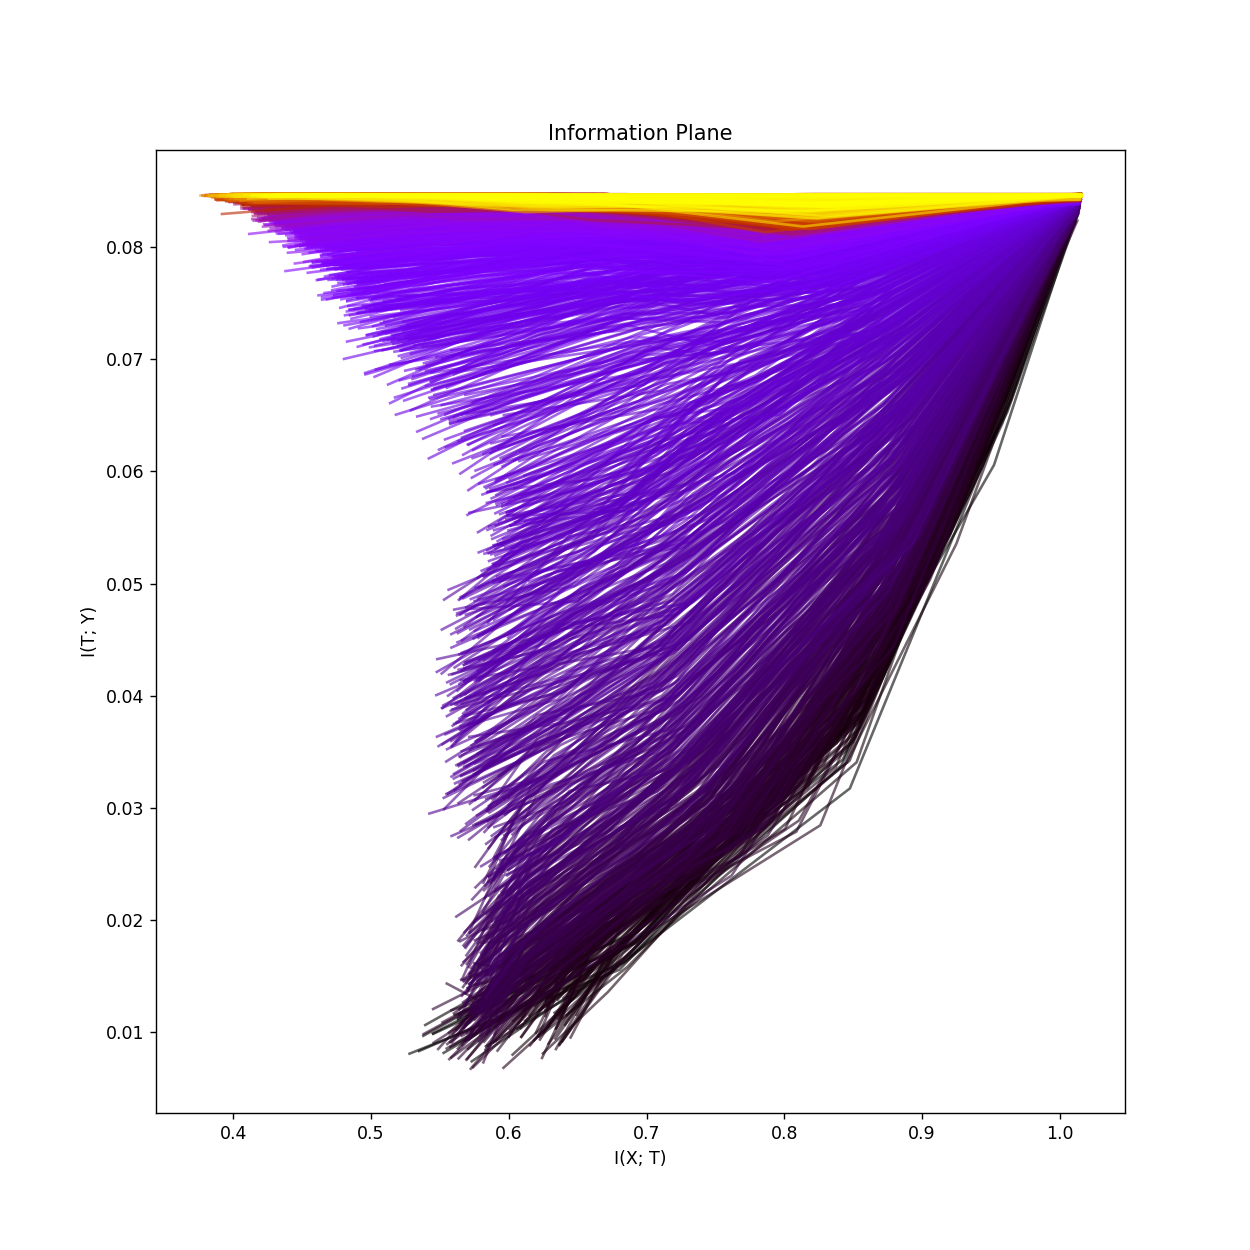

In [33]:
%matplotlib notebook
plot_information_plane('results/idnns_en_mi.npy',
                       'results/idnns_de_mi.npy',
                       save_path='results/info_plane.png')